# Экспериментальное исследование алгоритмов для регулярных запросов

## Постановка задачи


Исследование посвящено анализу производительности алгоритмов решения задачи достижимости с регулярными ограничениями.  

<br/>

Исследуются решения трёх вариаций задачи достижимости
1. Достижимость между всеми парами вершин
1. Достижимость для всего множества заданных вершин
1. Достижимость для каждой из заданного множества стартовых вершин

<br/>

В ходе исследования определяются ответы на следующие вопросы
1. При каких условиях использование библиотеки [pygraphblas](https://github.com/Graphegon/pygraphblas) разреженной линейной алгебры даёт выигрыш в производительности по сравнению с использованием библиотеки [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html)? Для каждой из трёх задач.
1. Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные? (При использовании библиотеки [pygraphblas](https://github.com/Graphegon/pygraphblas))
1. На сколько решение второй вариации задачи медленнее решения третьей при одинаковых начальных условиях? (При использовании библиотеки [pygraphblas](https://github.com/Graphegon/pygraphblas))

## Описание исследуемых решений

Во всех исследуемых решениях для представления матриц смежности используется их булевы декомпозиции по символам алфавита языка.

<br/>

Описание решений для каждой вариации задачи достижимости с регулярными ограничениями
1. Достижимость между всеми парами вершин
  - С помощью произведения Кронекера матрицы смежности входного графа и матрицы смежности конечного автомата, соответствующего входному регулярному выражению, получается матрица смежности конечного автомата, распознающего пересечение языков, задаваемых входными графом и регулярным выражением
  - Полученная матрица смежности редуцируется до одной булевой матрицы с единицами на месте непустых множеств и нулями на месте -- пустых
  - С помощью быстрого возведения в степень находится транзитивное замыкание полученной булевой матрицы
  - Перебор всех ненулевых элементов полученной на предыдущем шаге матрицы позволяет определить все пары вершин $(u, v)$ входного графа такие, что вершина $v$ достижима из вершины $u$ с данным регулярным ограничением
1. Достижимость для всего множества заданных вершин
  - Задача решается с помощью синхронного обхода в ширину входного графа и конечного автомата, соответствующего входному регулярному выражению
  - Во время синхронного обхода в ширину поддерживаются две булевы матрицы
    - `visited`, элемент в $i$-ой строке и $j$-ом столбце которой содержит единицу, если в ходе синхронного обхода была достигнута $j$-ая вершина графа в то время, как автомат находился в $i$-ом состоянии
    - `front`, элемент в $i$-ой строке и $j$-ом столбце которой содержит единицу, если **на предыдущем шаге** синхронного обхода была достигнута $j$-ая вершина графа в то время, как автомат находился в $i$-ом состоянии
  - Изначально в обеих матрицах на пересечении $i$-ой строки и $j$-ого столбца стоит единица, если $i$-ое состояние автомата является начальным, а $j$-ая вершина графа входит в стартовое множество
  - На каждом шаге синхронного обхода для получения нового `front`-а производится умножение матрицы `front` на матрицу смежности графа и переупорядочивание её строк в соответствии с матрицей смежности автомата, после чего к новому фронту применяется комплиментарная маска `visited` и он прибавляется к матрице `visited`
  - Процесс продолжается, пока `front` не станет нулевым
  - В итоге индексы достижимых с данным регулярным ограничением вершин -- это индексы тех столбцов матрицы `visited`, которые на пересечение со строками, соответствующими конечным состояниям автомата, содержат хотя бы одну единицу
1. Достижимость для каждой из заданного множества стартовых вершин
  - Задача решается путём параллельного решения предыдущей задачи с одно элементным стартовым множеством для каждой стартовой вершины
  - Параллельность достигается с помощью замены матрицы `front` на соединение по-вертикале матриц `front`, соответствующих каждому одно элементному стартовому множеству, и аналогичной замены для матрицы `visited`

## Подготовка окружения (для запуска в Google Colab)

### Установка Python 3.8

In [ ]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py38" --user

### Клонирование GitHub репозитория с реализациями алгоритмов и установка зависимостей

In [ ]:
!git clone https://github.com/IlyaMuravjov/formal-lang-course.git
%cd formal-lang-course
!git checkout task5
!git pull
!pip install -r requirements.txt
!pip install matplotlib

### **Чтобы продолжить в Google Colab, перезапустите RUNTIME для обновления доступных библиотек и перезагрузите страницу для обновления используемой версии Python**

### Импорты

In [ ]:
import sys
sys.path.insert(0, "/content/formal-lang-course")

import math
import textwrap
import logging
import pandas as pd
import cfpq_data
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from functools import reduce
from typing import List
from typing import Tuple
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch

import project.scipy_sparse_bool_decomposed_nfa
import project.pygraphblas_bool_decomposed_nfa

from project.fa_utils import regex_to_minimal_dfa
from project.graph_utils import get_graph
from project.graph_utils import get_graph_data
from project.graph_utils import to_graph_data
from project.regular_path_query import regular_path_query_all_pairs
from project.regular_path_query import regular_path_query_multiple_source
from project.time_utils import timeit_with_time_limit

### Прочие настройки

Отключение логирования уровня `INFO`, чтобы не засорять выходной поток комментариями происходящего библиотекой CFPQ_Data (опционально)

In [ ]:
logging.disable(logging.INFO)

Объявление вспомогательных функций

In [ ]:
def finites(iter):
    return (x for x in iter if np.isfinite(x))

Отключение ограничения размера таблиц (опционально)

In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

## Описание набора данных для экспериментов

### Графы

Для проведения эксперимента графы выбирались из набора данных [CFPQ_Data](https://jetbrains-research.github.io/CFPQ_Data/dataset/index.html). Далее приведён график, показывающий число вершин и различных меток в графах из данного набора данных, содержащих до $50\ 000$ вершин и до $100\ 000$ рёбер, данное ограничение на размер графов вызвано ограничениями на время проведения эксперимента.

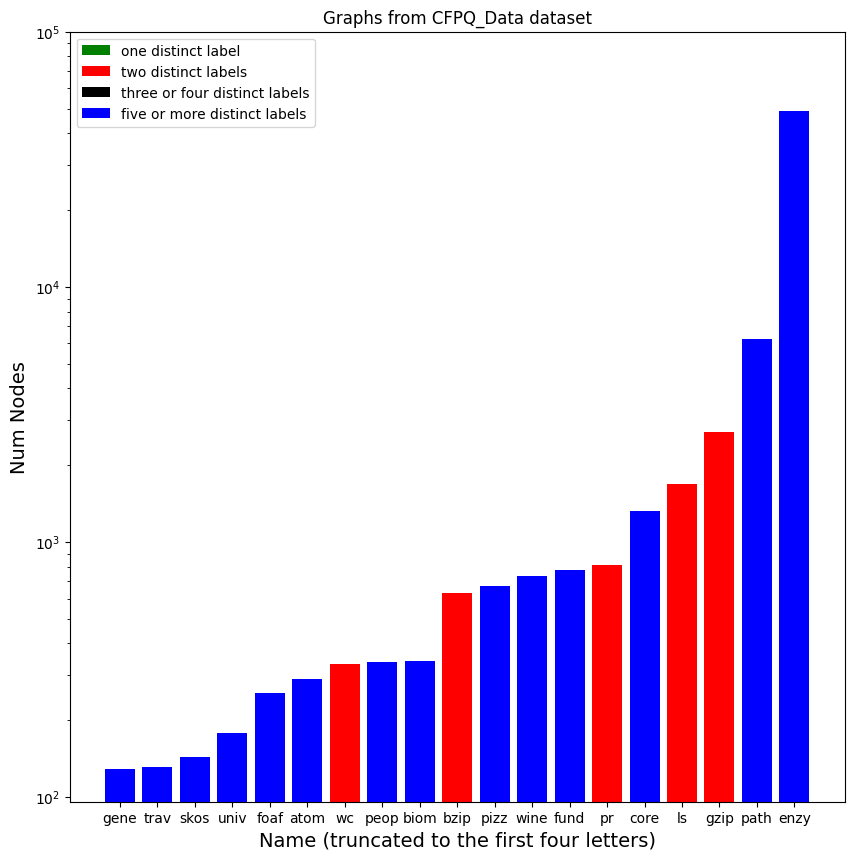

In [ ]:
ALL_GRAPHS = [
    "skos",
    "wc",
    "generations",
    "travel",
    "univ",
    "atom",
    "biomedical",
    "bzip",
    "foaf",
    "people",
    "pr",
    "funding",
    "ls",
    "wine",
    "pizza",
    "gzip",
    "core",
    "pathways",
    "enzyme",
]

graphs_to_data = sorted(
    [(graph, get_graph_data(graph)) for graph in ALL_GRAPHS],
    key=lambda pair: pair[1].node_count,
)
labels = [
    textwrap.shorten(graph, 4, placeholder="") for (graph, _) in graphs_to_data
]
values = [data.node_count for (_, data) in graphs_to_data]
colors = [
    "g"
    if len(data.label_occurrences) == 1
    else (
        "r"
        if len(data.label_occurrences) == 2
        else ("k" if len(data.label_occurrences) < 5 else "b")
    )
    for (_, data) in graphs_to_data
]
label_positions = np.arange(len(labels))
plt.figure(figsize=(10, 10))
plt.bar(label_positions, values, color=colors)
plt.title("Graphs from CFPQ_Data dataset")
plt.ylabel("Num Nodes", fontsize=14)
plt.xlabel("Name (truncated to the first four letters)", fontsize=14)
plt.yscale("log")
plt.yticks([100, 1000, 10_000, 100_000])
plt.xticks(label_positions, labels, fontsize=10)
plt.legend(
    loc="upper left",
    handles=[
        Patch(facecolor="g", label="one distinct label"),
        Patch(facecolor="r", label="two distinct labels"),
        Patch(facecolor="k", label="three or four distinct labels"),
        Patch(facecolor="b", label="five or more distinct labels"),
    ],
)
plt.show()

Обнаружилось, что графы выбранного размера из набора данных [CFPQ_Data](https://jetbrains-research.github.io/CFPQ_Data/dataset/index.html) имеют либо две различные метки рёбер, либо не менее пяти. Для повышения репрезентативности входных данных во время проведения эксперимента было решено использовать графы из обеих этих групп, а также выбрать графы различных размеров.

<br/>

Для проведения эксперимента были выбраны следующие графы

In [ ]:
GRAPHS_WITH_TIME_LIMITS = [
    ("generations", 1),
    ("wc", 1),
    ("pizza", 1),
    ("gzip", 3),
    ("enzyme", 10),
]
GRAPHS = [graph_name for graph_name, _ in GRAPHS_WITH_TIME_LIMITS]

In [62]:
pd.DataFrame(
    [
        (
            graph_name,
            get_graph(graph_name).number_of_nodes(),
            get_graph(graph_name).number_of_edges(),
        )
        for graph_name in GRAPHS
    ],
    columns=["Name", "Num nodes", "Num edges"],
)

Name  Num nodes  Num edges
0  generations        129        273
1           wc        332        269
2        pizza        671       1980
3         gzip       2687       2293
4       enzyme      48815      86543

### Запросы

Чтобы увеличить разнообразие входных данных, было решено использовать запросы с конечными автоматами различных размеров и задающие, как языки длина, всех слов которых ограничена конечным числом, так и те, слова которых могут быть произвольно длинными.

<br/>

В связи с этим для проведения замеров были выбраны следующие регулярные выражения, в которых при их применении их к конкретным графам символ `'a'` заменяется на самую часто встречаемую в графе метку рёбер, а символ `'b'` на -- вторую наиболее встречаемую.

In [ ]:
SYMBOLS: List[str] = ["(s 1)", "(s 2)"]

REGEXES: List[Tuple[str, str]] = [
    (f"(a.a|b)^{n}" if n > 1 else "a.a|b", n * "((s 1) (s 1)|(s 2))")
    for n in [1, 4, 16]
] + [
    (
        f"((a.a|b)^{n})*" if n > 1 else "(a.a|b)*",
        "(" + (n * "((s 1) (s 1)|(s 2))") + ")*",
    )
    for n in [1, 4, 16]
]

def adapt_regexes_for_graph(graph: nx.Graph) -> List[Tuple[str, str]]:
    graph_data = to_graph_data(graph)
    sorted_labels = sorted(
        graph_data.label_occurrences,
        key=lambda label: (-graph_data.label_occurrences[label], label),
    )
    return [
        (
            regex_name,
            reduce(
                lambda s, pair: s.replace(pair[0], pair[1]),
                zip(SYMBOLS, sorted_labels),
                regex_template,
            ),
        )
        for (regex_name, regex_template) in REGEXES
    ]

In [ ]:
regex_name_to_dfa = [
    (
        regex_name,
        regex_to_minimal_dfa(
            reduce(
                lambda s, pair: s.replace(pair[0], pair[1]),
                zip(SYMBOLS, ["a", "b"]),
                regex_template,
            )
        ),
    )
    for (regex_name, regex_template) in REGEXES
]
pd.DataFrame(
    [
        (regex_name, len(dfa.states), dfa.get_number_transitions())
        for (regex_name, dfa) in regex_name_to_dfa
    ],
    columns=[
        "Regex",
        "Num states in Minimal DFA",
        "Num transitions in minimal DFA",
    ],
)

Regex  Num States In Minimal DFA  Num Transitions In Minimal DFA
0          a.a|b                          3                               3
1      (a.a|b)^4                          9                              12
2     (a.a|b)^16                         33                              48
3       (a.a|b)*                          2                               3
4   ((a.a|b)^4)*                          8                              12
5  ((a.a|b)^16)*                         32                              48

### Стартовое множество

#### Генерация

Чтобы эксперимент был воспроизводимым, для генерации стартового множества вершин использовалась [функция](https://jetbrains-research.github.io/CFPQ_Data/reference/graphs/generated/cfpq_data.graphs.utils.multiple_source_utils.html#cfpq_data.graphs.utils.multiple_source_utils.generate_multiple_source_percent), предоставляемая библиотекой [CFPQ_Data](https://github.com/JetBrains-Research/CFPQ_Data) с предопределённым параметром `seed`, так как от того, как именно устроено стартовое множество, сильно зависит время вычисления запроса.

<br/>

Чтобы избежать неверных выводов, вызванных тем, что один алгоритм может работать быстрее другого именно при запуске на конкретном стартовом множестве, генерируемом при выбранном `seed`-е, хотя в среднем по всем стартовым множеством данного размера он медленнее, было решено для каждого набора входных данных запускать каждый алгоритм не с одним `seed`-ом, а с фиксированным и одинаковым для всех алгоритмов диапазоном `seed`-ов.

<br/>

Благодаря этому, случаи когда время работы сильно зависит от стартового множества можно распознавать по большому стандартному отклонению, так как среднее значение и стандартное отклонение считаются по всем `seed`-ам из фиксированного диапазона.

In [ ]:
SEEDS = range(10)

#### Размер

Так как для разных графов допустимы различные размеры стартовых множеств, то было решено использовать не абсолютный, а относительный размер стартового множества, а именно в стартовое множество было решено включать $100\%\cdot2^{-n}$ от всех вершин графа для всех целых $n \in [0, 9]$.

<br/>

Помимо удобства данное решение также было мотивировано предположением, что отношение времени работы разных алгоритмов зависит не от абсолютного, а от относительно размера стартового множеств.

In [ ]:
STARTING_PERCENTAGES = [100 / 2**n for n in reversed(range(10))]

def get_starting_percentages_for_graph(graph):
    return [
        percent
        for percent in STARTING_PERCENTAGES
        if int(graph.number_of_nodes() / 100 * percent) > 0
    ]

## Описание эксперимента

### Оборудование

GPU не подключен, так как [pygraphblas](https://github.com/Graphegon/pygraphblas) в качестве реализации стандарта GraphBLAS использует [SuiteSparse:GraphBLAS](https://github.com/DrTimothyAldenDavis/GraphBLAS), поддержка GPU для которого всё ещё в процессе разработки.

In [ ]:
!printf 'OS:\n'
!grep '^NAME' /etc/os-release
!grep '^VERSION' /etc/os-release

!printf '\n\nCPU:\n'
!lscpu

!printf '\n\nRAM:\n'
!grep MemTotal /proc/meminfo

!printf '\n\n'

import os
if int(os.environ["COLAB_GPU"]) > 0:
  print("A GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
  print("A TPU is connected.")
else:
  print("No accelerator is connected.")

OS:
NAME="Ubuntu"
VERSION="18.04.6 LTS (Bionic Beaver)"
VERSION_ID="18.04"
VERSION_CODENAME=bionic


CPU:
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.262
BogoMIPS:            4400.52
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid ss

### Проводимые замеры

#### Определения того, при каких условиях использование библиотеки [pygraphblas](https://github.com/Graphegon/pygraphblas) разреженной линейной алгебры даёт выигрыш в производительности по сравнению с использованием библиотеки [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html)

Было произведено по десять замеров времени работы для каждого из трёх алгоритмов для каждой из двух библиотек линейной алгебры для каждого из пяти выбранных ранее графов для каждого из шести выбранных запросов и в случае алгоритмов, решающих задачу для заданного стартового множества, для каждого из допустимых для данного графа размеров начального множества среди выбранных десяти размеров.

</br>

Такой полный перебор всех возможных комбинаций выбранных в предыдущих разделах значений всех начальных условий был произведён для проведения максимально полного анализа.

</br>

Для уменьшения времени, занимаемого экспериментом:
  - Для каждого графа было ограничено время работы одного запуска алгоритма на нём, чтобы не тратить время на замеры на тех входных данных, на которых применение конкретного алгоритма крайне нецелесообразно
  - При превышении ограничения времени исполнения во время одного из десяти замеров, замер прерывался и повторные замеры при тех же условиях не проводились
  - При превышении ограничения времени исполнения реализациями алгоритмов, время работы которых зависит от размера стартового множества, замеры времени работы той же реализации для б**о**льших размеров стартовых множеств и при тех же остальных условиях не проводились

</br>

Далее приведена таблица с ограничениями по времени исполнения одного запуска для каждого графа

In [ ]:
pd.DataFrame(
    [
        (
            graph_name,
            get_graph(graph_name).number_of_nodes(),
            get_graph(graph_name).number_of_edges(),
            time_limit,
        )
        for graph_name, time_limit in GRAPHS_WITH_TIME_LIMITS
    ],
    columns=["Name", "Num nodes", "Num edges", "Time limit, s"],
)

Name  Num nodes  Num edges  Time limit, s
0  generations        129        273              1
1           wc        332        269              1
2        pizza        671       1980              1
3         gzip       2687       2293              3
4       enzyme      48815      86543             10

#### Определение того, начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные и на сколько решение второй вариации задачи медленнее решения третьей при одинаковых начальных условиях (при использовании библиотеки [pygraphblas](https://github.com/Graphegon/pygraphblas))

Для ответа на данные два вопроса достаточно подмножества результатов замеров, которые были проведены для ответа на первый вопрос, а именно интересуют те замеры, в которых фигурируют реализации, использующие библиотеку [pygraphblas](https://github.com/Graphegon/pygraphblas).

<br/>

Дополнительных замеров производить не требуется, так как замеры для всех возможных комбинаций выбранных в предыдущих разделах значений всех начальных условий уже произведены.

## Результаты экспериментов

Результаты экспериментов в данном разделе представлены в виде достаточно "сырых" данных. Результаты в виде удобном для анализа и их анализ можно найти в следующем разделе.

In [ ]:
BOOL_DECOMPOSED_NFA_CLASSES = [
    (
        "scipy.sparse",
        project.scipy_sparse_bool_decomposed_nfa.BoolDecomposedNFA,
        "b",
    ),
    ("pygraphblas", project.pygraphblas_bool_decomposed_nfa.BoolDecomposedNFA, "r"),
]

def get_multiple_source_rpq_algorithm_name(
    group_by_start, starting_percentage
) -> str:
    return f"Multiple source: group_by_start={group_by_start}, starting_percentage={round(starting_percentage, 3)}%"

# tuple (algorithm_name, algorithm implementation (lambda), faster algorithm name or None, is applicable to graph (lambda))
ALGORITHMS = [
    (
        "All pairs",
        lambda regex, graph, bool_decomposed_nfa_cls, _: regular_path_query_all_pairs(
            regex, graph, bool_decomposed_nfa_cls=bool_decomposed_nfa_cls
        ),
        None,
        lambda graph: True,
    )
] + [
    (
        get_multiple_source_rpq_algorithm_name(group_by_start, starting_percentage),
        lambda regex, graph, bool_decomposed_nfa_cls, seed, group_by_start=group_by_start, starting_percentage=starting_percentage: regular_path_query_multiple_source(
            regex,
            graph,
            group_by_start=group_by_start,
            start_states=cfpq_data.generate_multiple_source_percent(
                graph, starting_percentage, seed=seed
            ),
            bool_decomposed_nfa_cls=bool_decomposed_nfa_cls,
        ),
        get_multiple_source_rpq_algorithm_name(
            group_by_start, starting_percentage / 2
        ),
        lambda graph, starting_percentage=starting_percentage: int(
            graph.number_of_nodes() / 100 * starting_percentage
        )
        > 0,
    )
    for group_by_start in [True, False]
    for starting_percentage in STARTING_PERCENTAGES
]

In [ ]:
# key is tuple (algorithm_name, graph_name, regex_name, lib_name)
# value is tuple (mean time in seconds, standard deviation in seconds)
res = dict()

for (
    algorithm_name,
    algorithm_impl,
    faster_algorithm_name,
    is_applicable_for,
) in ALGORITHMS:
    for graph_name, time_limit_secs in GRAPHS_WITH_TIME_LIMITS:
        graph = get_graph(graph_name)
        if is_applicable_for(graph):
            for (regex_name, adapted_regex) in adapt_regexes_for_graph(graph):
                for (
                    lib_name,
                    bool_decomposed_nfa_cls,
                    _,
                ) in BOOL_DECOMPOSED_NFA_CLASSES:
                    times = []
                    faster_algorithm_key = (
                        faster_algorithm_name,
                        graph_name,
                        regex_name,
                        lib_name,
                    )
                    if faster_algorithm_key not in res or np.isfinite(
                        res[faster_algorithm_key][0]
                    ):
                        for seed in SEEDS:
                            time = timeit_with_time_limit(
                                lambda: algorithm_impl(
                                    adapted_regex,
                                    graph,
                                    bool_decomposed_nfa_cls,
                                    seed,
                                ),
                                time_limit_secs,
                            )
                            if np.isfinite(time):
                                times.append(time)
                            else:
                                times = []
                                break
                    res[(algorithm_name, graph_name, regex_name, lib_name)] = (
                        np.mean(times),
                        np.std(times),
                    )

In [ ]:
raw_data = []
for (algorithm_name, _, _, is_applicable_for) in ALGORITHMS:
    for graph_name in [
        graph_name
        for graph_name in GRAPHS
        if is_applicable_for(get_graph(graph_name))
    ]:
        for regex_name, _ in REGEXES:
            scipy_mean, scipy_std = res[
                (algorithm_name, graph_name, regex_name, "scipy.sparse")
            ]
            if np.isfinite(scipy_mean):
                presion = max(0, math.ceil(-math.log10(scipy_std)))
                scipy_part = f"{scipy_mean:.{presion}f} ± {scipy_std:.{presion}f}"
            else:
                scipy_part = "Didn't finish"
            pygraphblas_mean, pygraphblas_std = res[
                (algorithm_name, graph_name, regex_name, "pygraphblas")
            ]
            if np.isfinite(pygraphblas_mean):
                presion = max(0, math.ceil(-math.log10(pygraphblas_std)))
                pygraphblas_part = f"{pygraphblas_mean:.{presion}f} ± {pygraphblas_std:.{presion}f}"
            else:
                pygraphblas_part = "Didn't finish"
            raw_data.append(
                (
                    algorithm_name,
                    graph_name,
                    regex_name,
                    scipy_part,
                    pygraphblas_part,
                )
            )
pd.DataFrame(
    raw_data,
    columns=[
        "algorithm",
        "graph",
        "regex",
        "scipy time ± σ, s",
        "pygraphblas time ± σ, s",
    ],
)

algorithm  ... pygraphblas time ± σ, s
0                                                            All pairs  ...         0.0063 ± 0.0002
1                                                            All pairs  ...           0.011 ± 0.002
2                                                            All pairs  ...           0.028 ± 0.003
3                                                            All pairs  ...         0.0071 ± 0.0009
4                                                            All pairs  ...         0.0109 ± 0.0010
5                                                            All pairs  ...           0.028 ± 0.003
6                                                            All pairs  ...           0.010 ± 0.002
7                                                            All pairs  ...           0.016 ± 0.001
8                                                            All pairs  ...           0.055 ± 0.002
9                                                            All pairs  ...         0.0102 ± 0.0002
10                                                           All pairs  ...         0.0173 ± 0.0003
11                                                           All pairs  ...           0.070 ± 0.003
12                                                           All pairs  ...         0.0392 ± 0.0004
13                                                           All pairs  ...         0.0509 ± 0.0006
14                                                           All pairs  ...           0.131 ± 0.003
15                                                           All pairs  ...         0.0409 ± 0.0005
16                                                           All pairs  ...           0.057 ± 0.003
17                                                           All pairs  ...           0.139 ± 0.003
18                                                           All pairs  ...         0.0673 ± 0.0009
19                                                           All pairs  ...           0.108 ± 0.004
20                                                           All pairs  ...           0.323 ± 0.005
21                                                           All pairs  ...           0.088 ± 0.002
22                                                           All pairs  ...           0.124 ± 0.003
23                                                           All pairs  ...           0.416 ± 0.003
24                                                           All pairs  ...               2.2 ± 0.4
25                                                           All pairs  ...             2.51 ± 0.01
26                                                           All pairs  ...                   6 ± 2
27                                                           All pairs  ...           2.283 ± 0.009
28                                                           All pairs  ...             2.78 ± 0.02
29                                                           All pairs  ...                   6 ± 2
30    Multiple source: group_by_start=True, starting_percentage=0.195%  ...         0.0314 ± 0.0006
31    Multiple source: group_by_start=True, starting_percentage=0.195%  ...           0.036 ± 0.003
32    Multiple source: group_by_start=True, starting_percentage=0.195%  ...           0.051 ± 0.004
33    Multiple source: group_by_start=True, starting_percentage=0.195%  ...         0.0315 ± 0.0004
34    Multiple source: group_by_start=True, starting_percentage=0.195%  ...           0.036 ± 0.002
35    Multiple source: group_by_start=True, starting_percentage=0.195%  ...           0.053 ± 0.007
36    Multiple source: group_by_start=True, starting_percentage=0.195%  ...         0.0447 ± 0.0005
37    Multiple source: group_by_start=True, starting_percentage=0.195%  ...           0.060 ± 0.007
38    Multiple source: group_by_start=True, starting_percentage=0.195%  ...             0.14 ± 0.08
39    Multiple source: group_by_start=True, starting_percenta

## Анализ результатов экспериментов

### Определения того, при каких условиях использование библиотеки [pygraphblas](https://github.com/Graphegon/pygraphblas) разреженной линейной алгебры даёт выигрыш в производительности по сравнению с использованием библиотеки [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html)

Для определения того, при каких условиях использование библиотеки [pygraphblas](https://github.com/Graphegon/pygraphblas) разреженной линейной алгебры даёт выигрыш в производительности по сравнению с использованием библиотеки [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html) была сформированы графики, сравнивающие время работы реализаций алгоритмов, использующих данные библиотеки.

<br/>

Отсутствие столбца на графике, означает что соответствующая реализация не завершила работу за отведённое время. Полосы ошибок показывают стандартное отклонение.

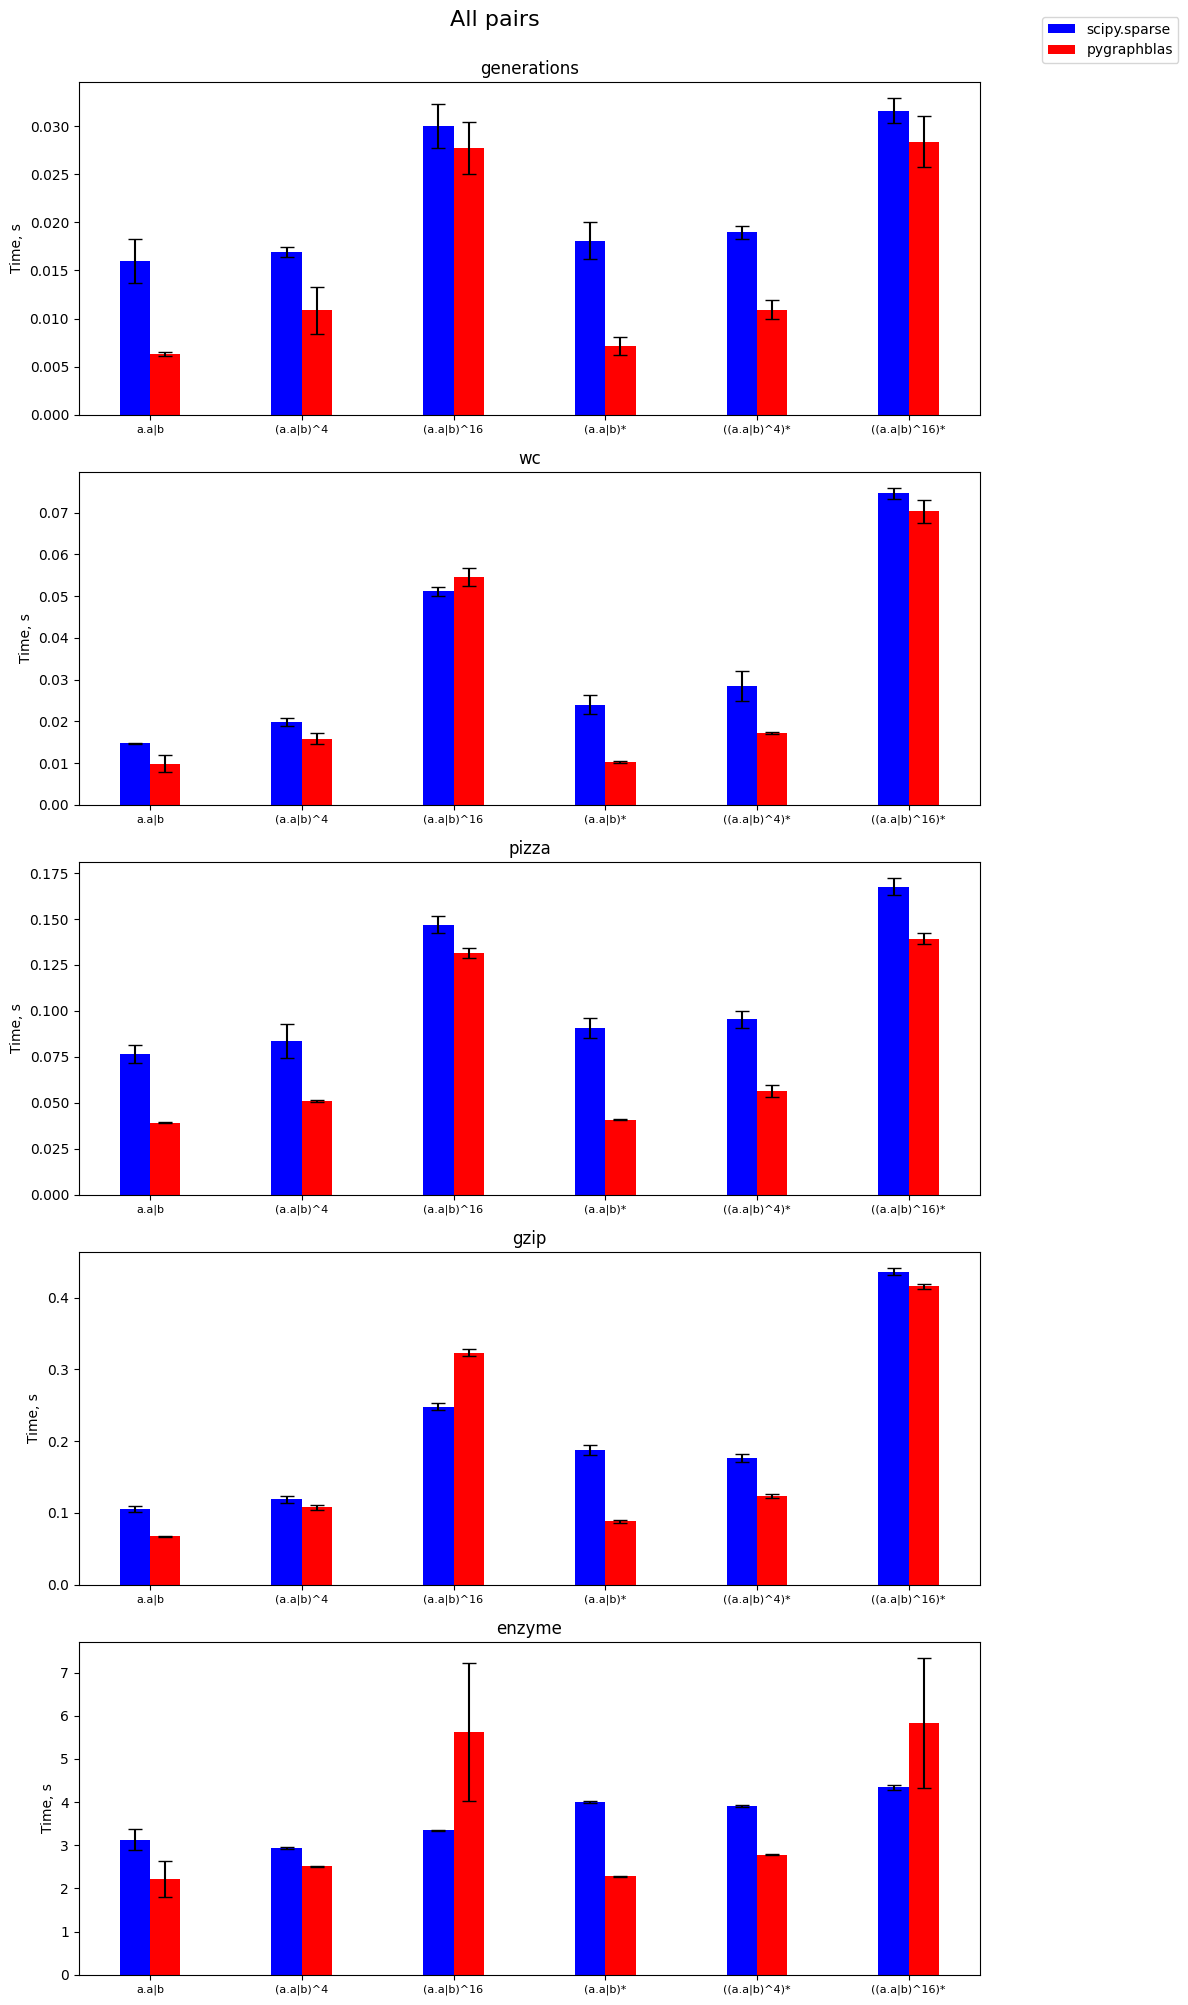

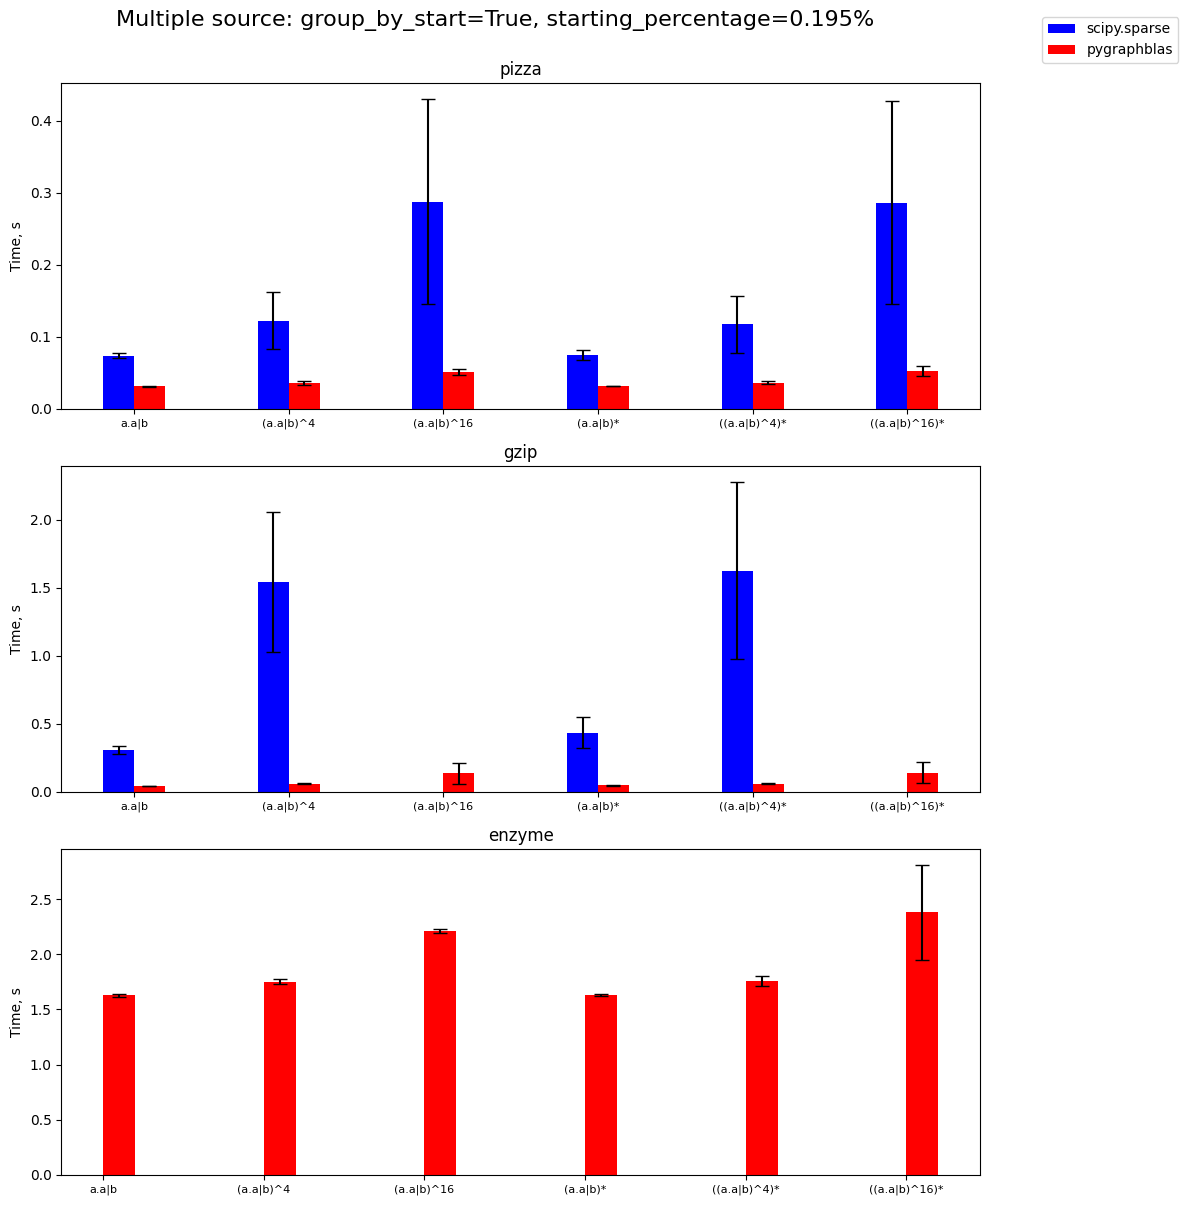

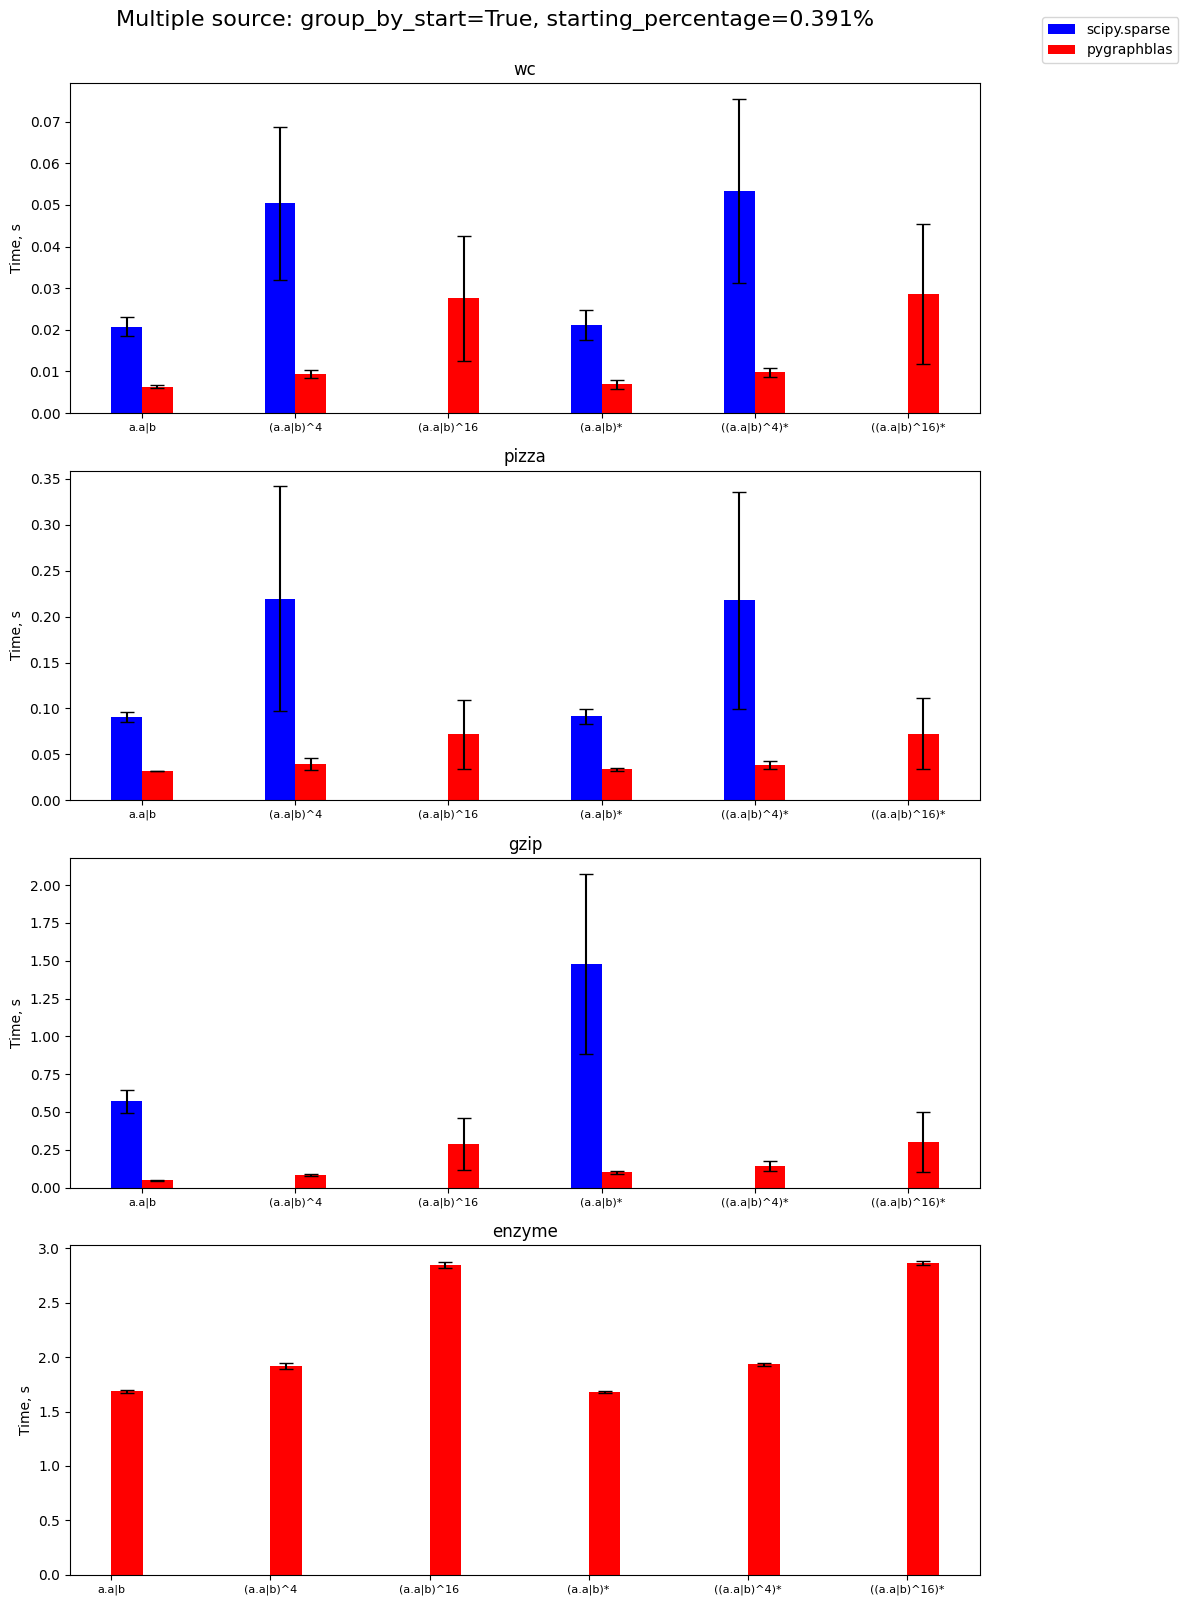

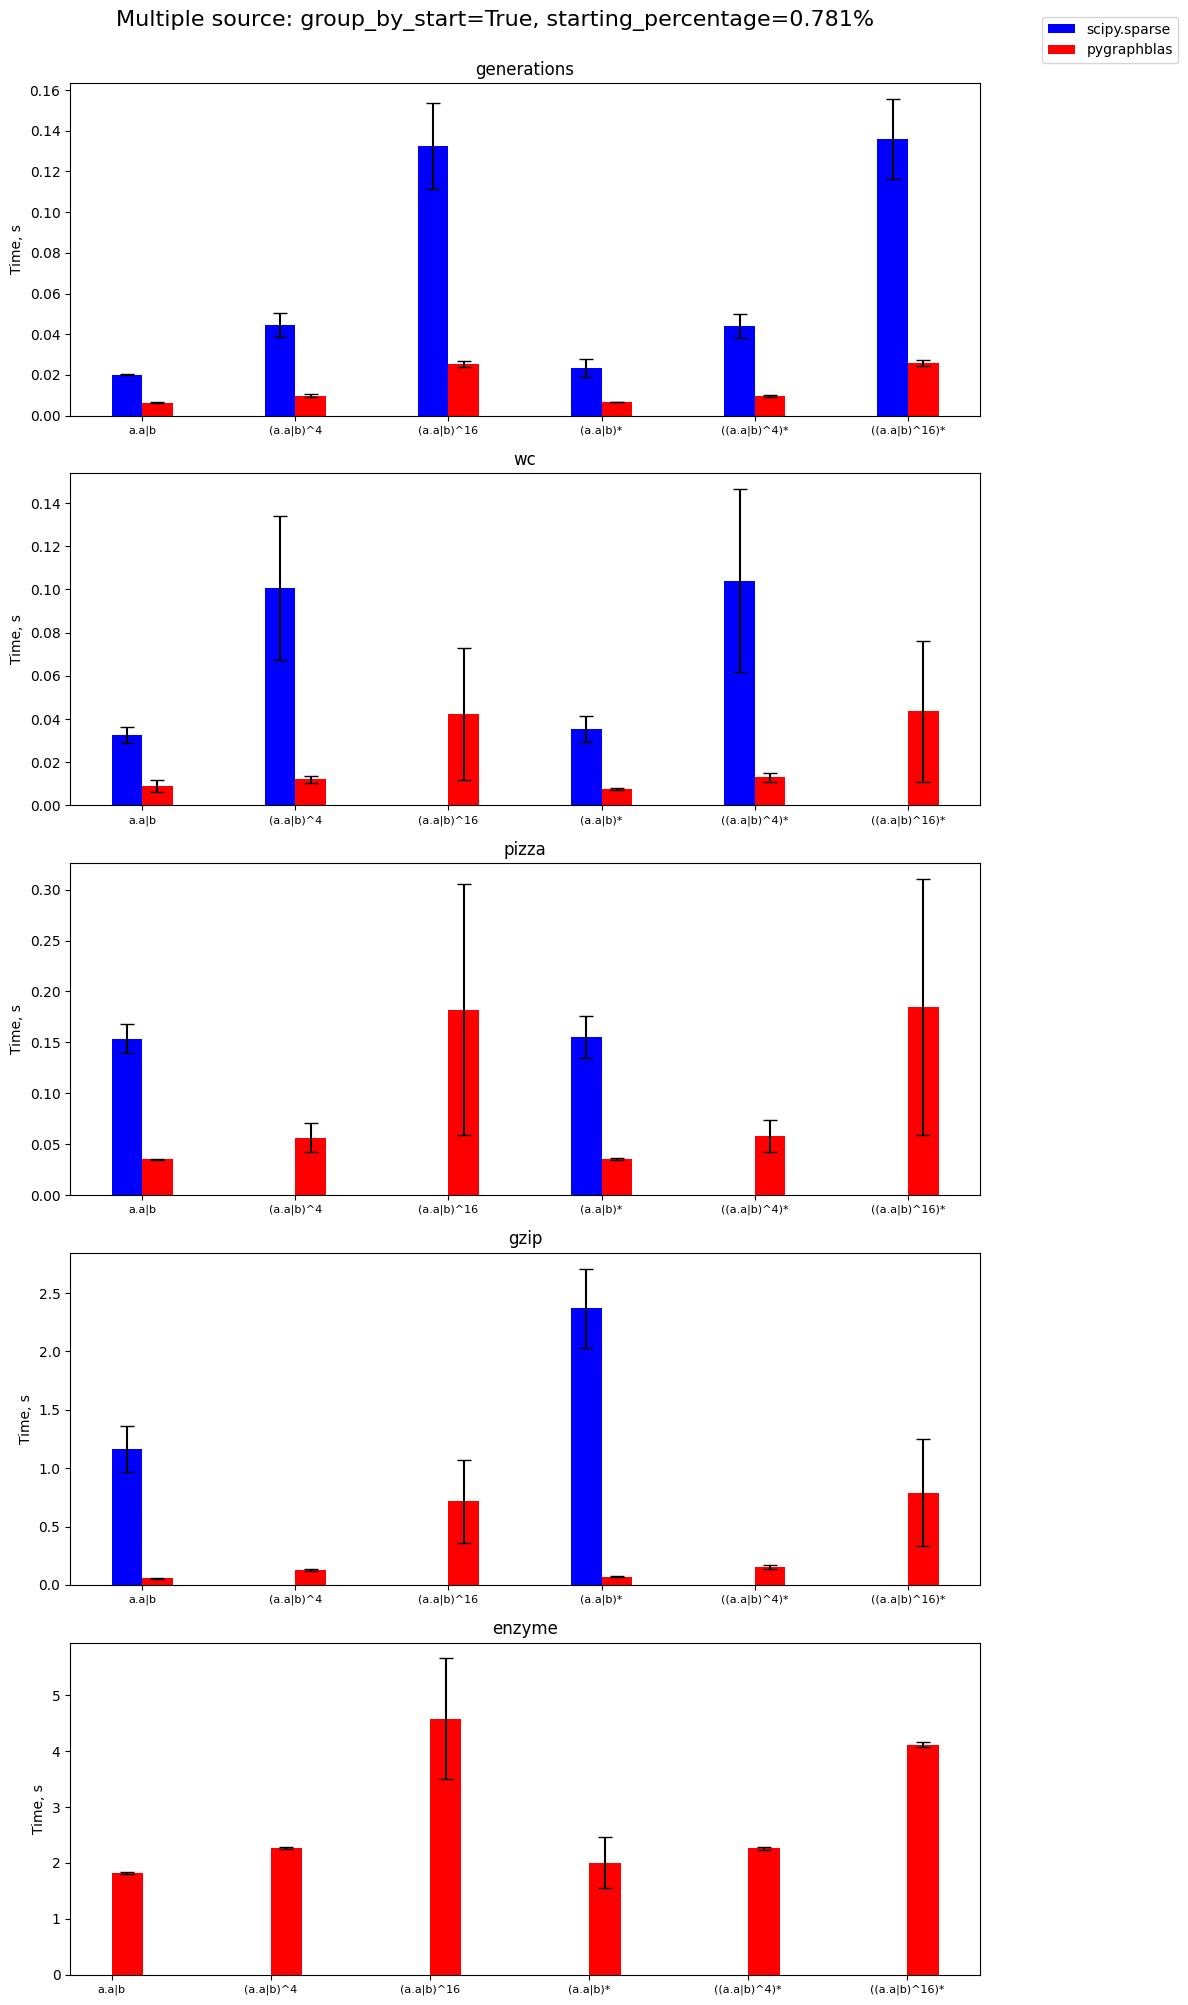

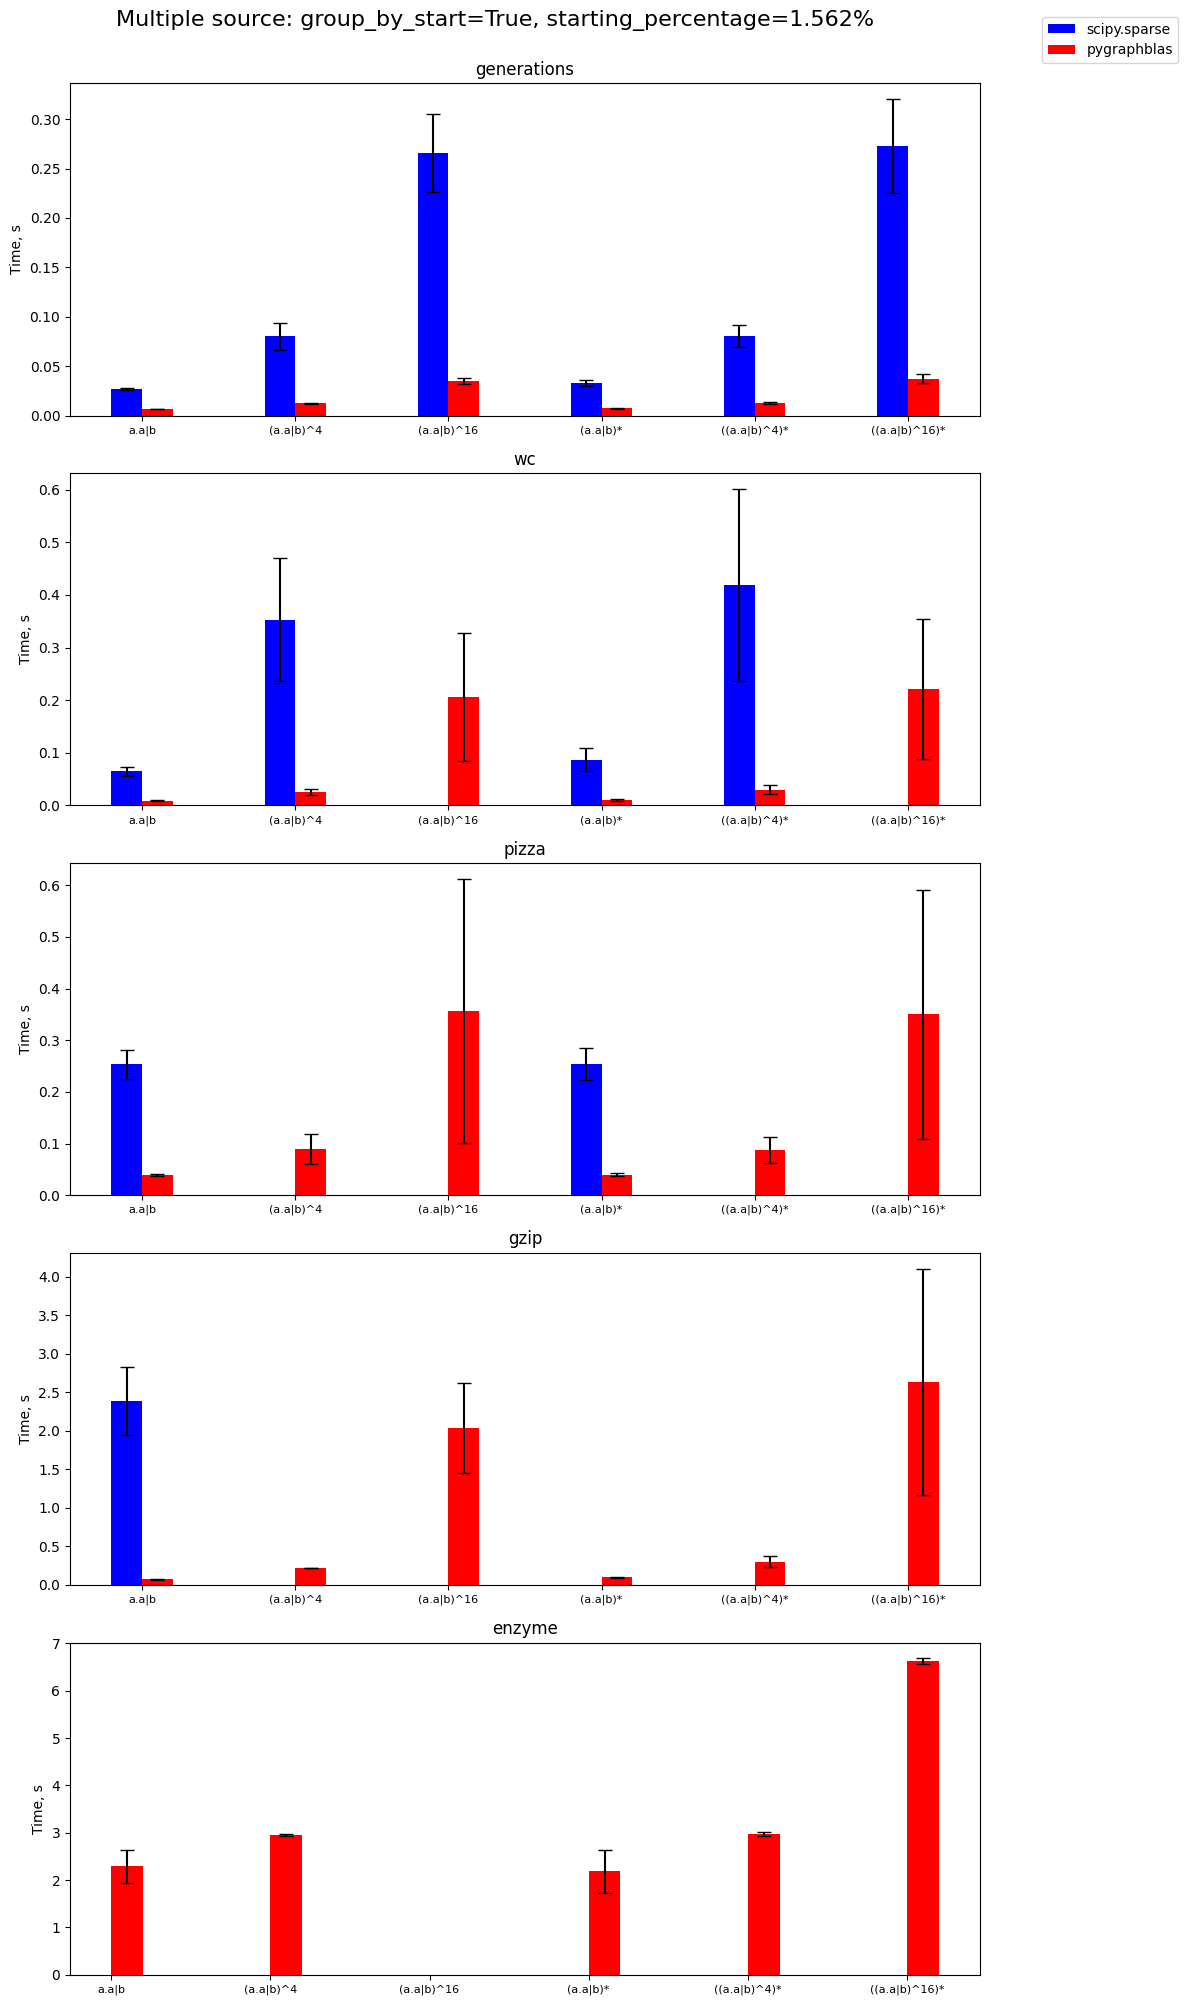

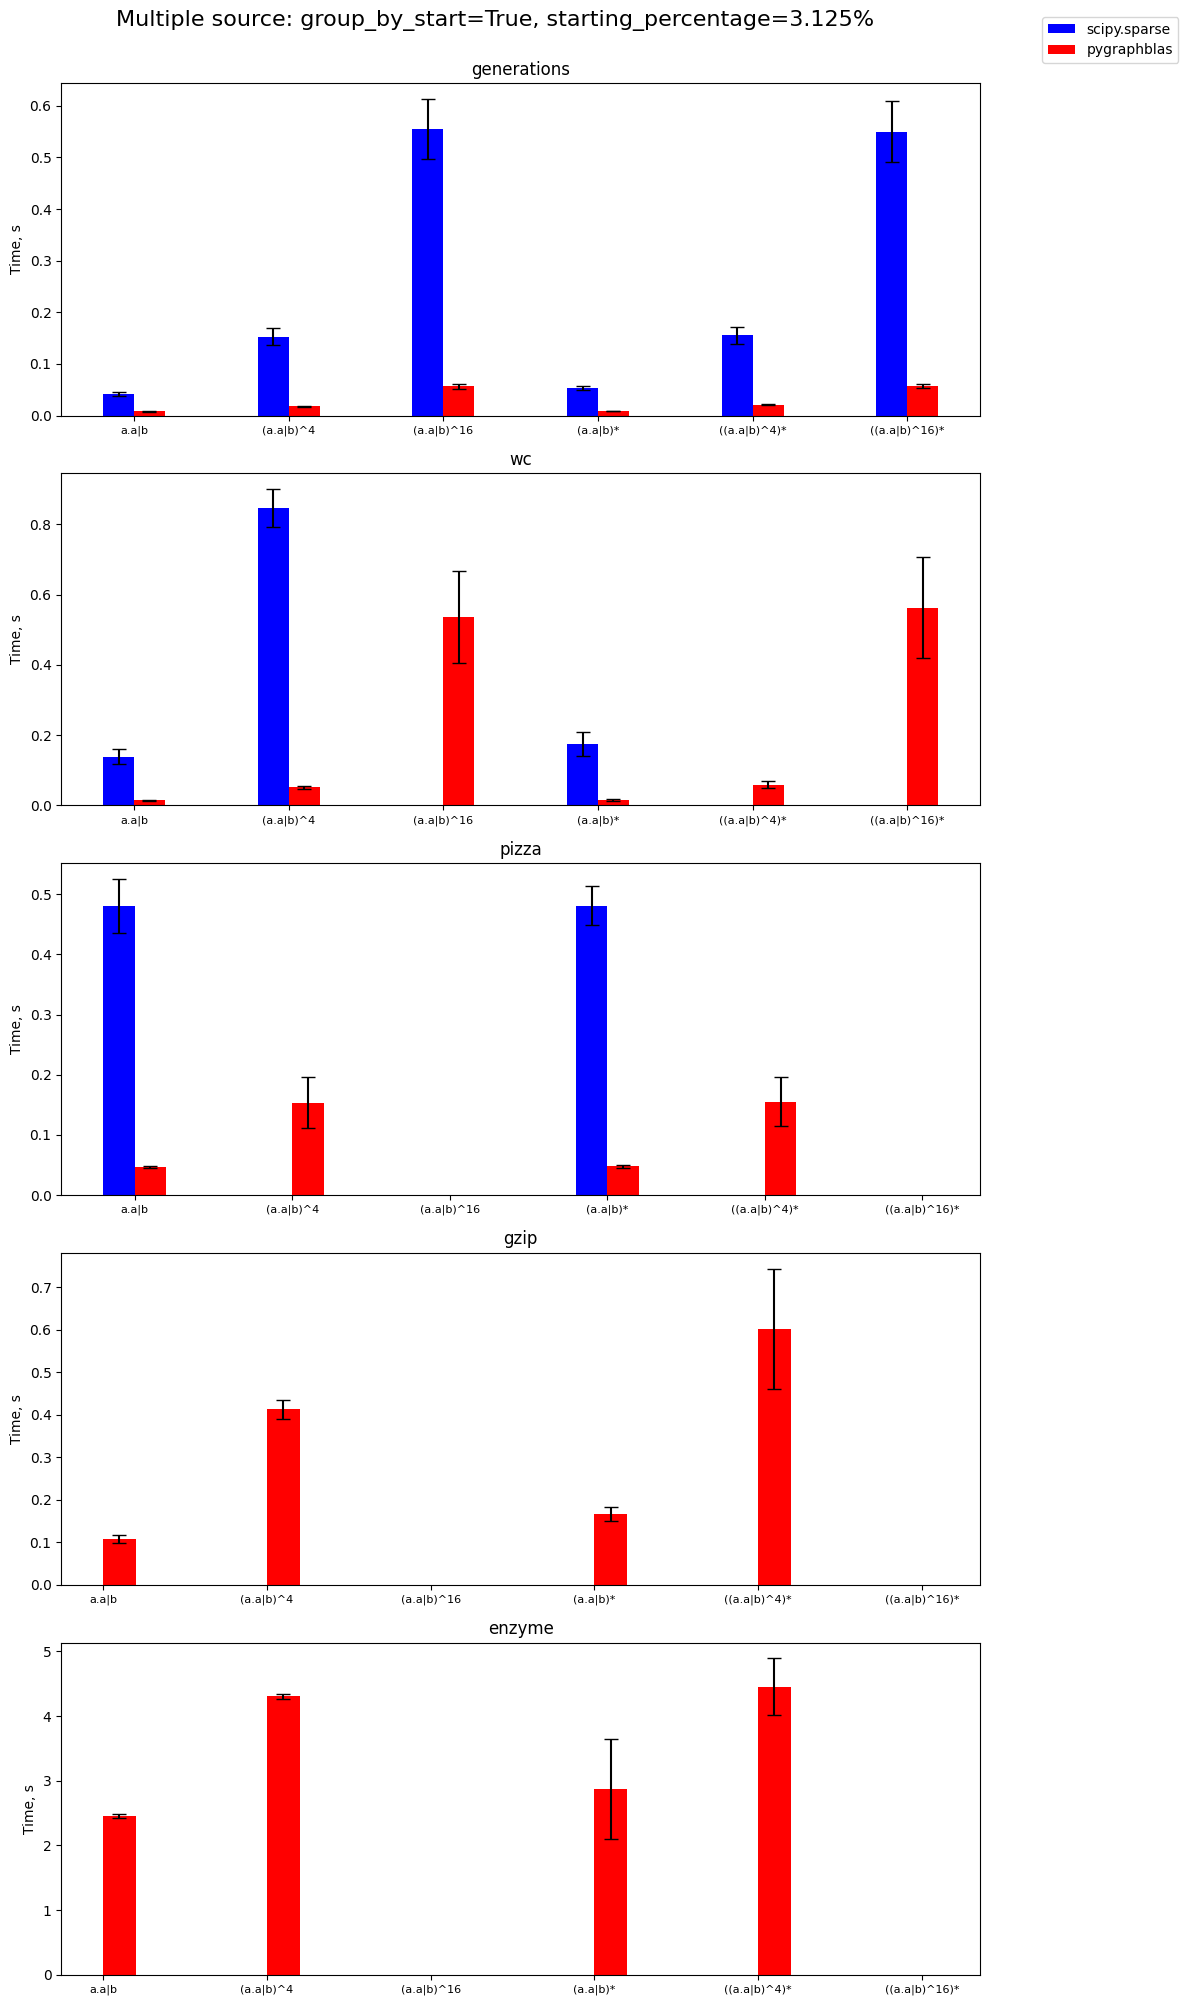

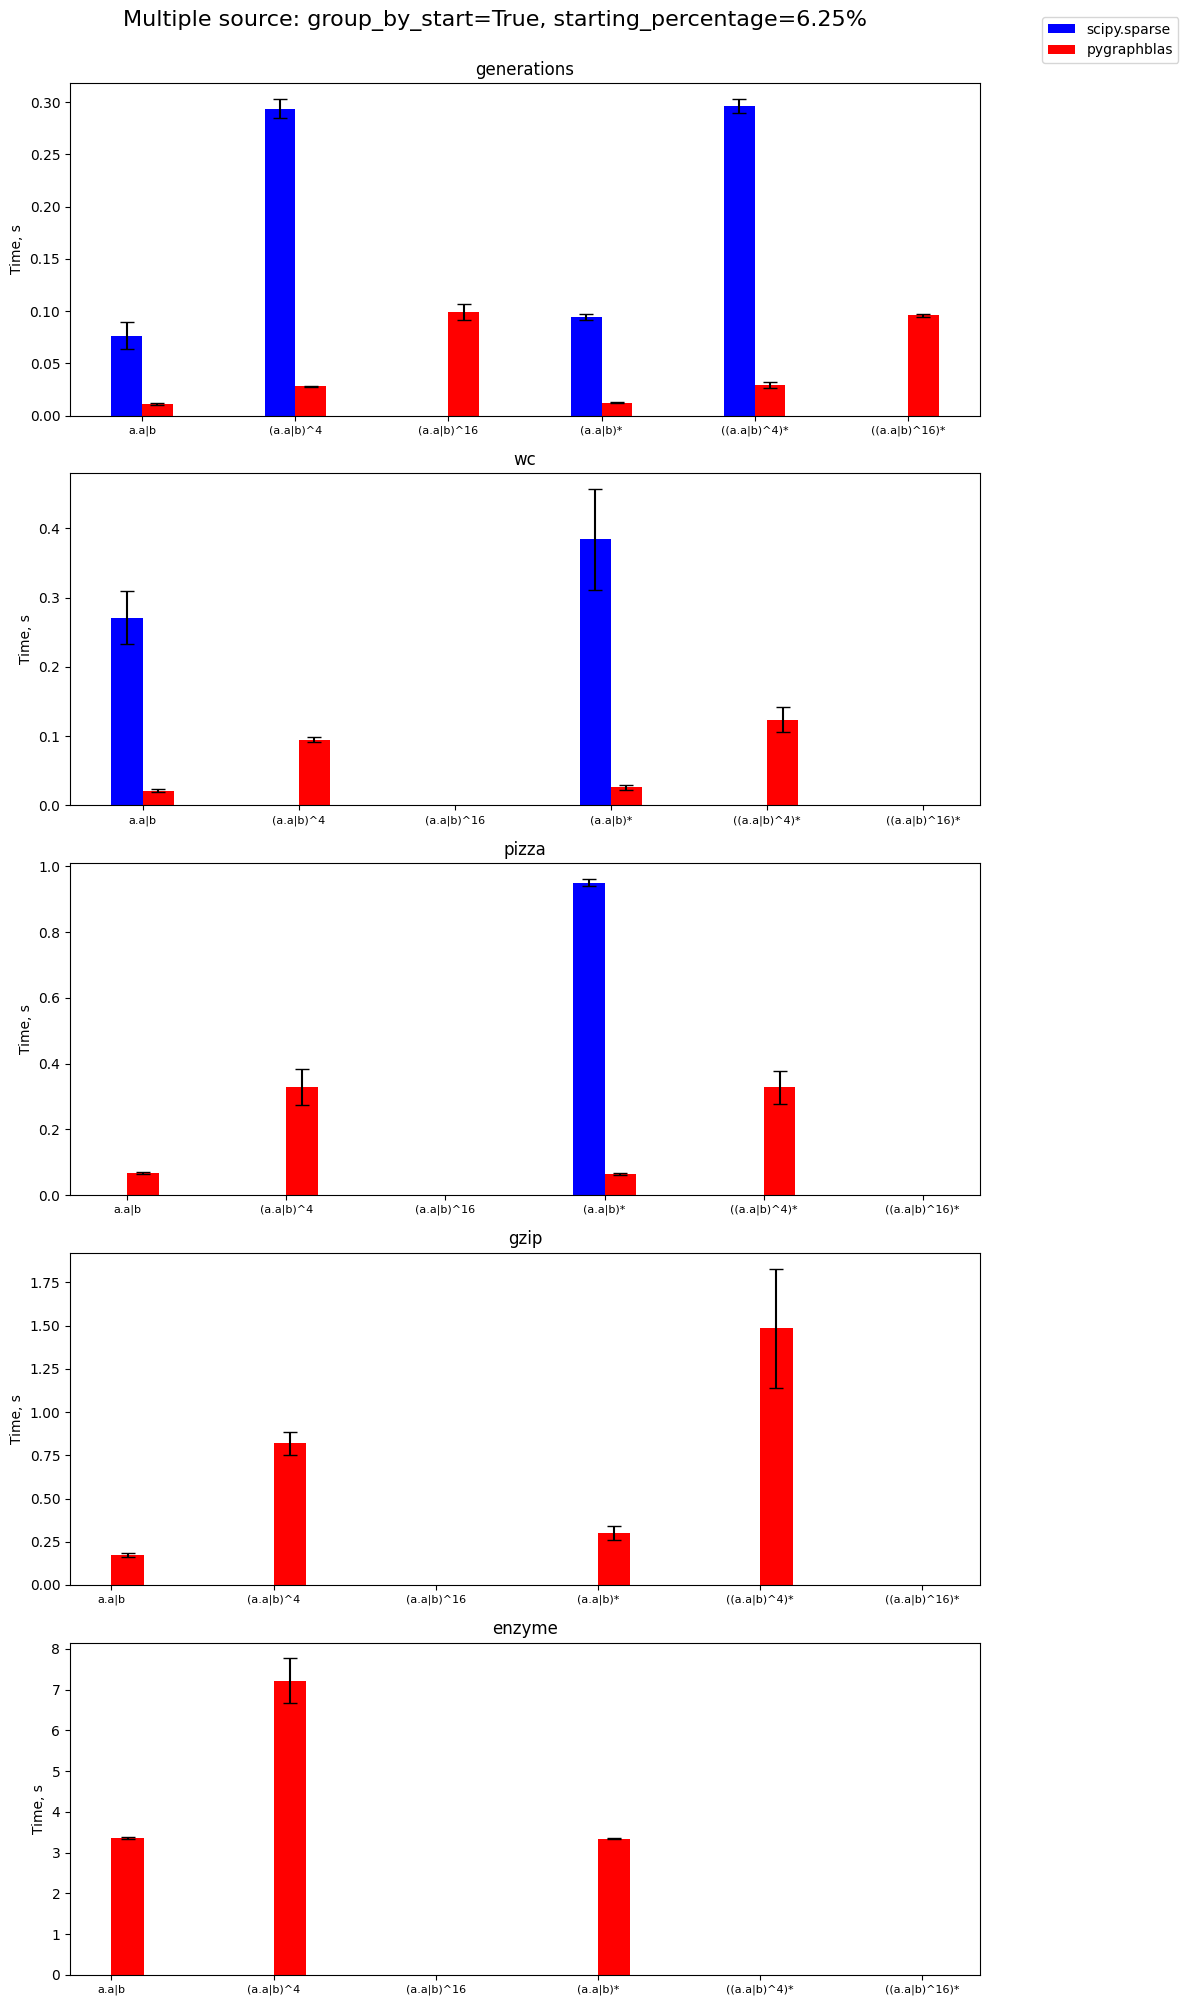

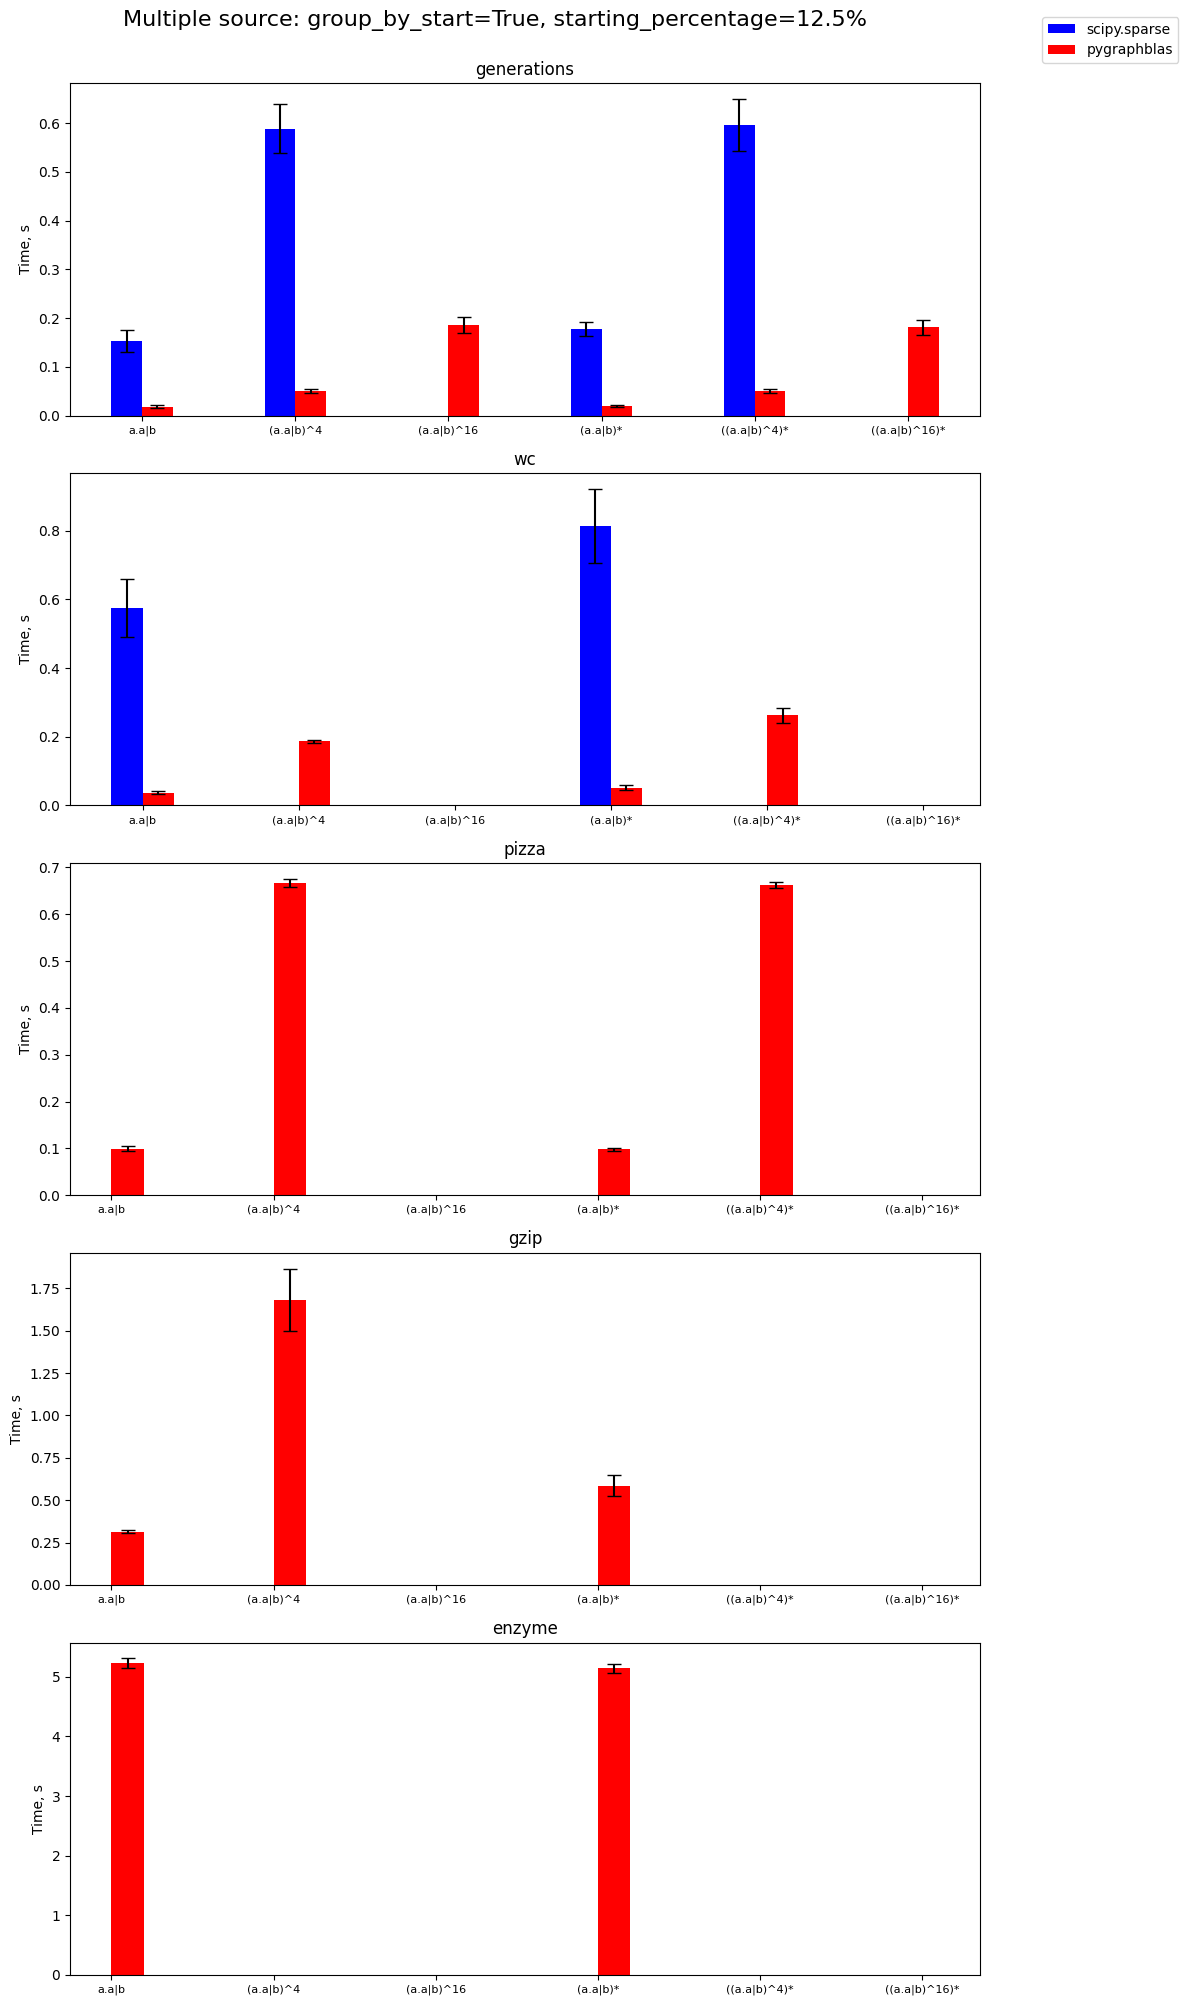

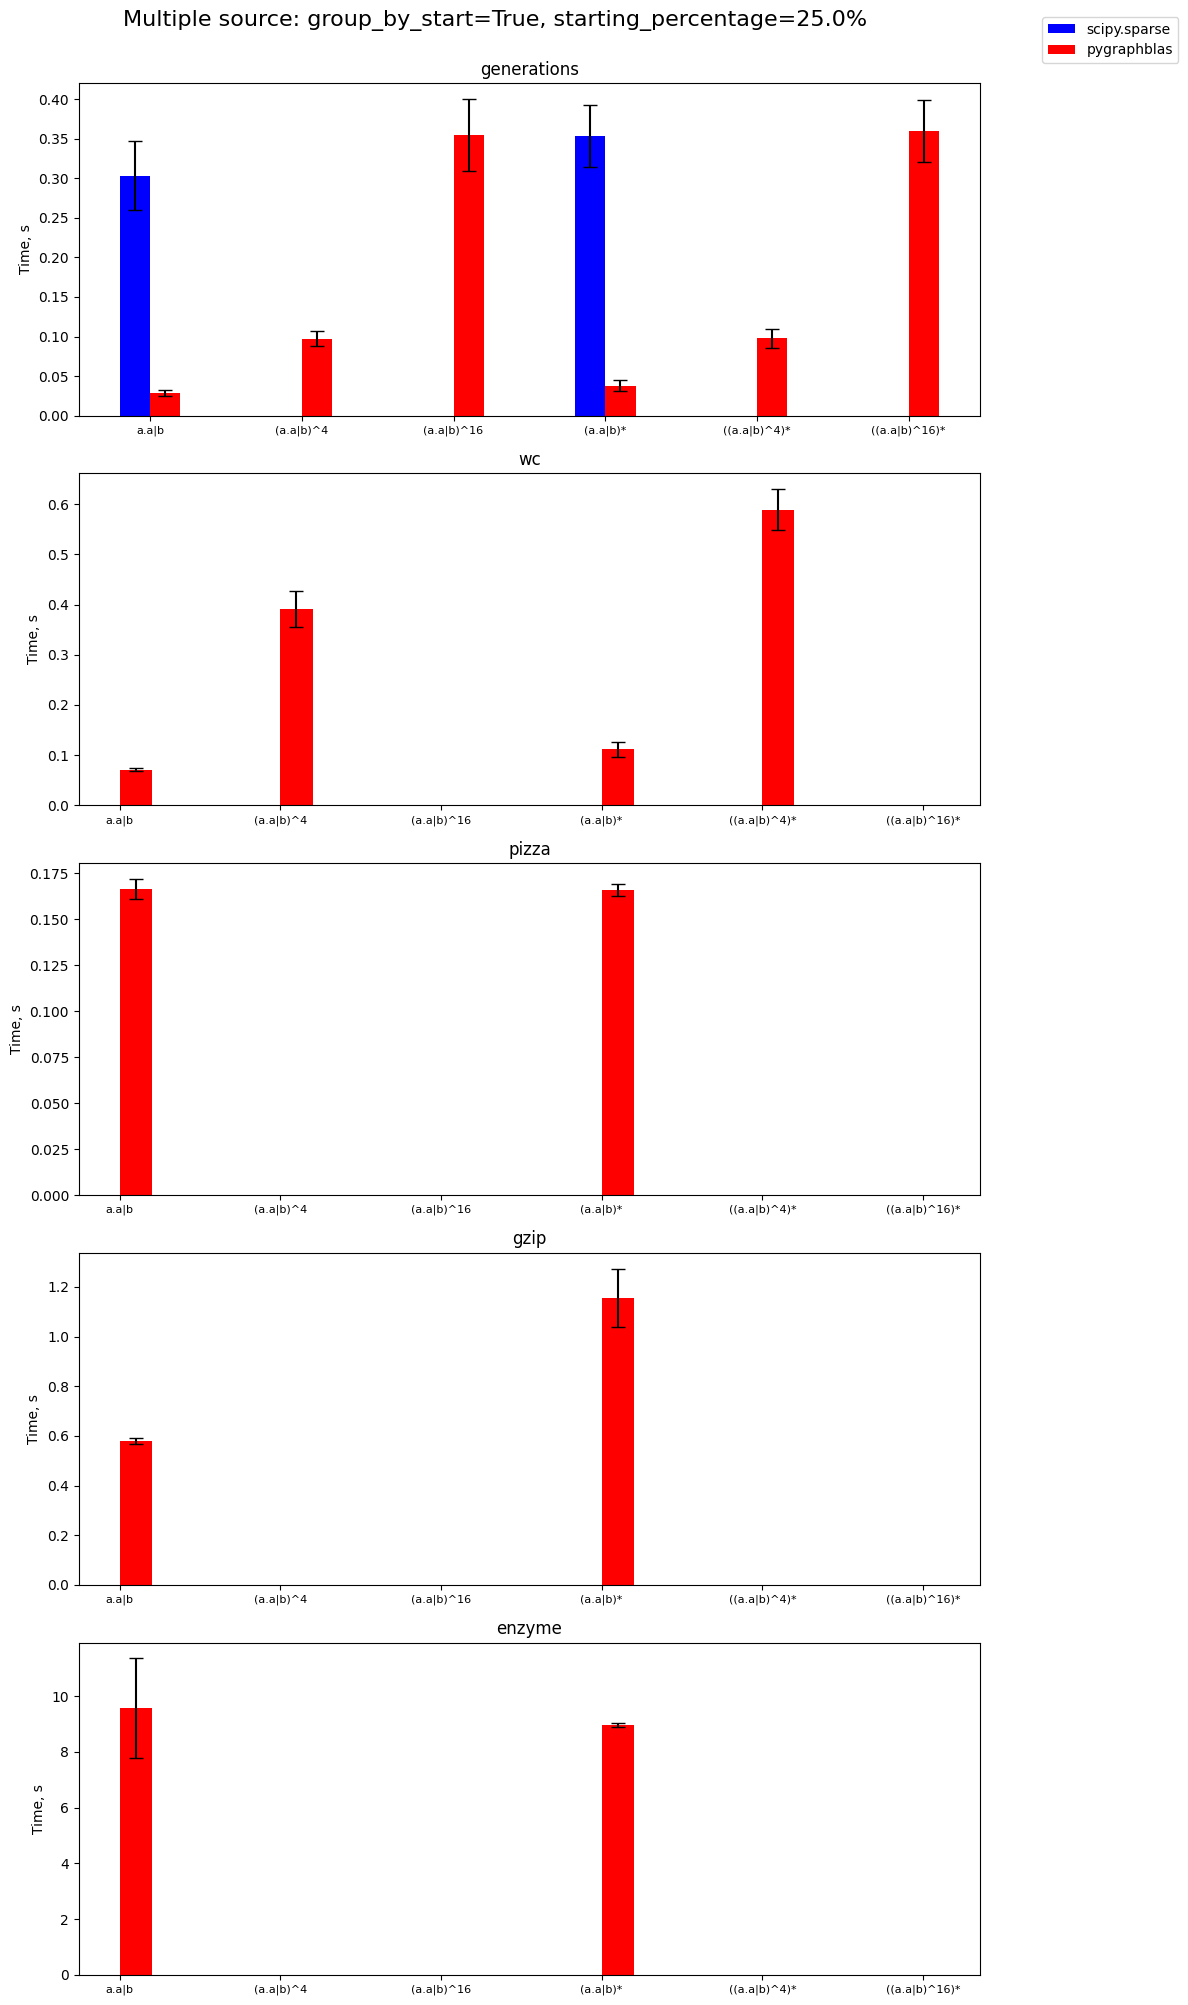

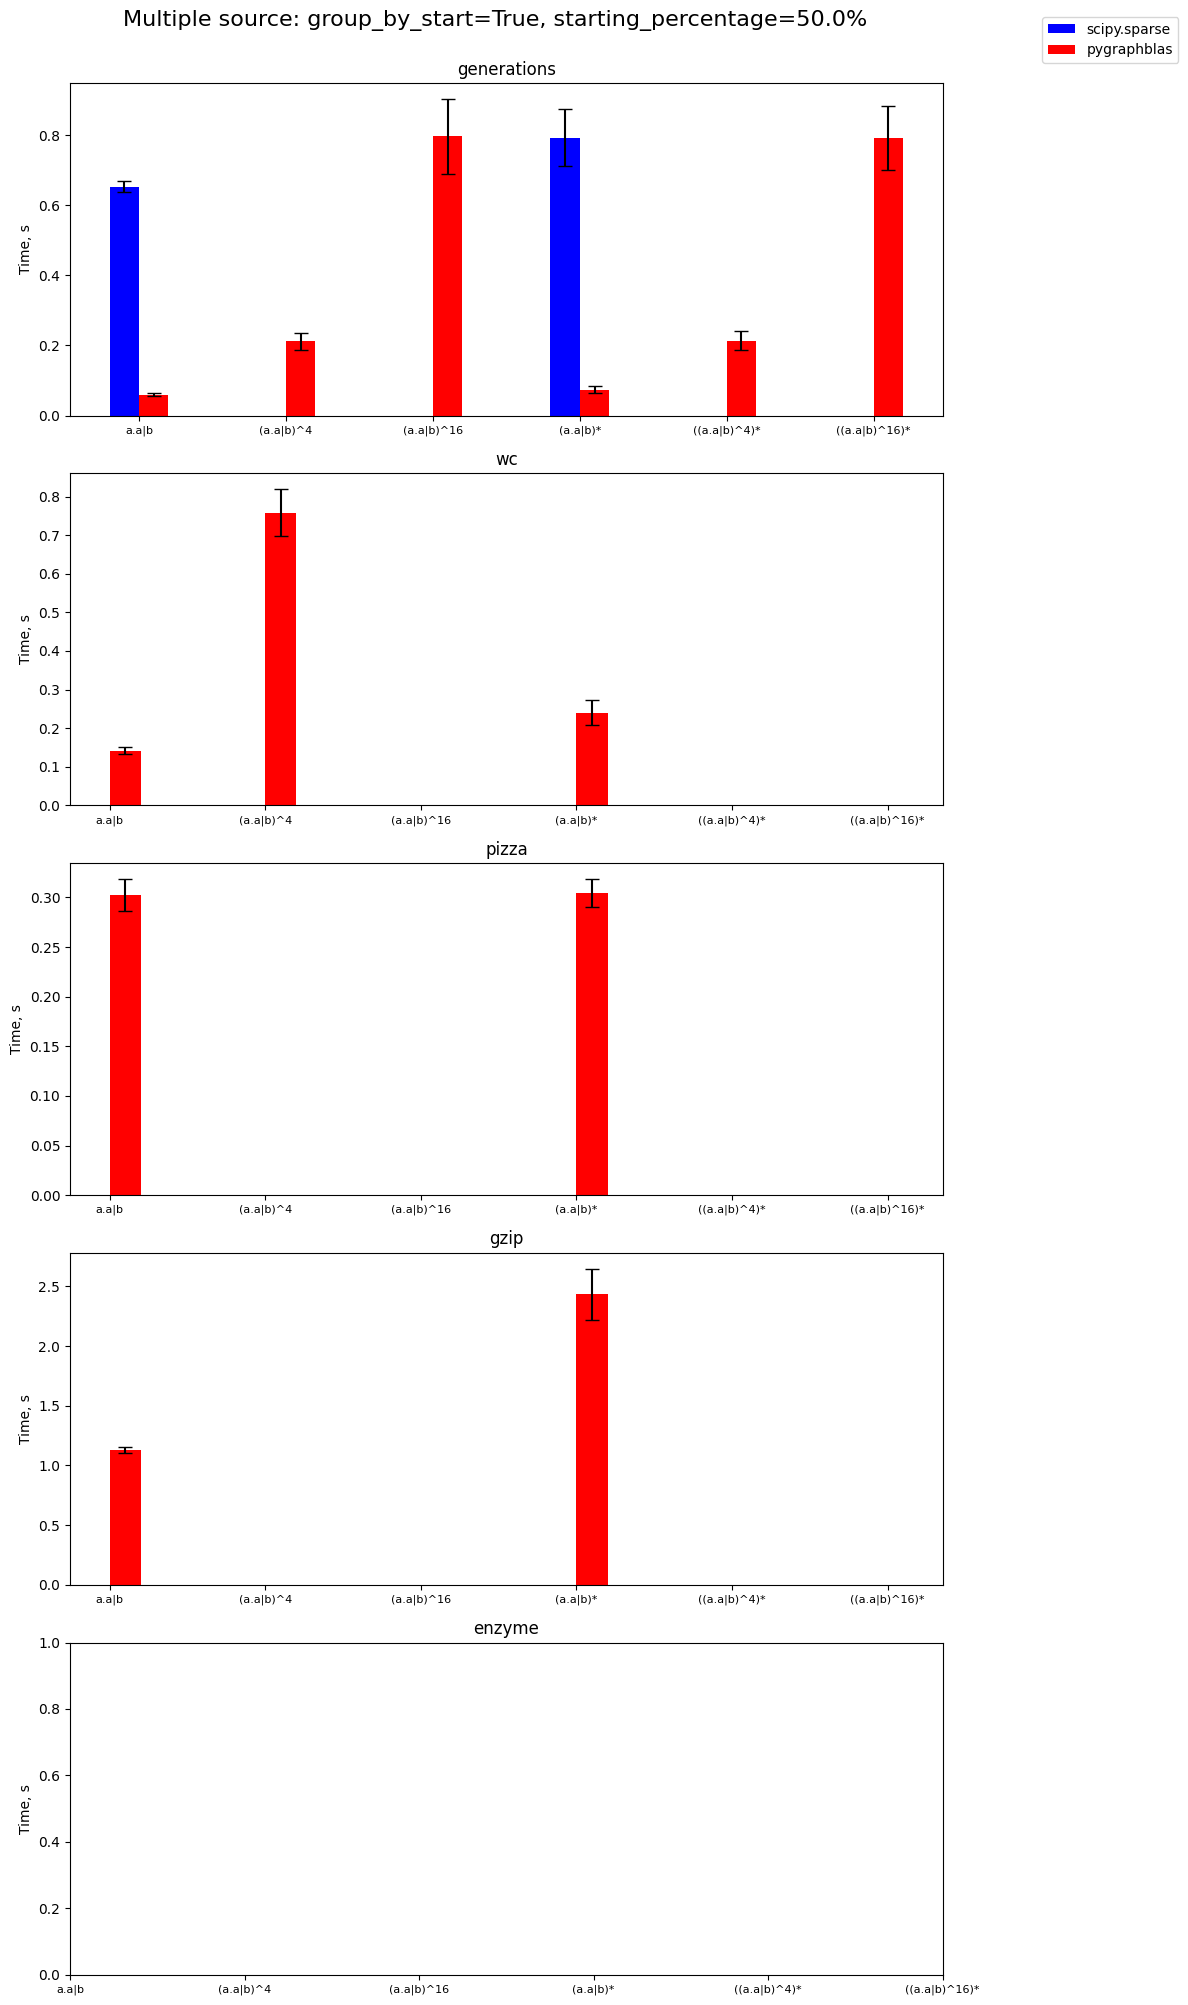

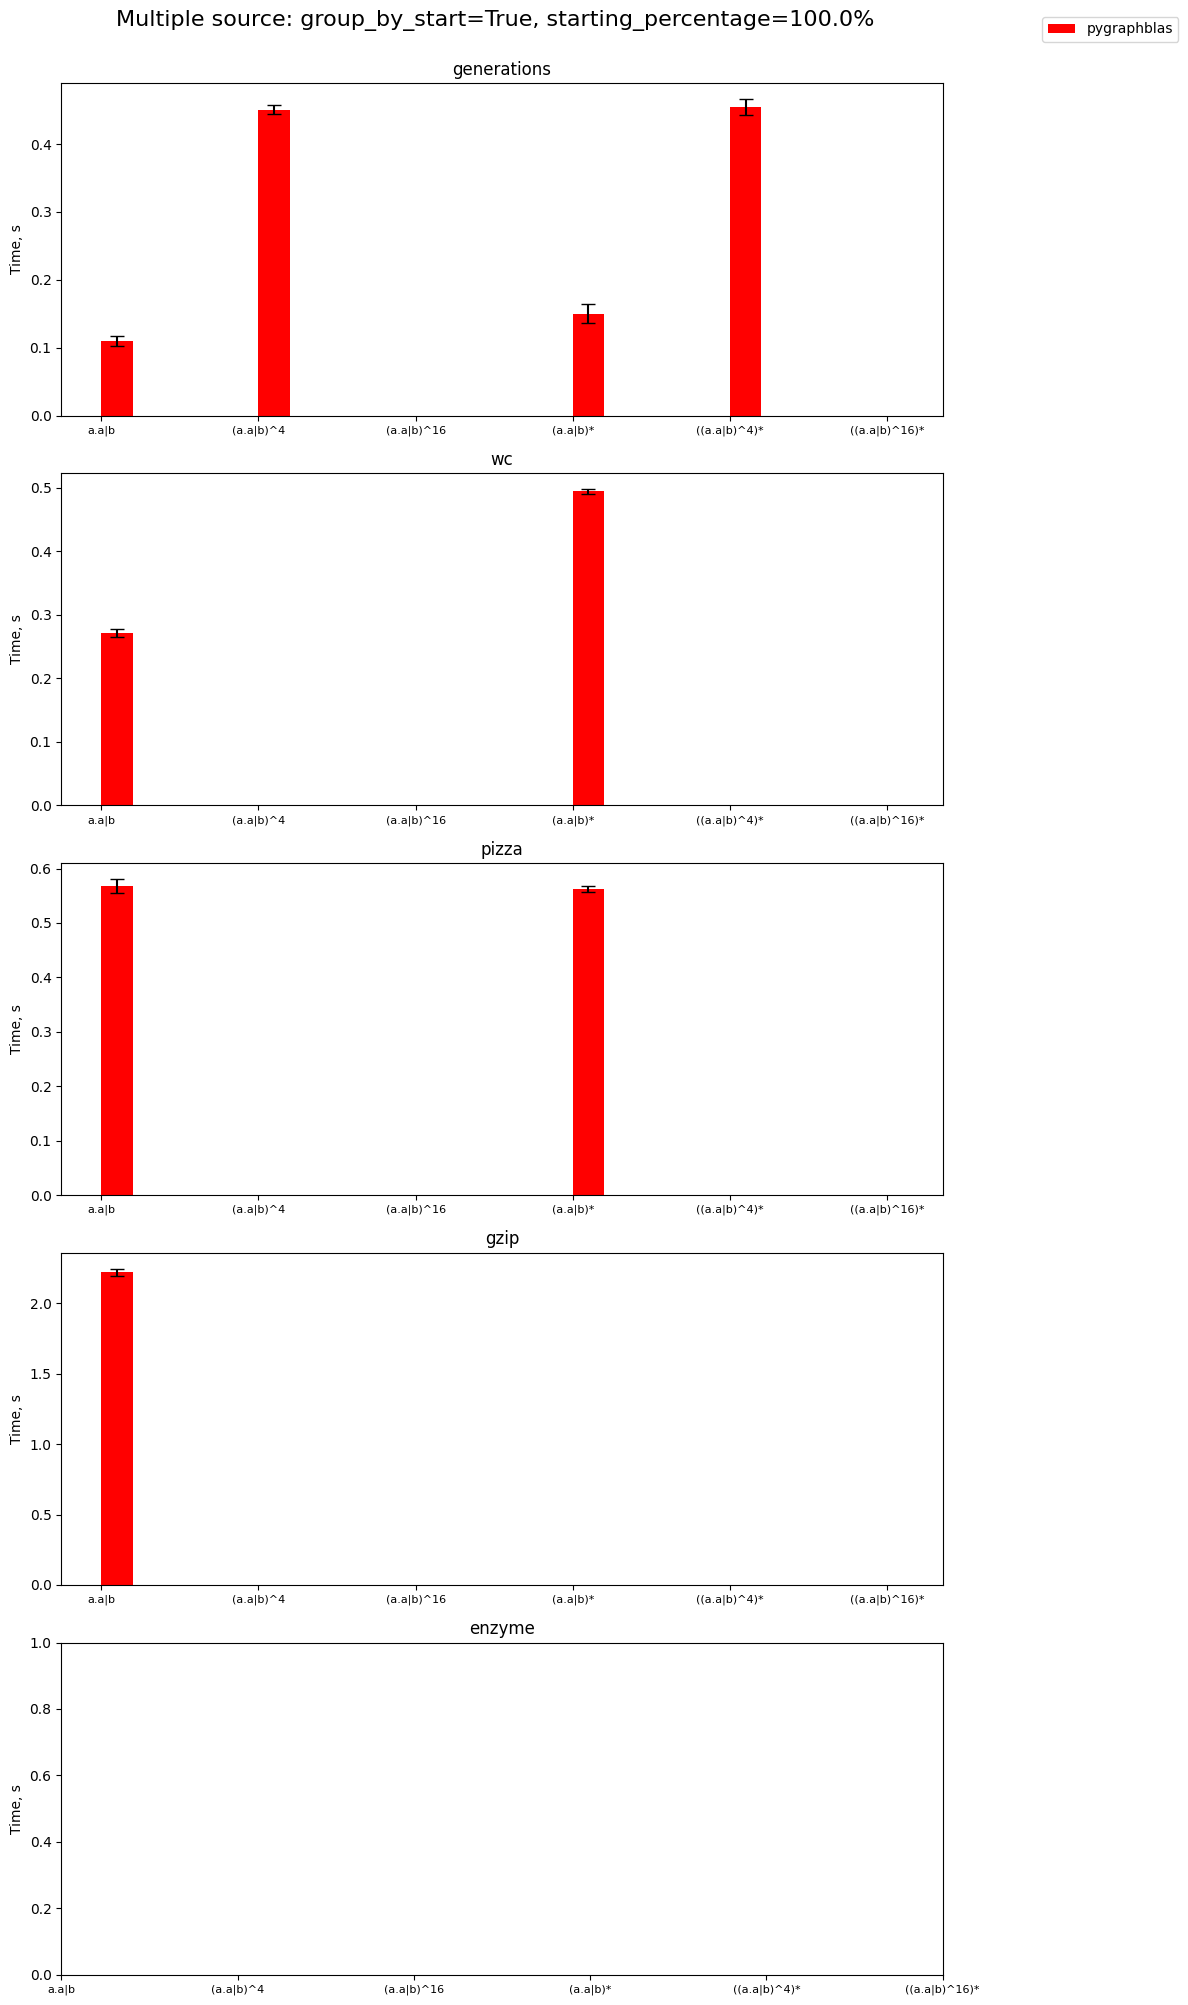

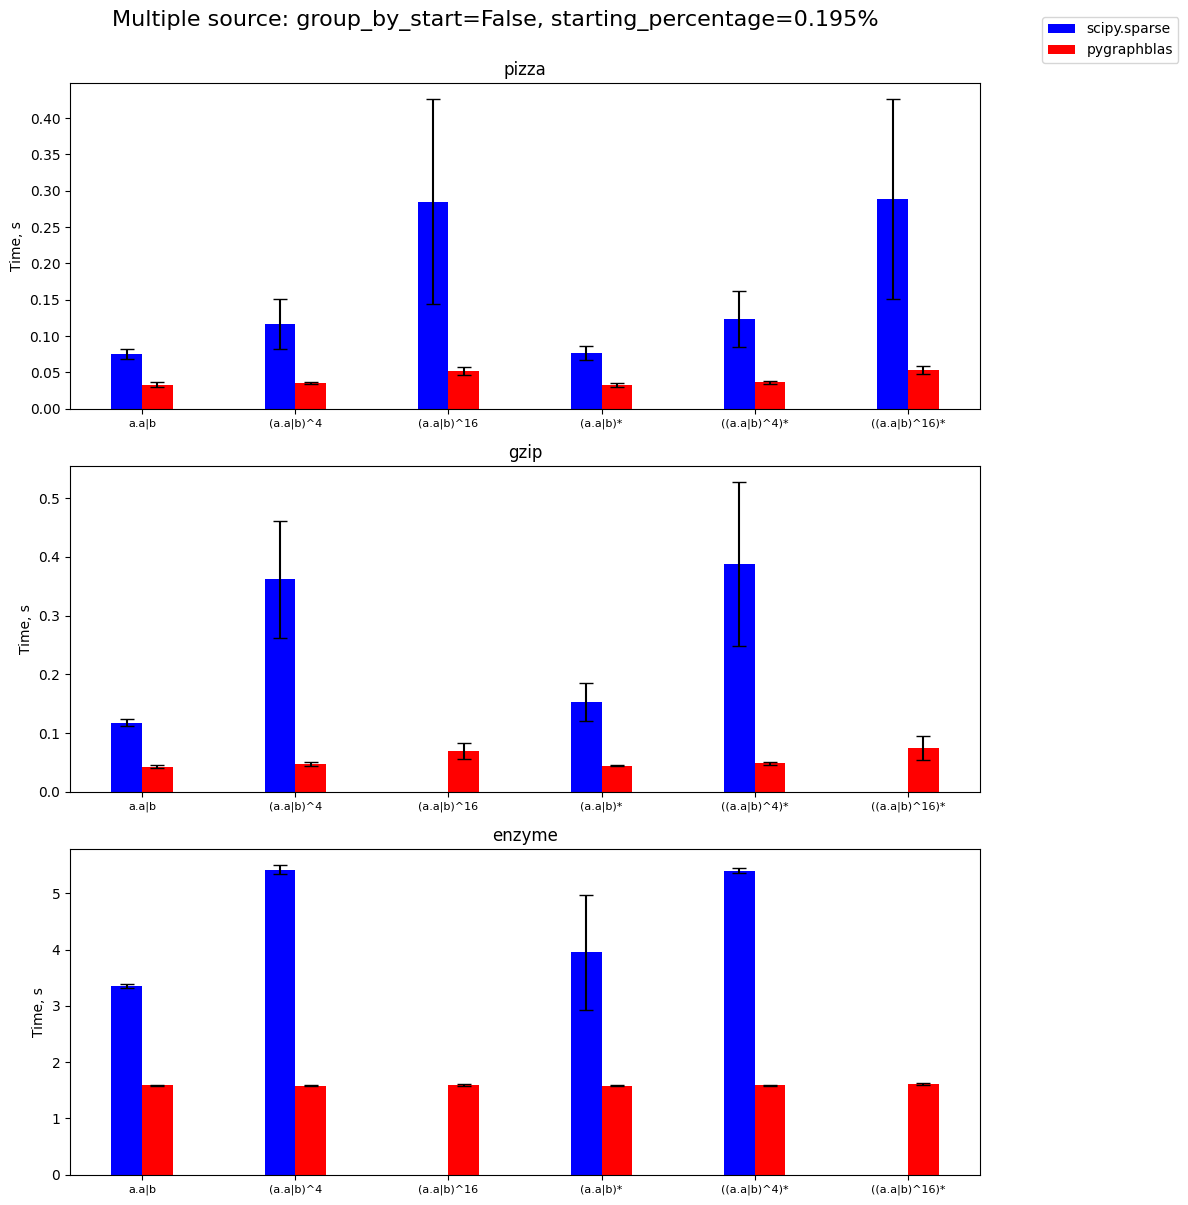

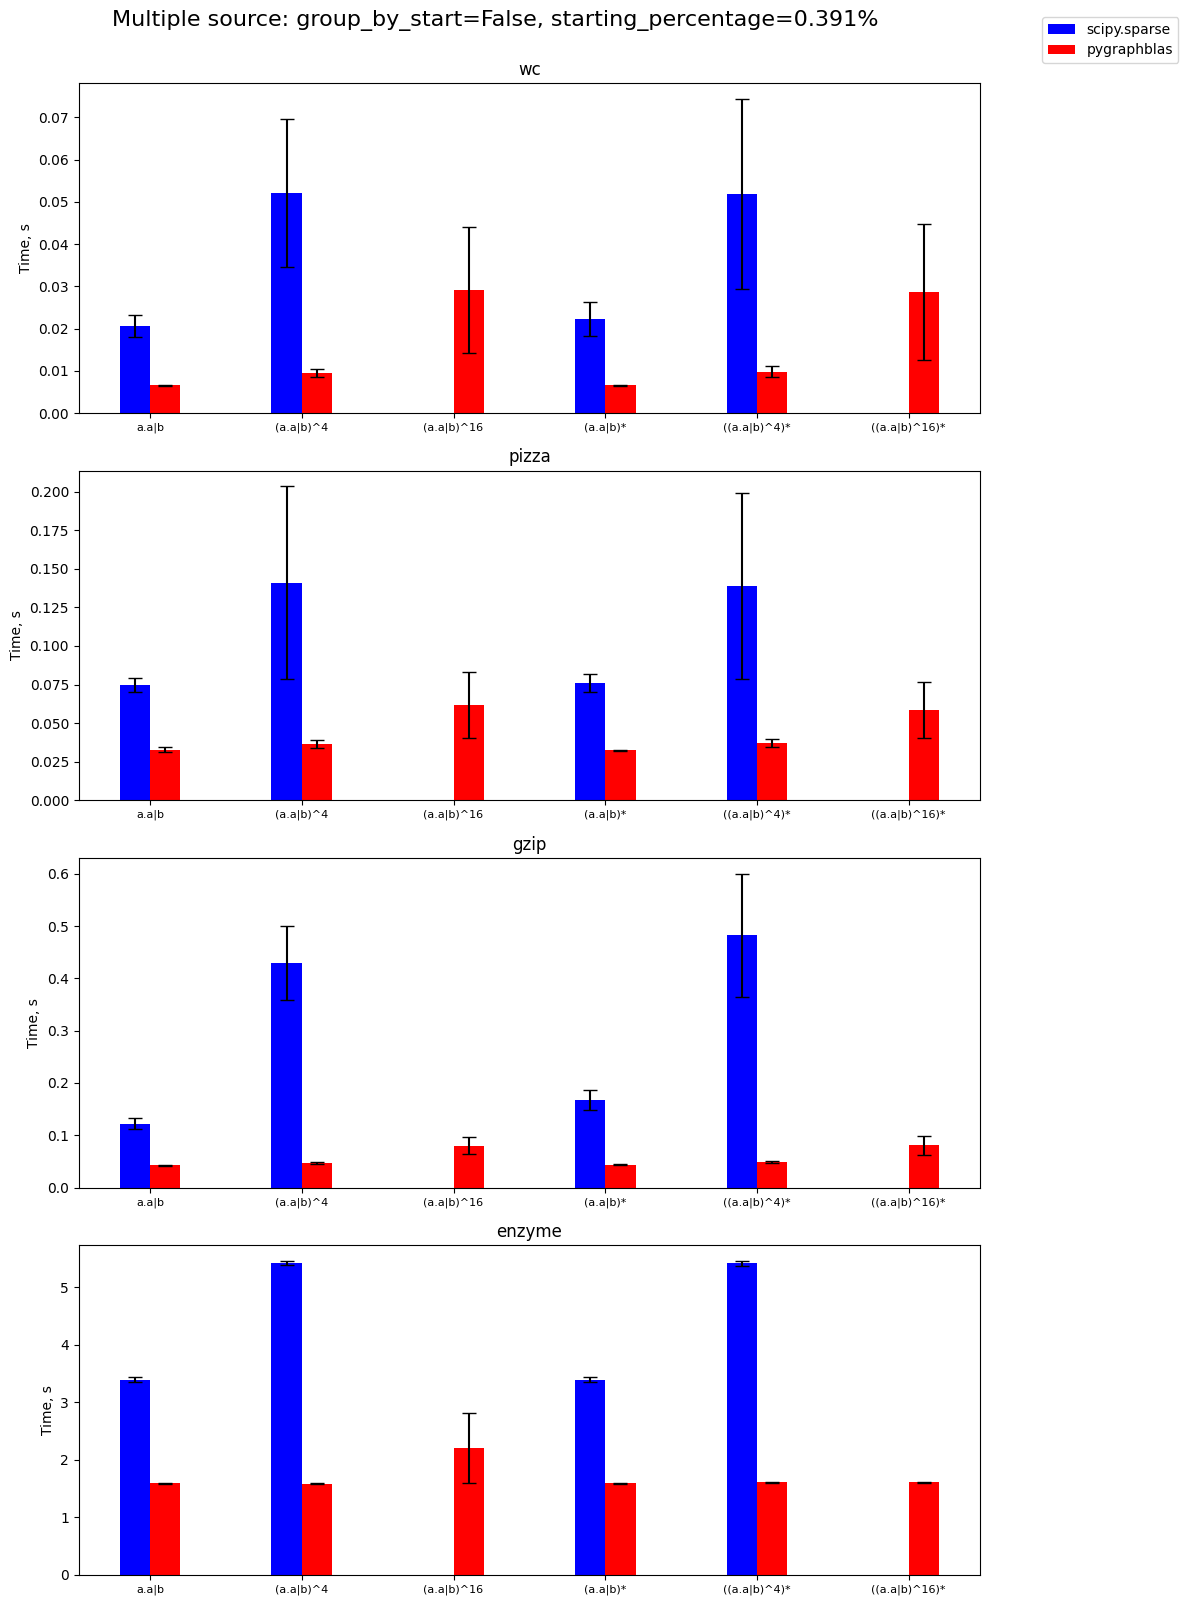

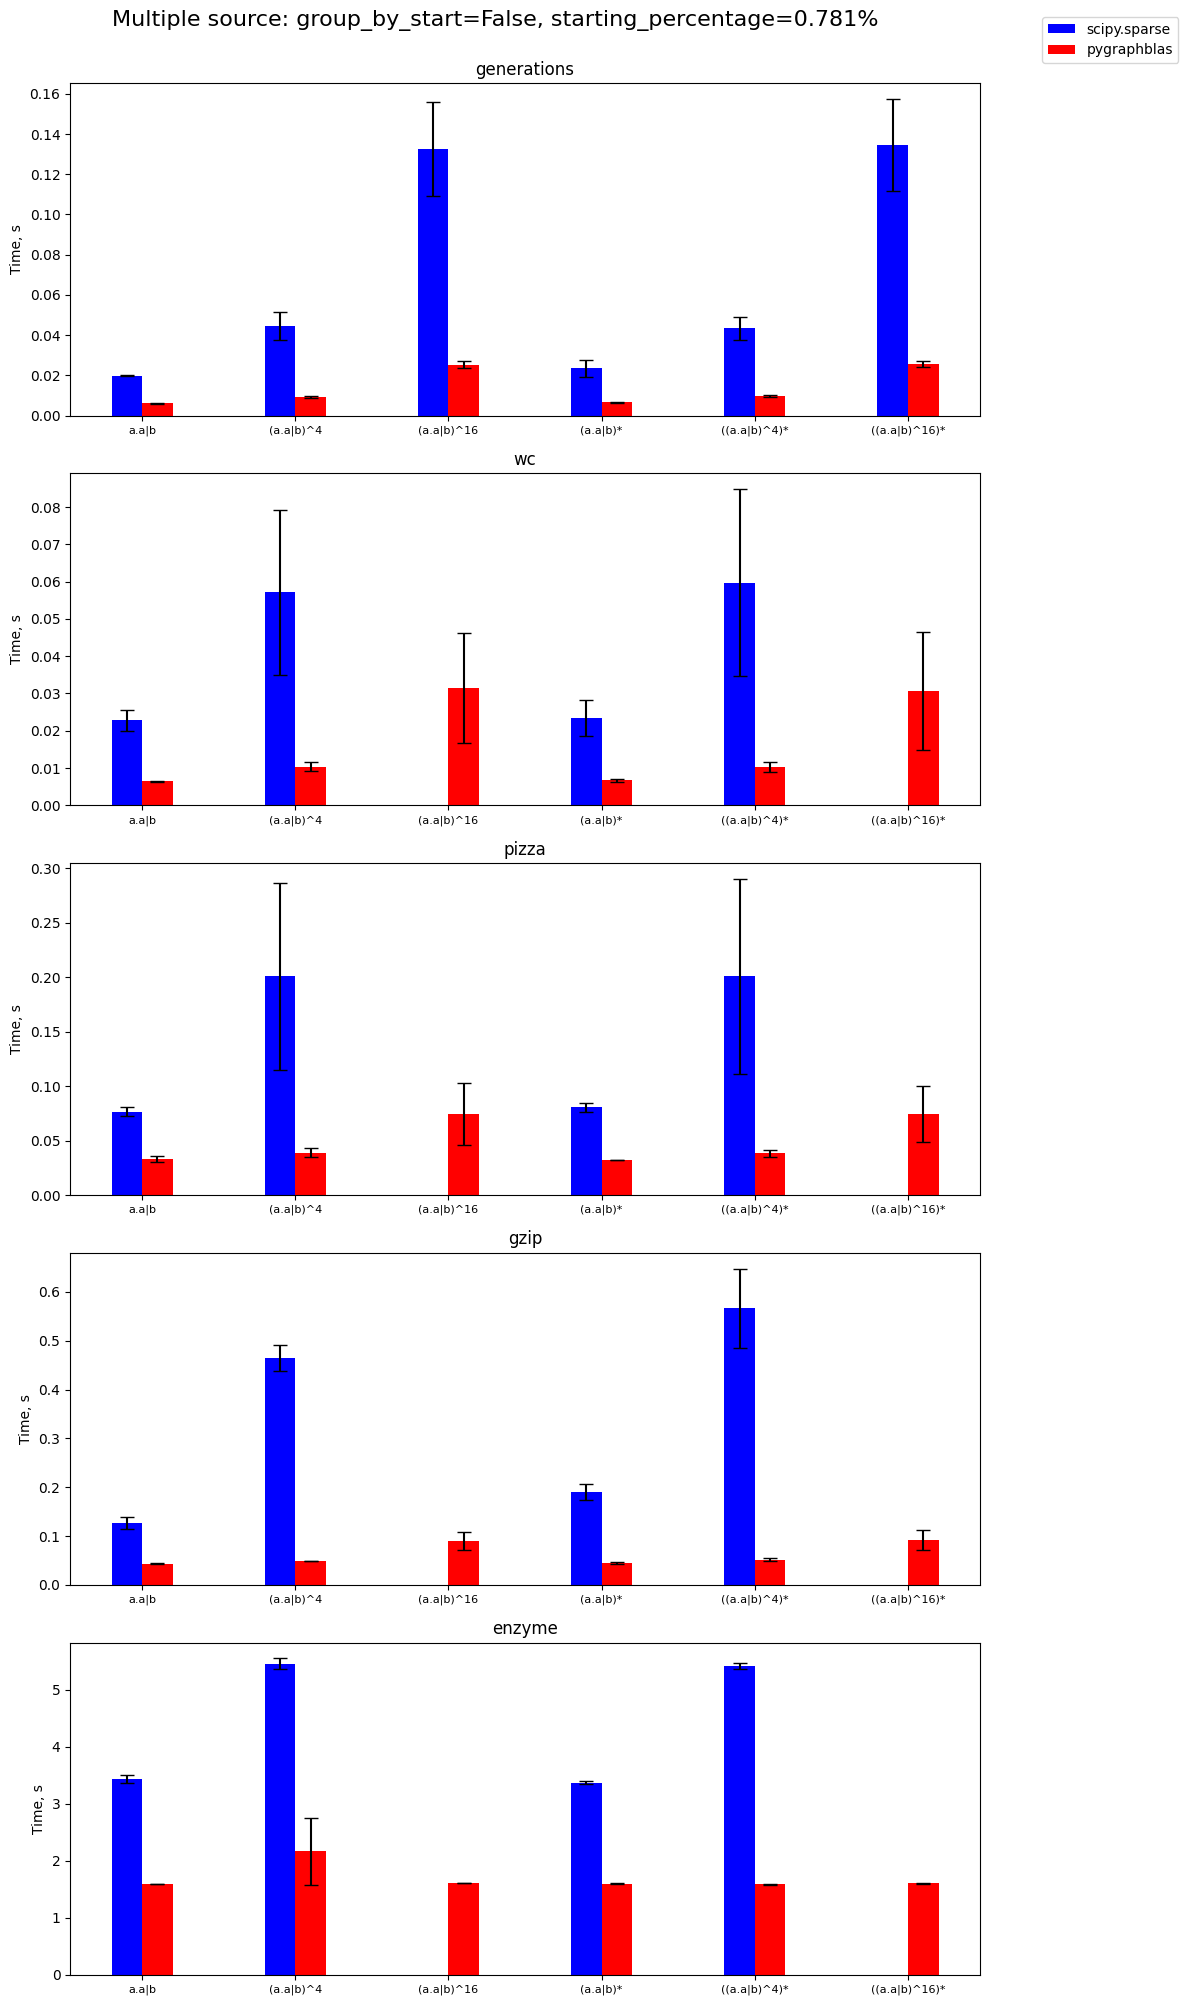

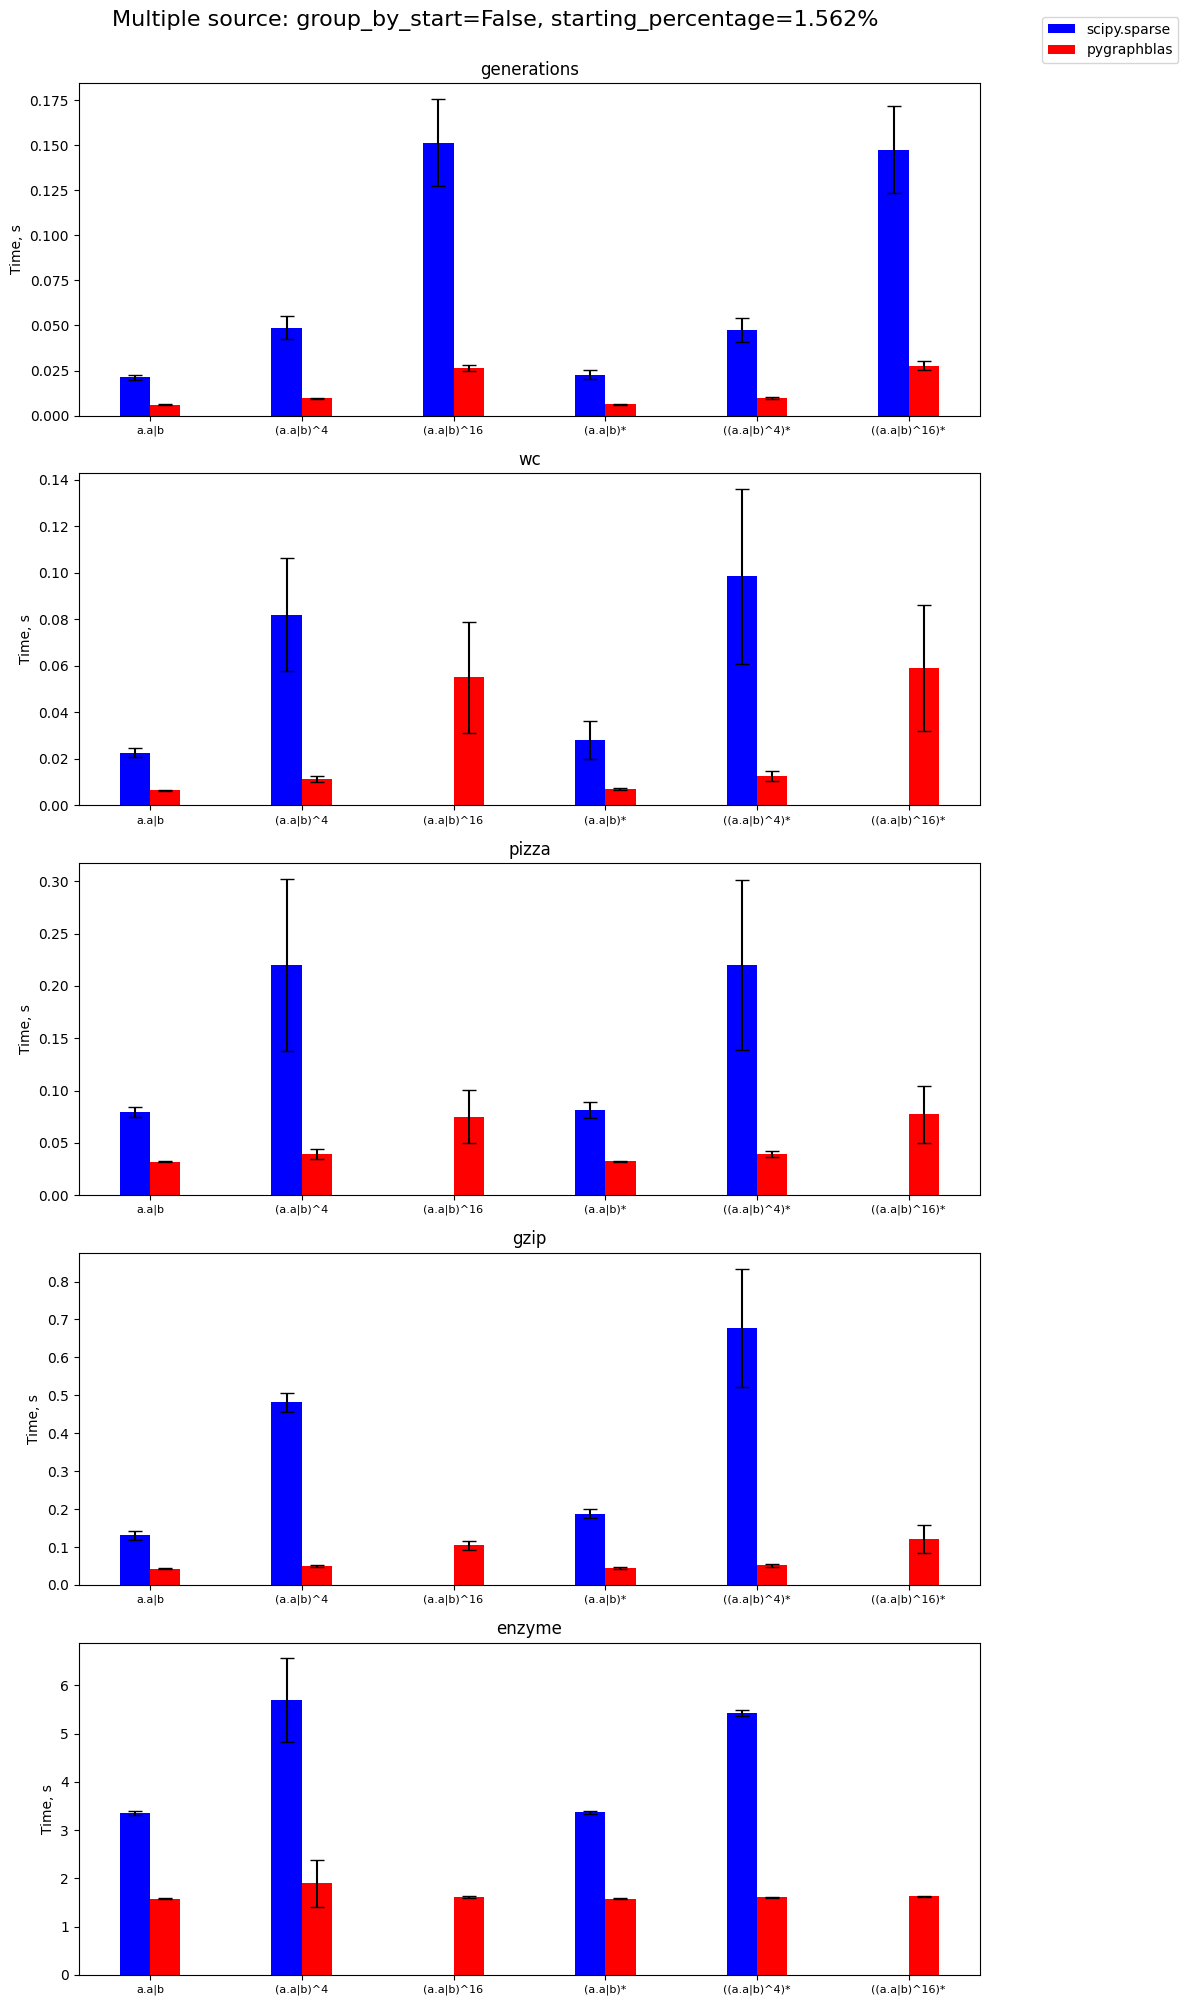

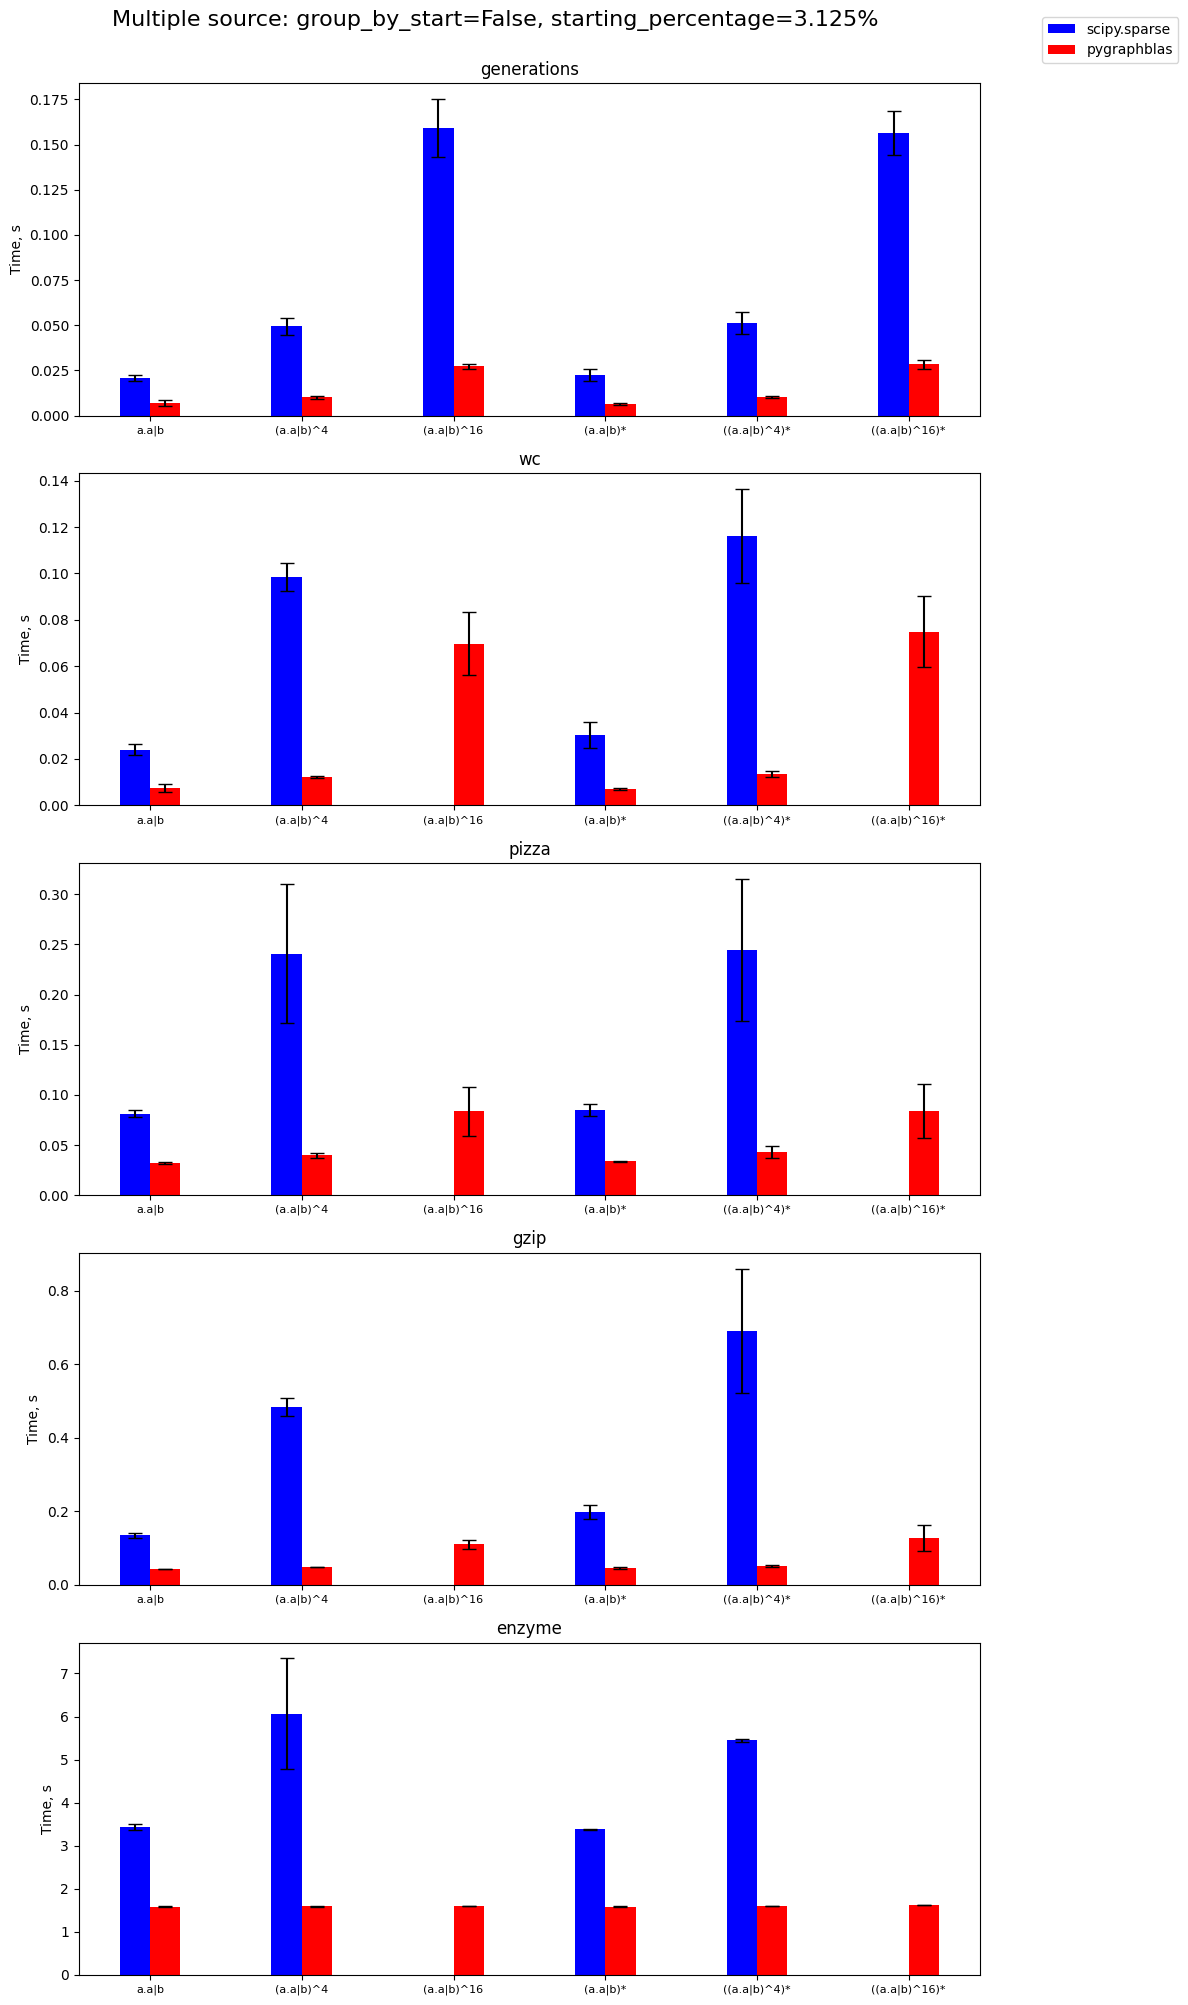

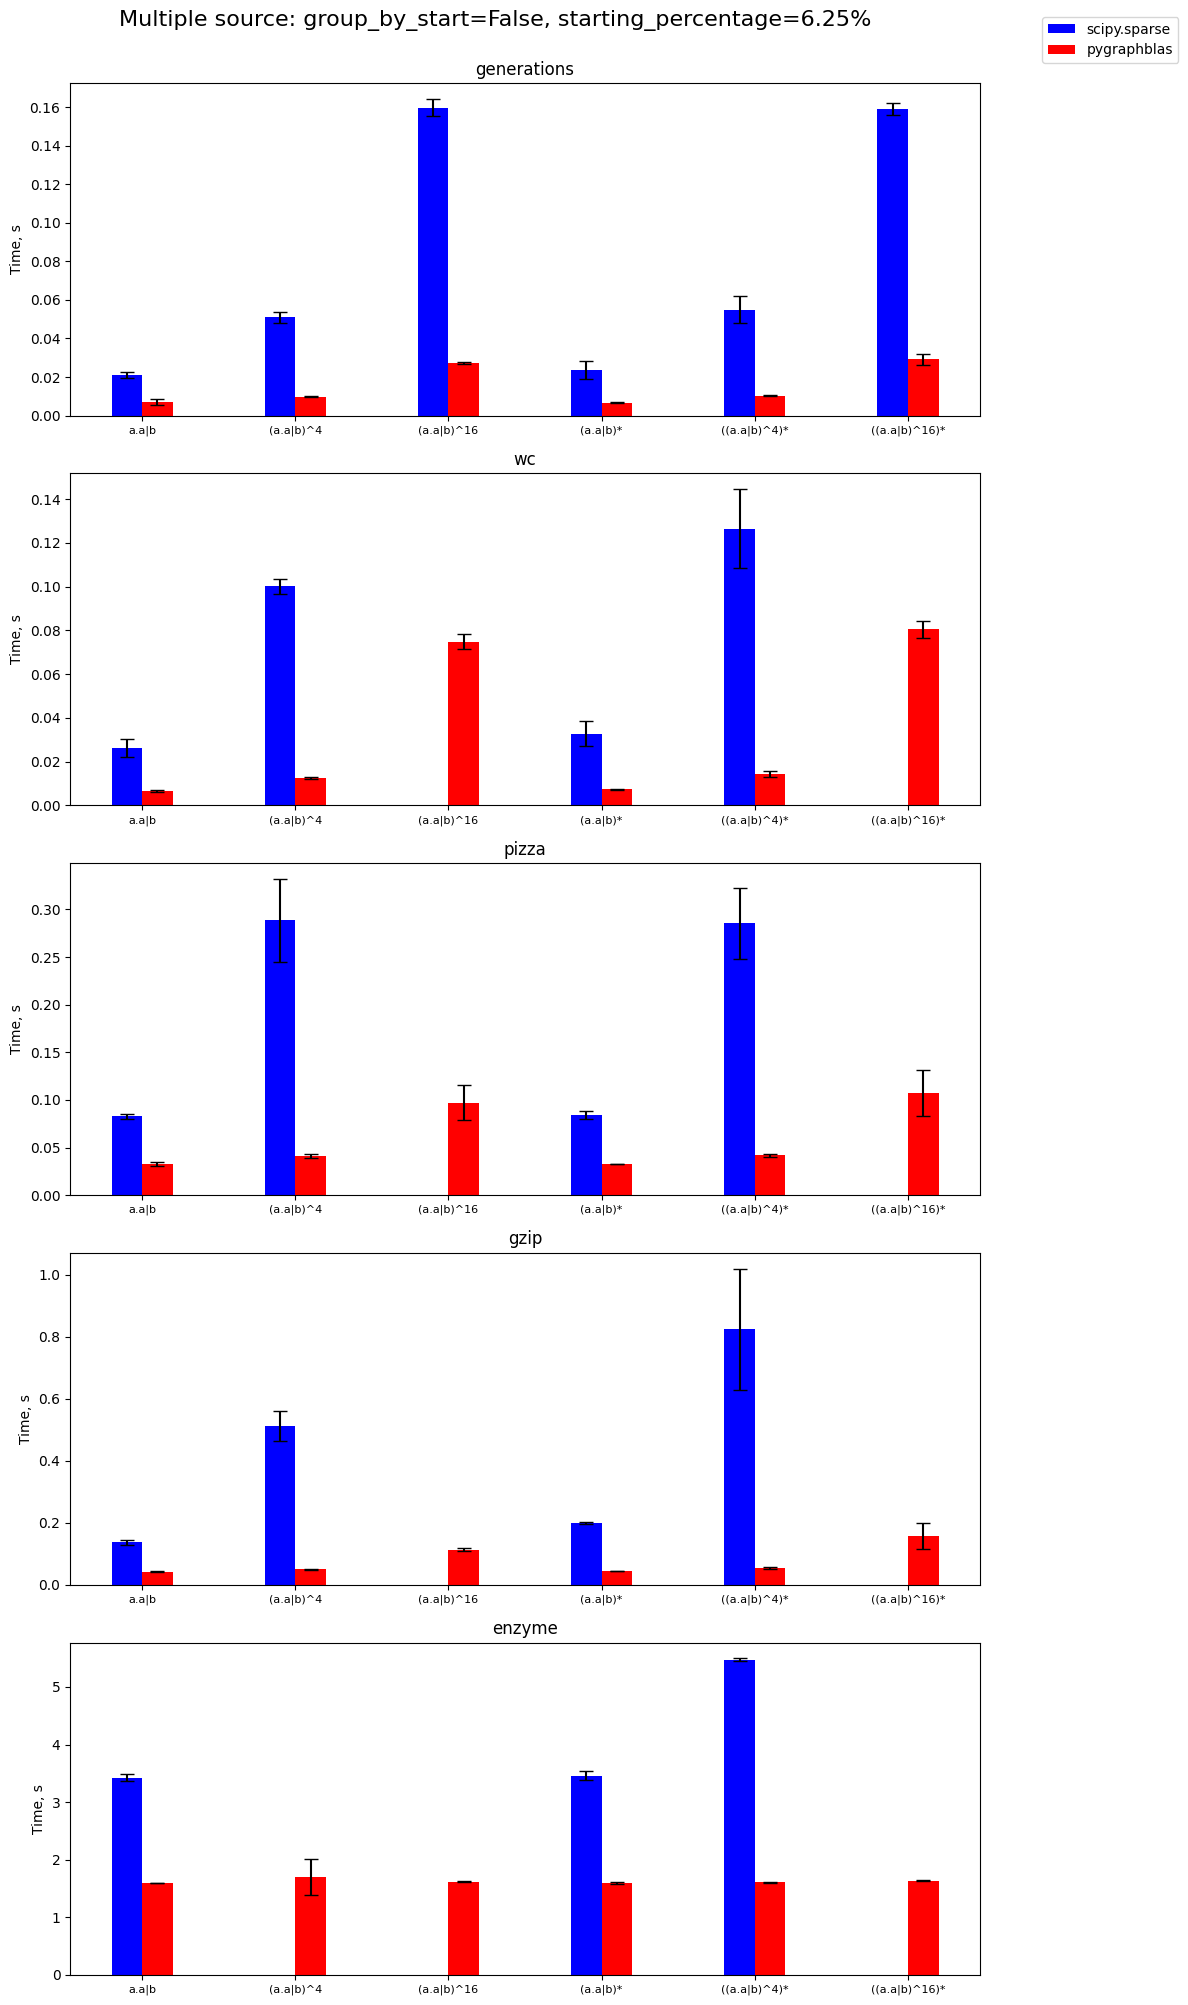

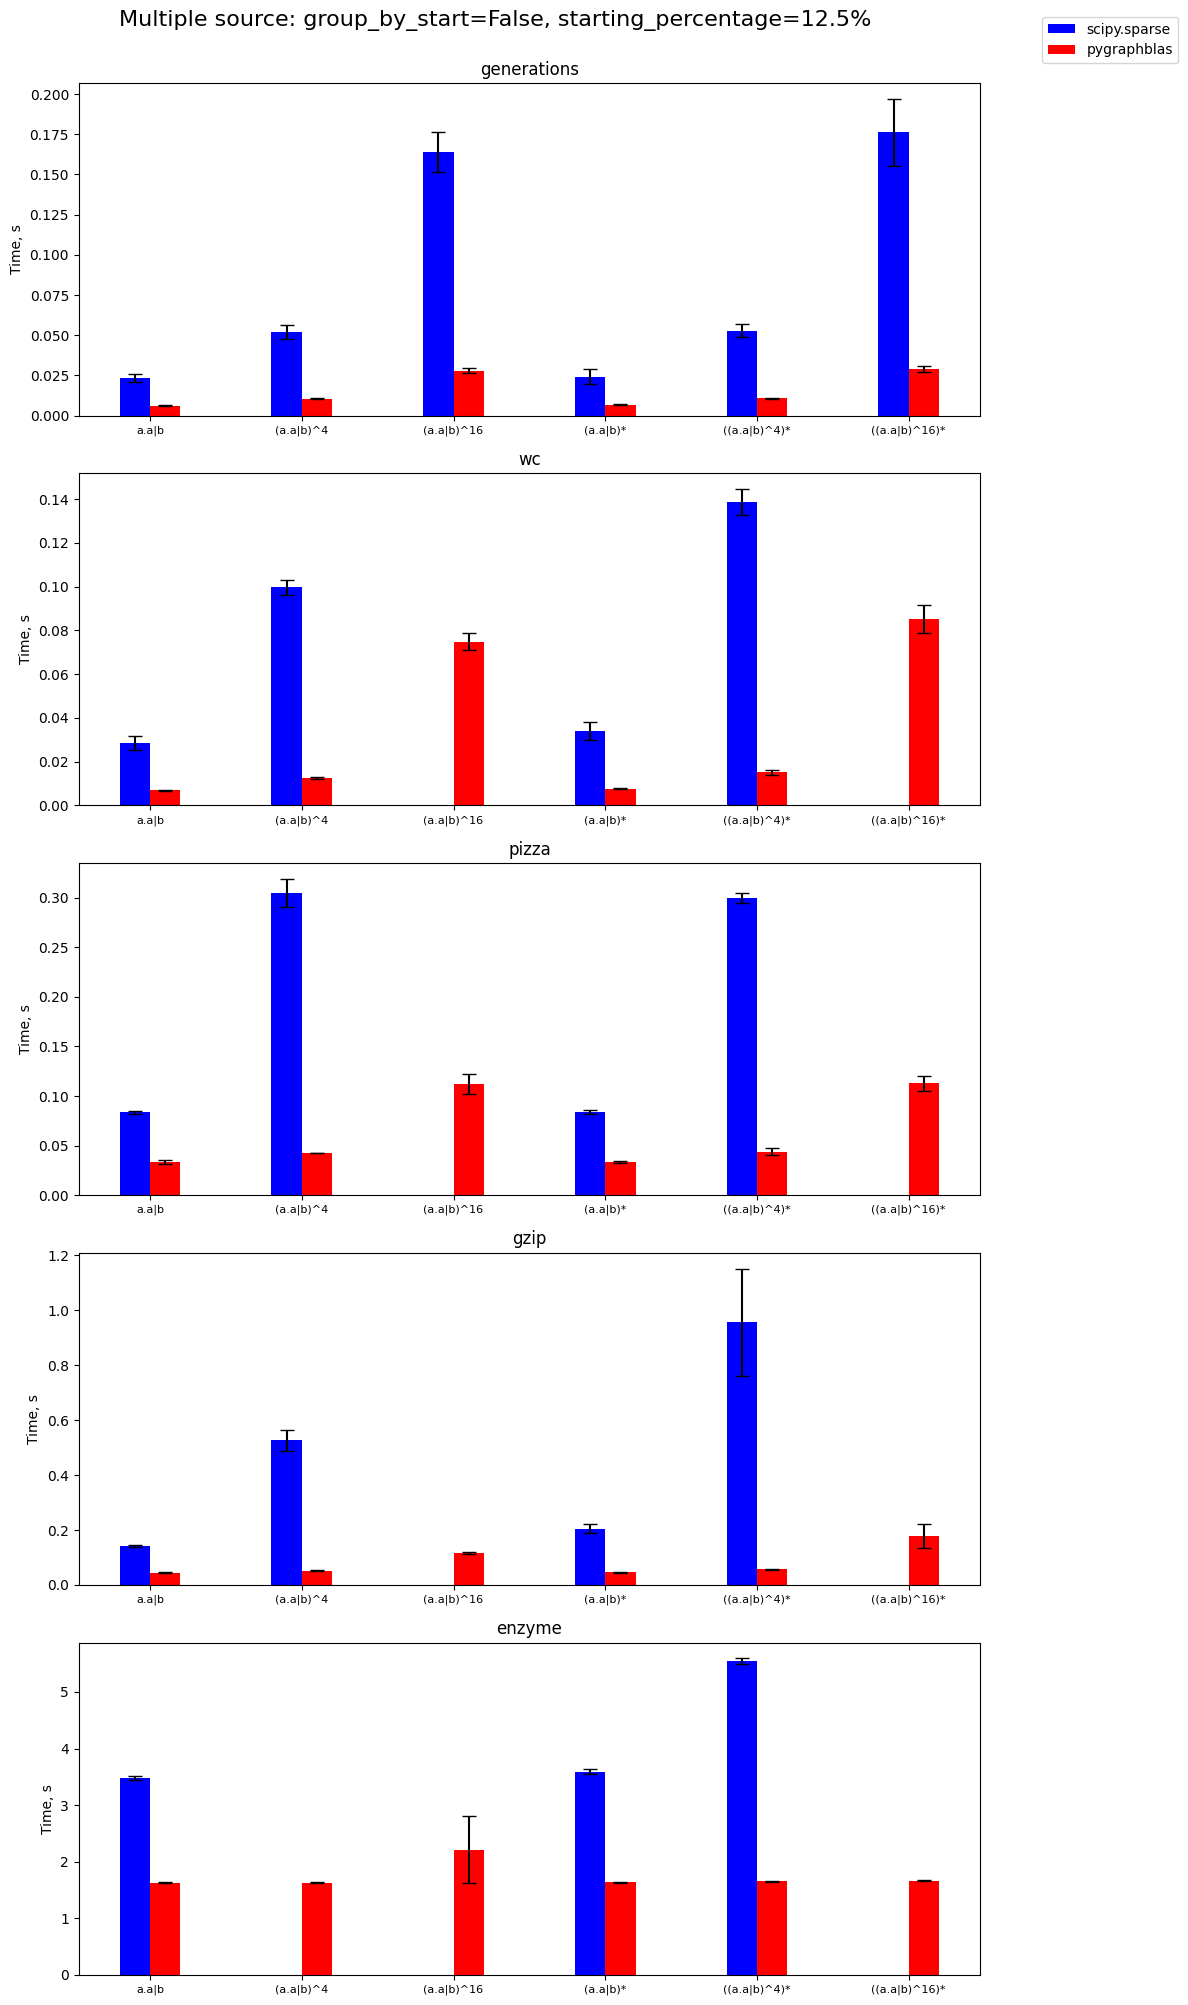

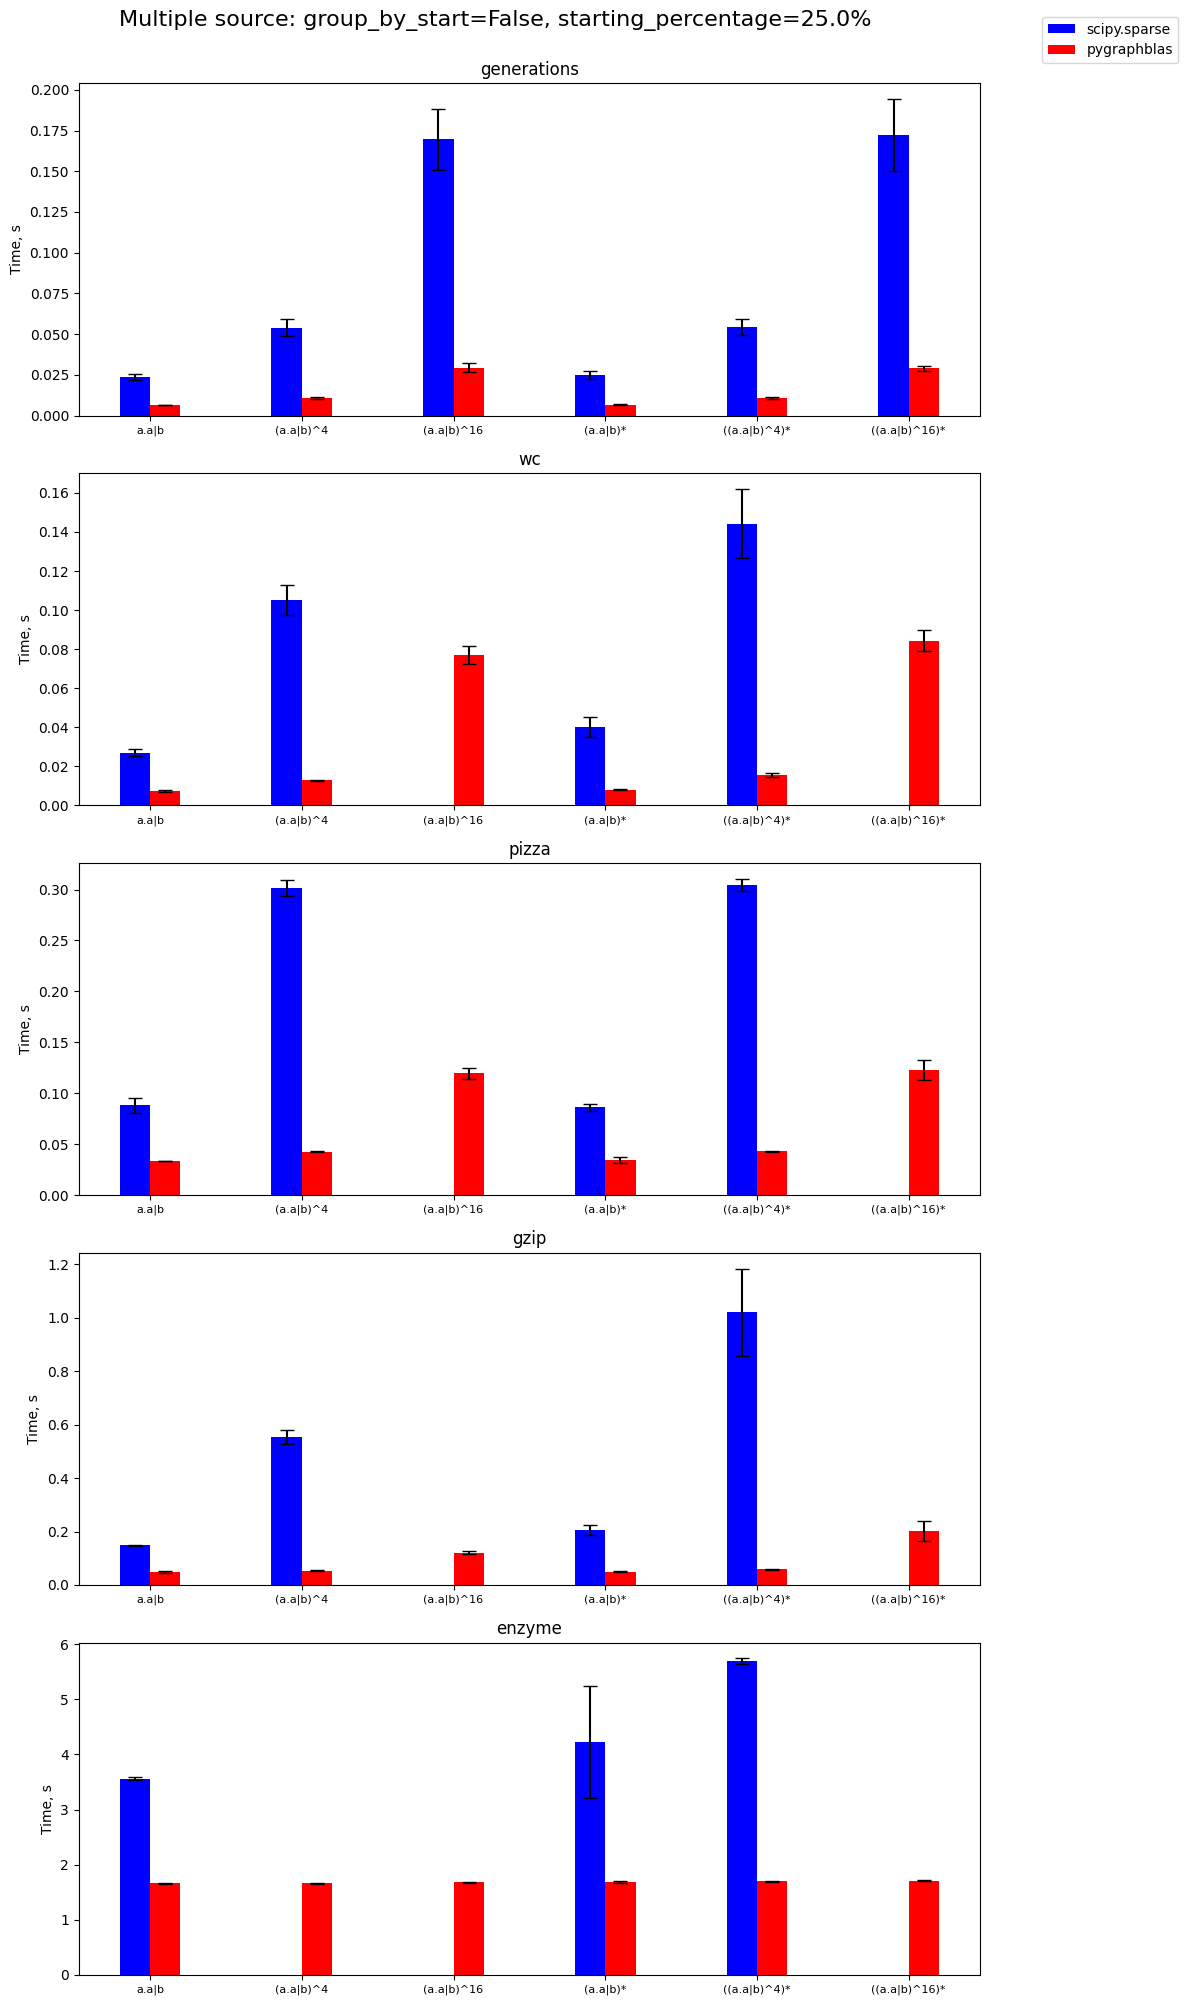

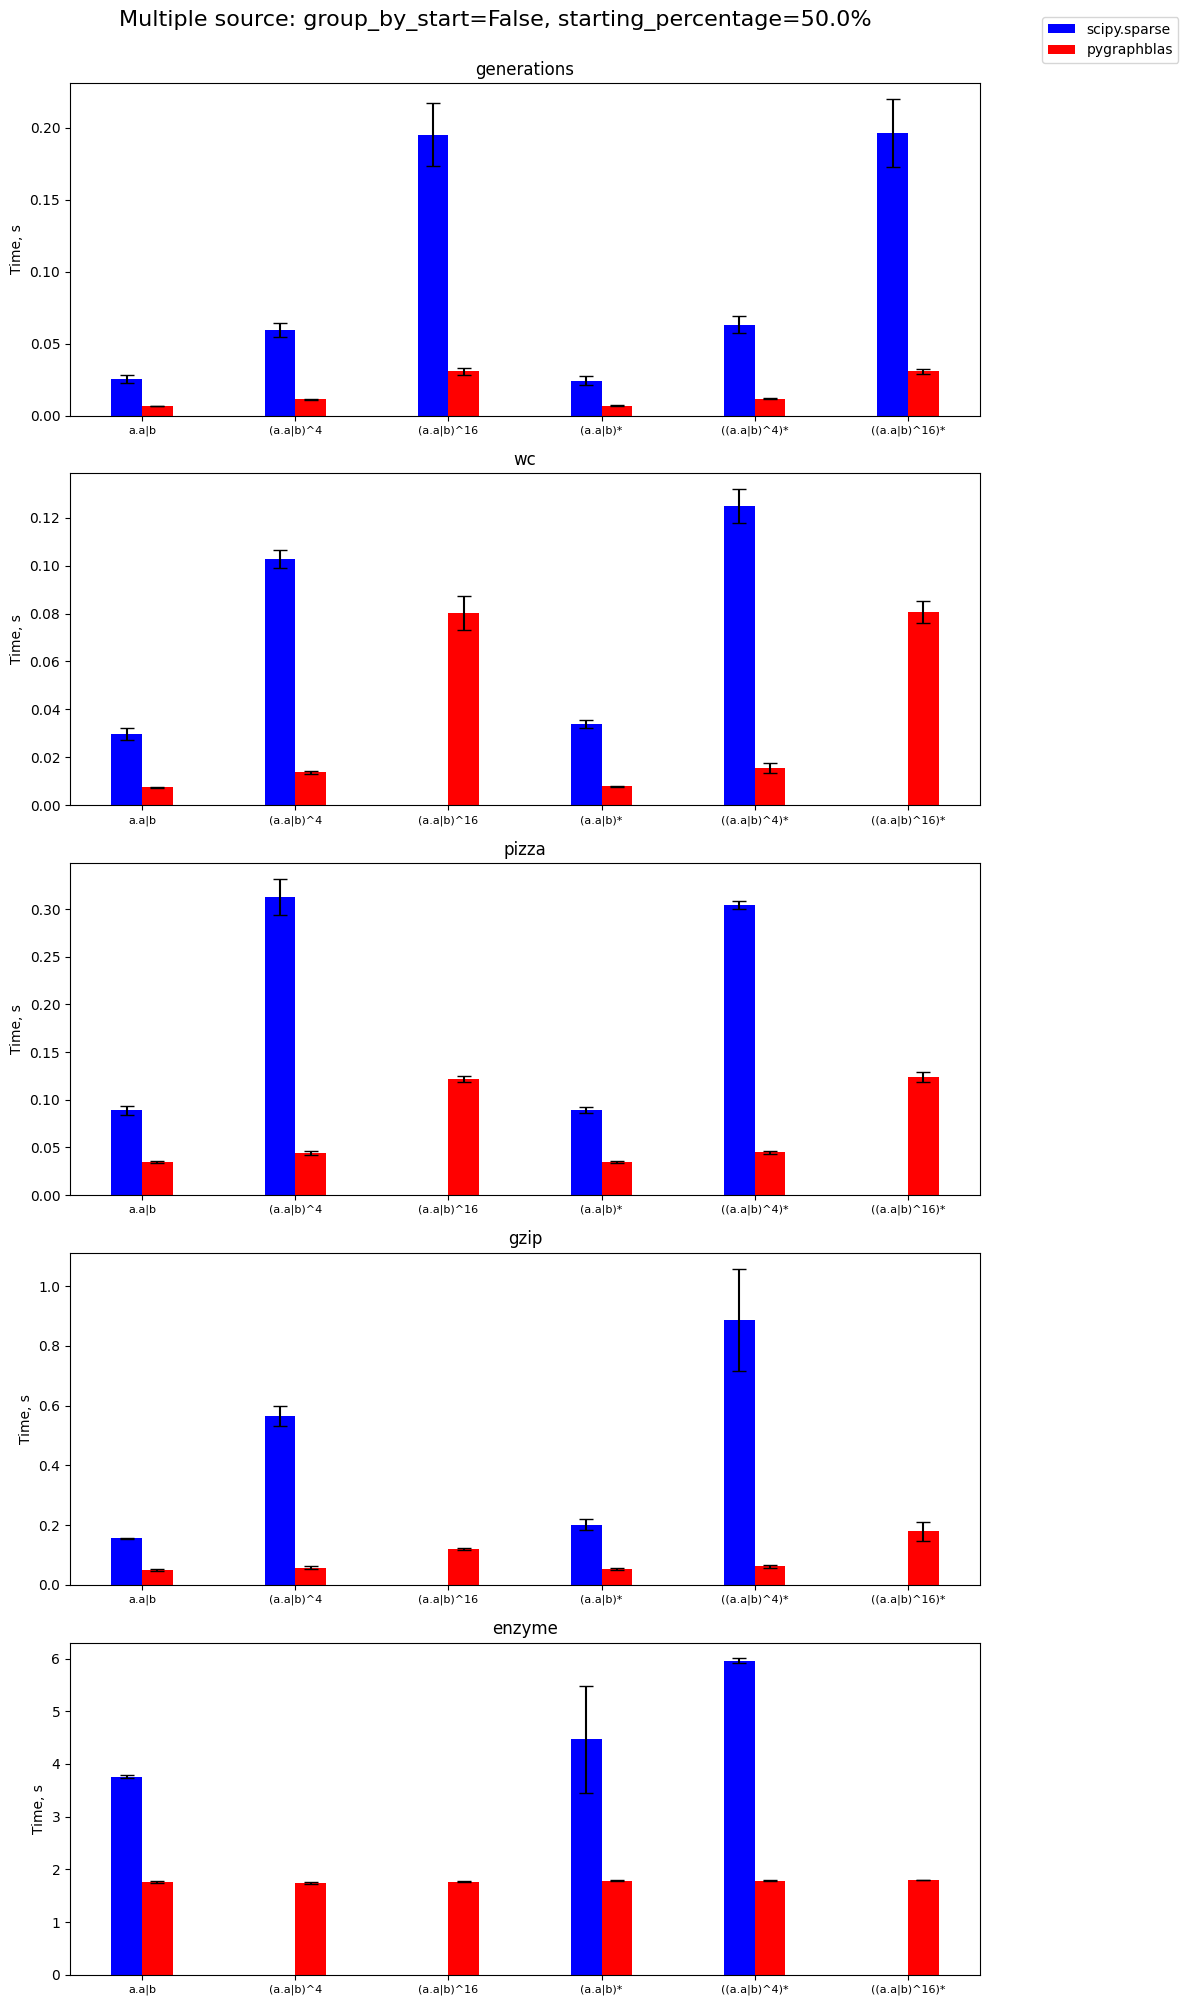

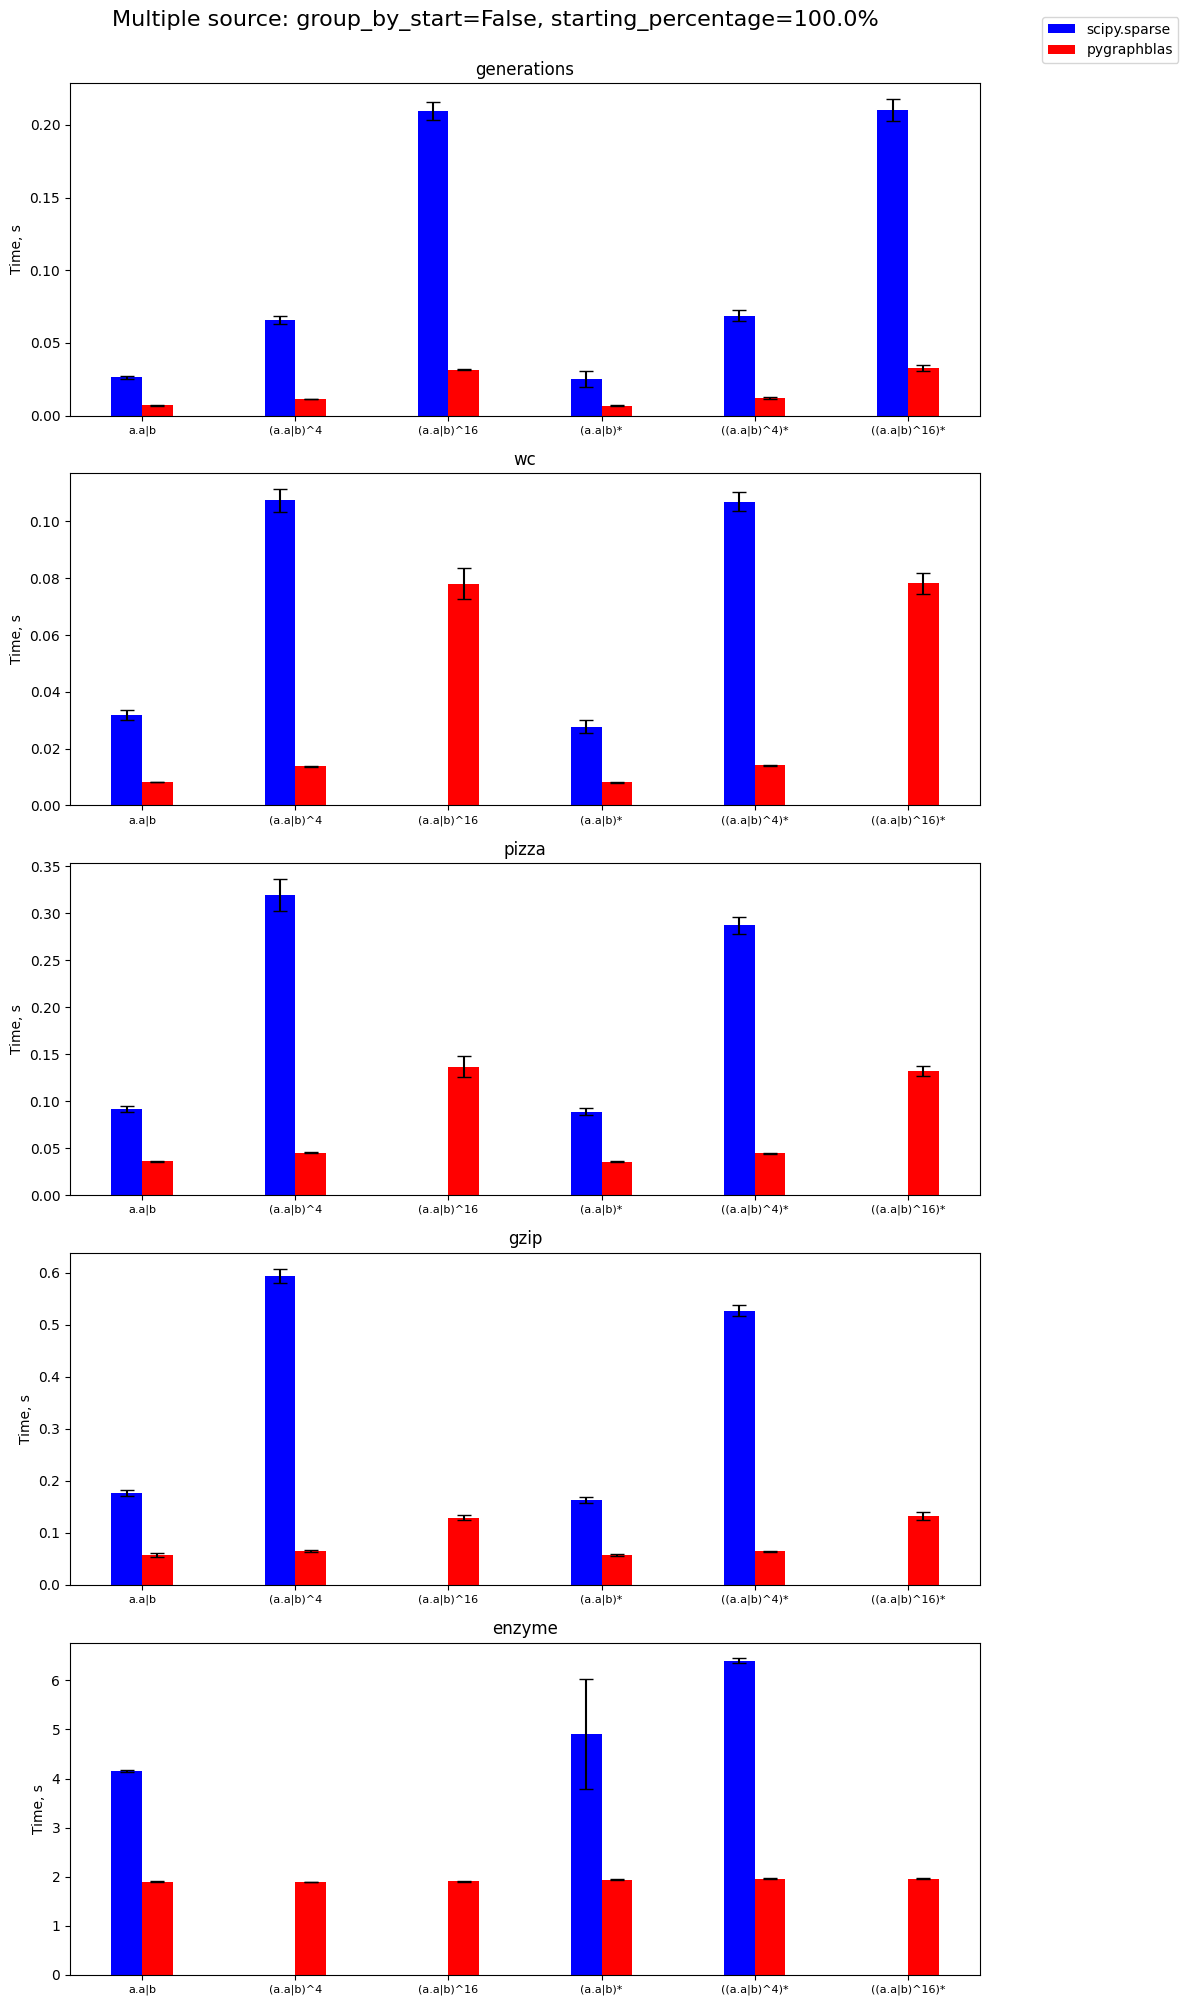

In [ ]:
for (algorithm_name, _, _, is_applicable_for) in ALGORITHMS:
    graphs = [
        graph_name
        for graph_name in GRAPHS
        if is_applicable_for(get_graph(graph_name))
    ]
    fig, axs = plt.subplots(nrows=len(graphs), figsize=(10, 4 * len(graphs)))
    fig.suptitle(algorithm_name, y=1, fontsize=16)
    for (ax, graph_name) in zip(axs, graphs):
        graph = get_graph(graph_name)
        starting_percentages = get_starting_percentages_for_graph(graph)
        ax: plt.Axes = ax
        ax.set_title(graph_name)
        ax.set_ylabel("Time, s")
        label_positions = np.arange(len(REGEXES)) * 1.5
        ax.set_xticks(
            label_positions, [regex_name for (regex_name, _) in REGEXES], fontsize=8
        )
        bar_width = 0.3
        for (i, (lib_name, _, lib_color)) in enumerate(BOOL_DECOMPOSED_NFA_CLASSES):
            means, stds = zip(
                *[
                    res[(algorithm_name, graph_name, regex_name, lib_name)]
                    for (regex_name, _) in REGEXES
                ]
            )
            if len(list(finites(means))) > 0:
                ax.bar(
                    x=label_positions
                    + bar_width * (0.5 + i - len(BOOL_DECOMPOSED_NFA_CLASSES) / 2),
                    height=means,
                    yerr=stds,
                    width=bar_width,
                    color=lib_color,
                    label=lib_name,
                    capsize=5.0,
                )
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.04, 1))
    fig.tight_layout()
    plt.show()

Можно наблюдать, что при решении первой вариации задачи (`All pairs`) использование библиотеки [pygraphblas](https://github.com/Graphegon/pygraphblas) даёт выигрыш в производительности по сравнению с использованием библиотеки [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html), только когда запросы достаточно маленькие, в частности, на используемых входных данных выигрыш наблюдается для запросов, которым соответствуют минимальные детерминированные конечные автоматы с менее чем десятью состояниями. Для больших же запросов (в данном случае тех, которым соответствуют минимальные детерминированные конечные автоматы с более чем 30 состояниями) наблюдались как выигрыши, так и проигрыши в производительности.

<br/>

При решении же второй (`Multiple source: group_by_start=False`) и третьей (`Multiple source: group_by_start=True`) вариаций задачи при любых условиях наблюдался значительный выигрыш в производительности при использовании библиотеки [pygraphblas](https://github.com/Graphegon/pygraphblas) по сравнению с использованием библиотеки [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html).

### Определение того, начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные (при использовании библиотеки [pygraphblas](https://github.com/Graphegon/pygraphblas))

Для определения того, начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные, были построены графики, на которых:
 - Красная горизонтальная линия соответствует времени работы реализации алгоритма, решающего задачу для всех пар (красная полоса вокруг неё показывает стандартное отклонение)
 - Жёлтым и голубым показаны время работы и стандартное отклонения решений второй (`Multiple source: group_by_start=False`) и третьей (`Multiple source: group_by_start=True`) вариаций задачи соответственно

<br/>

Графики обрезаны сверху, так как для ответа на вопрос интересны только окрестности красной линии.

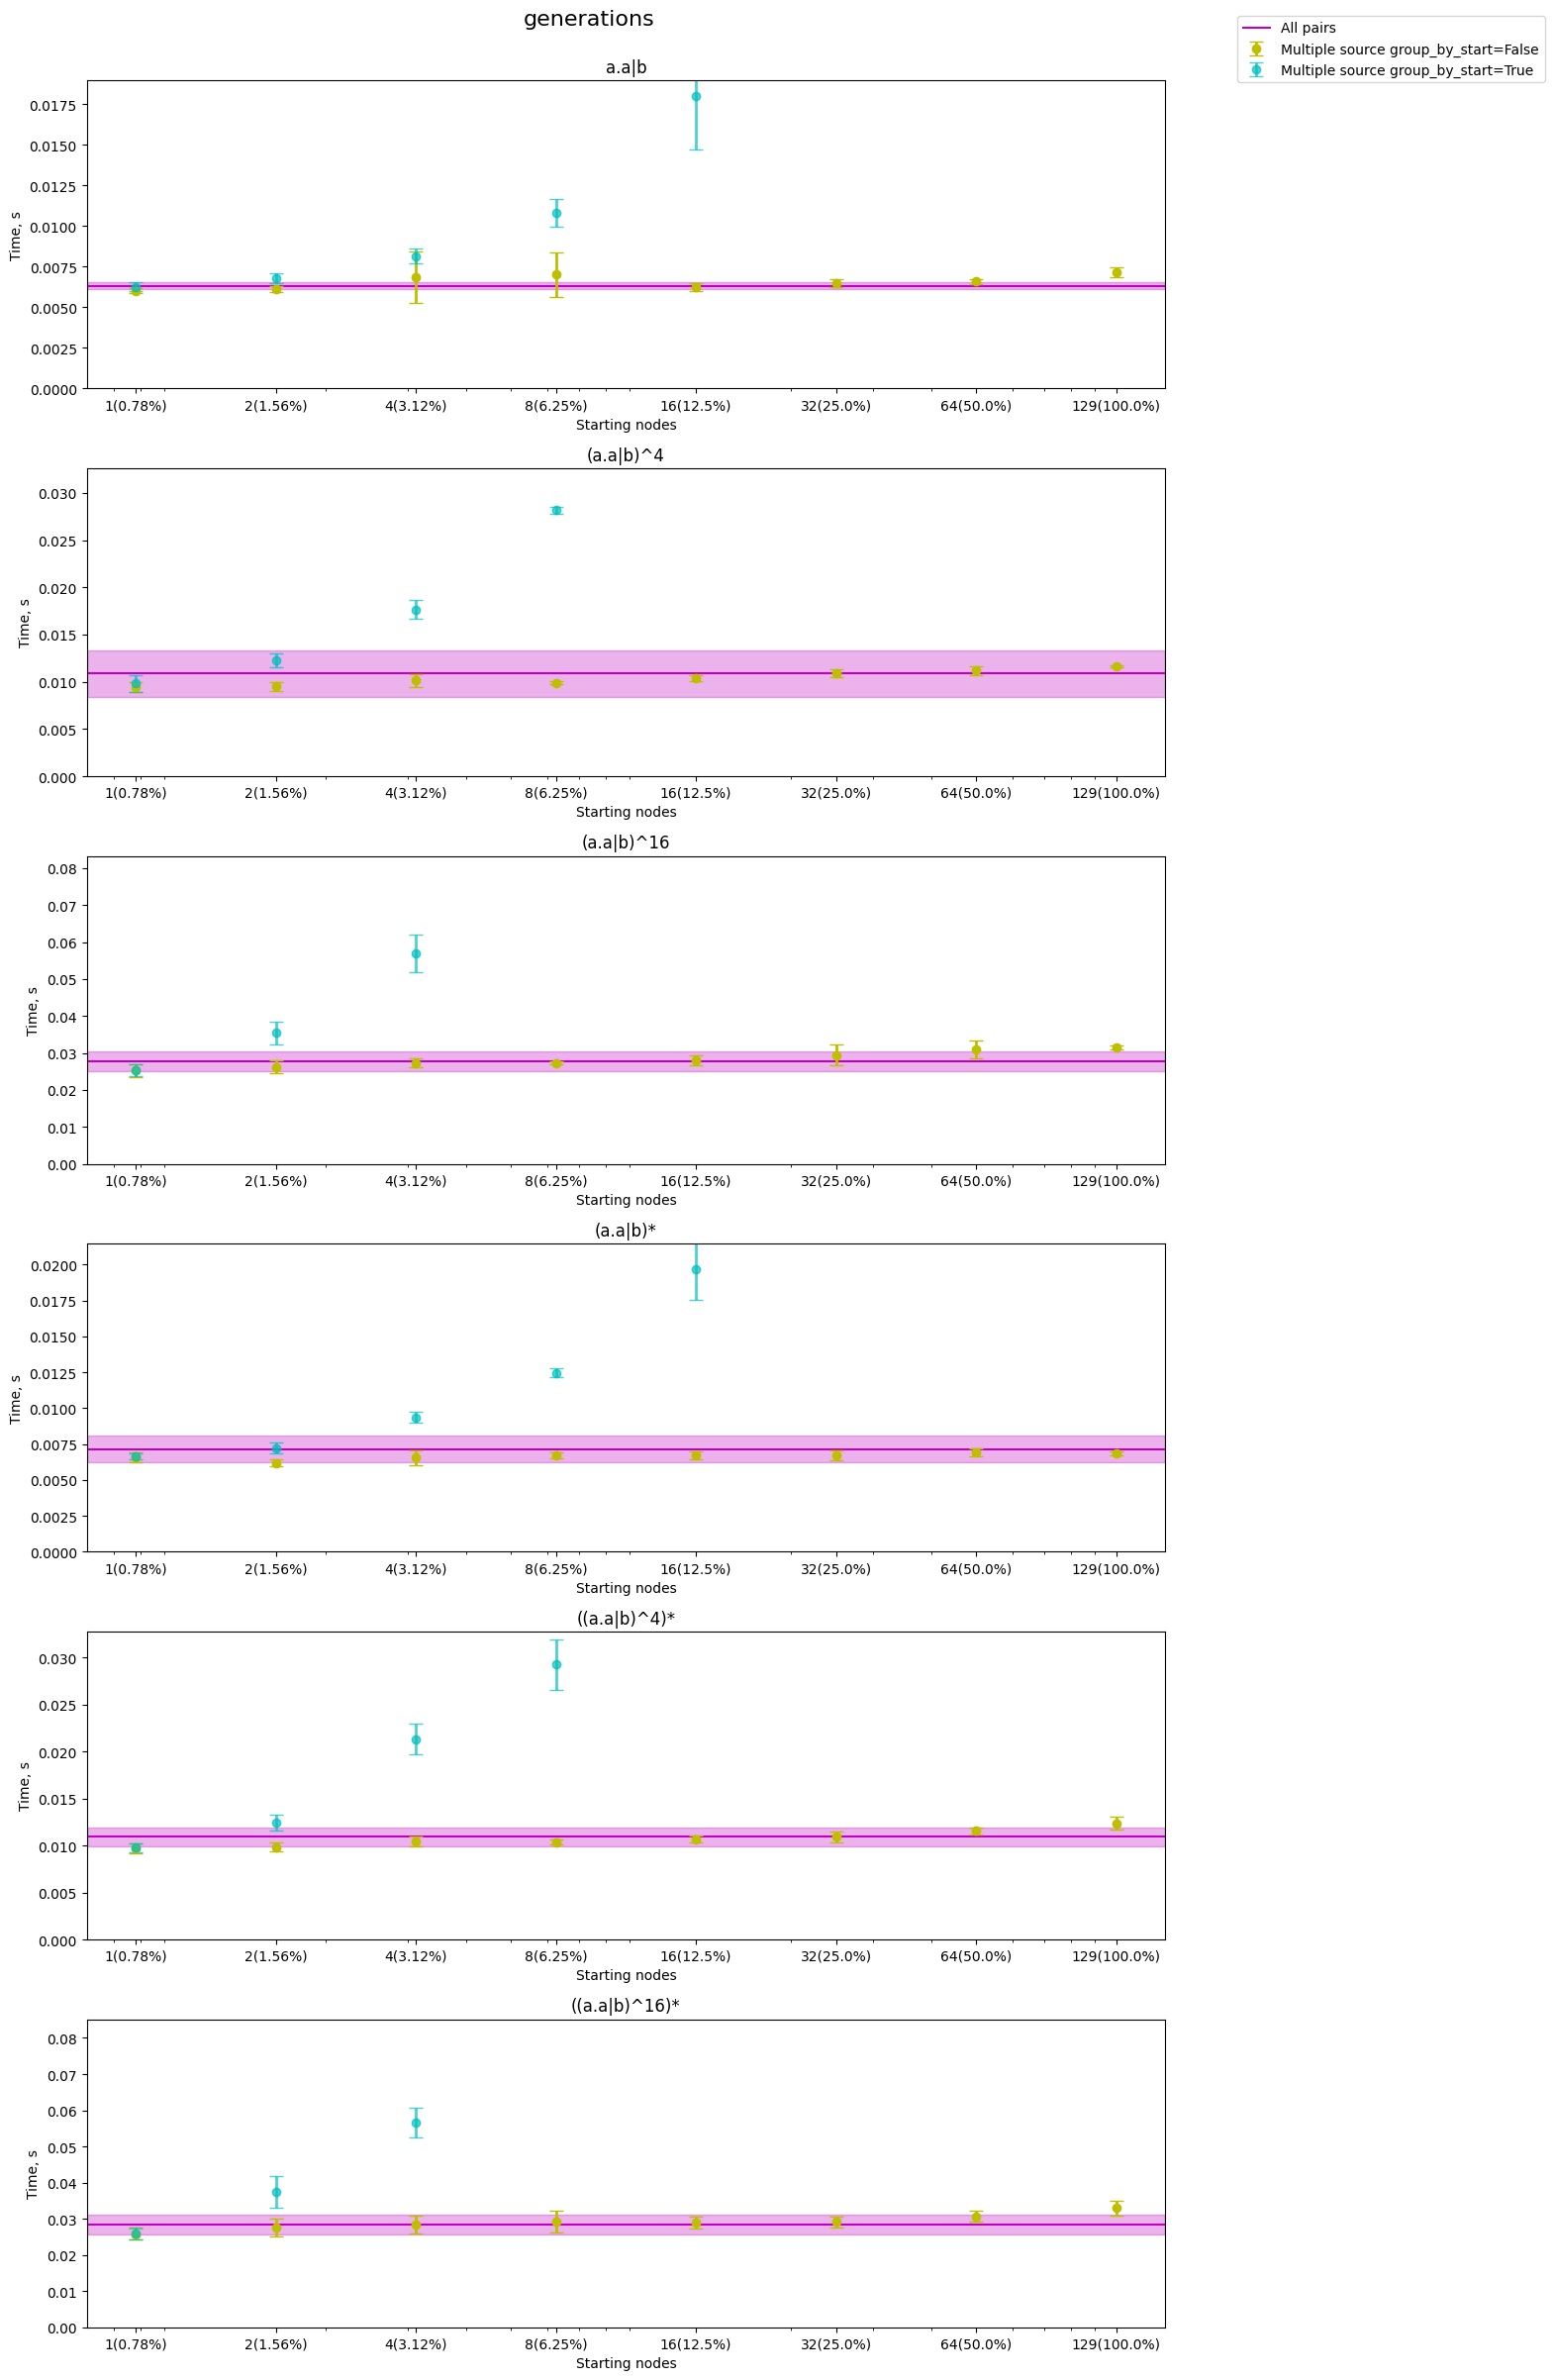

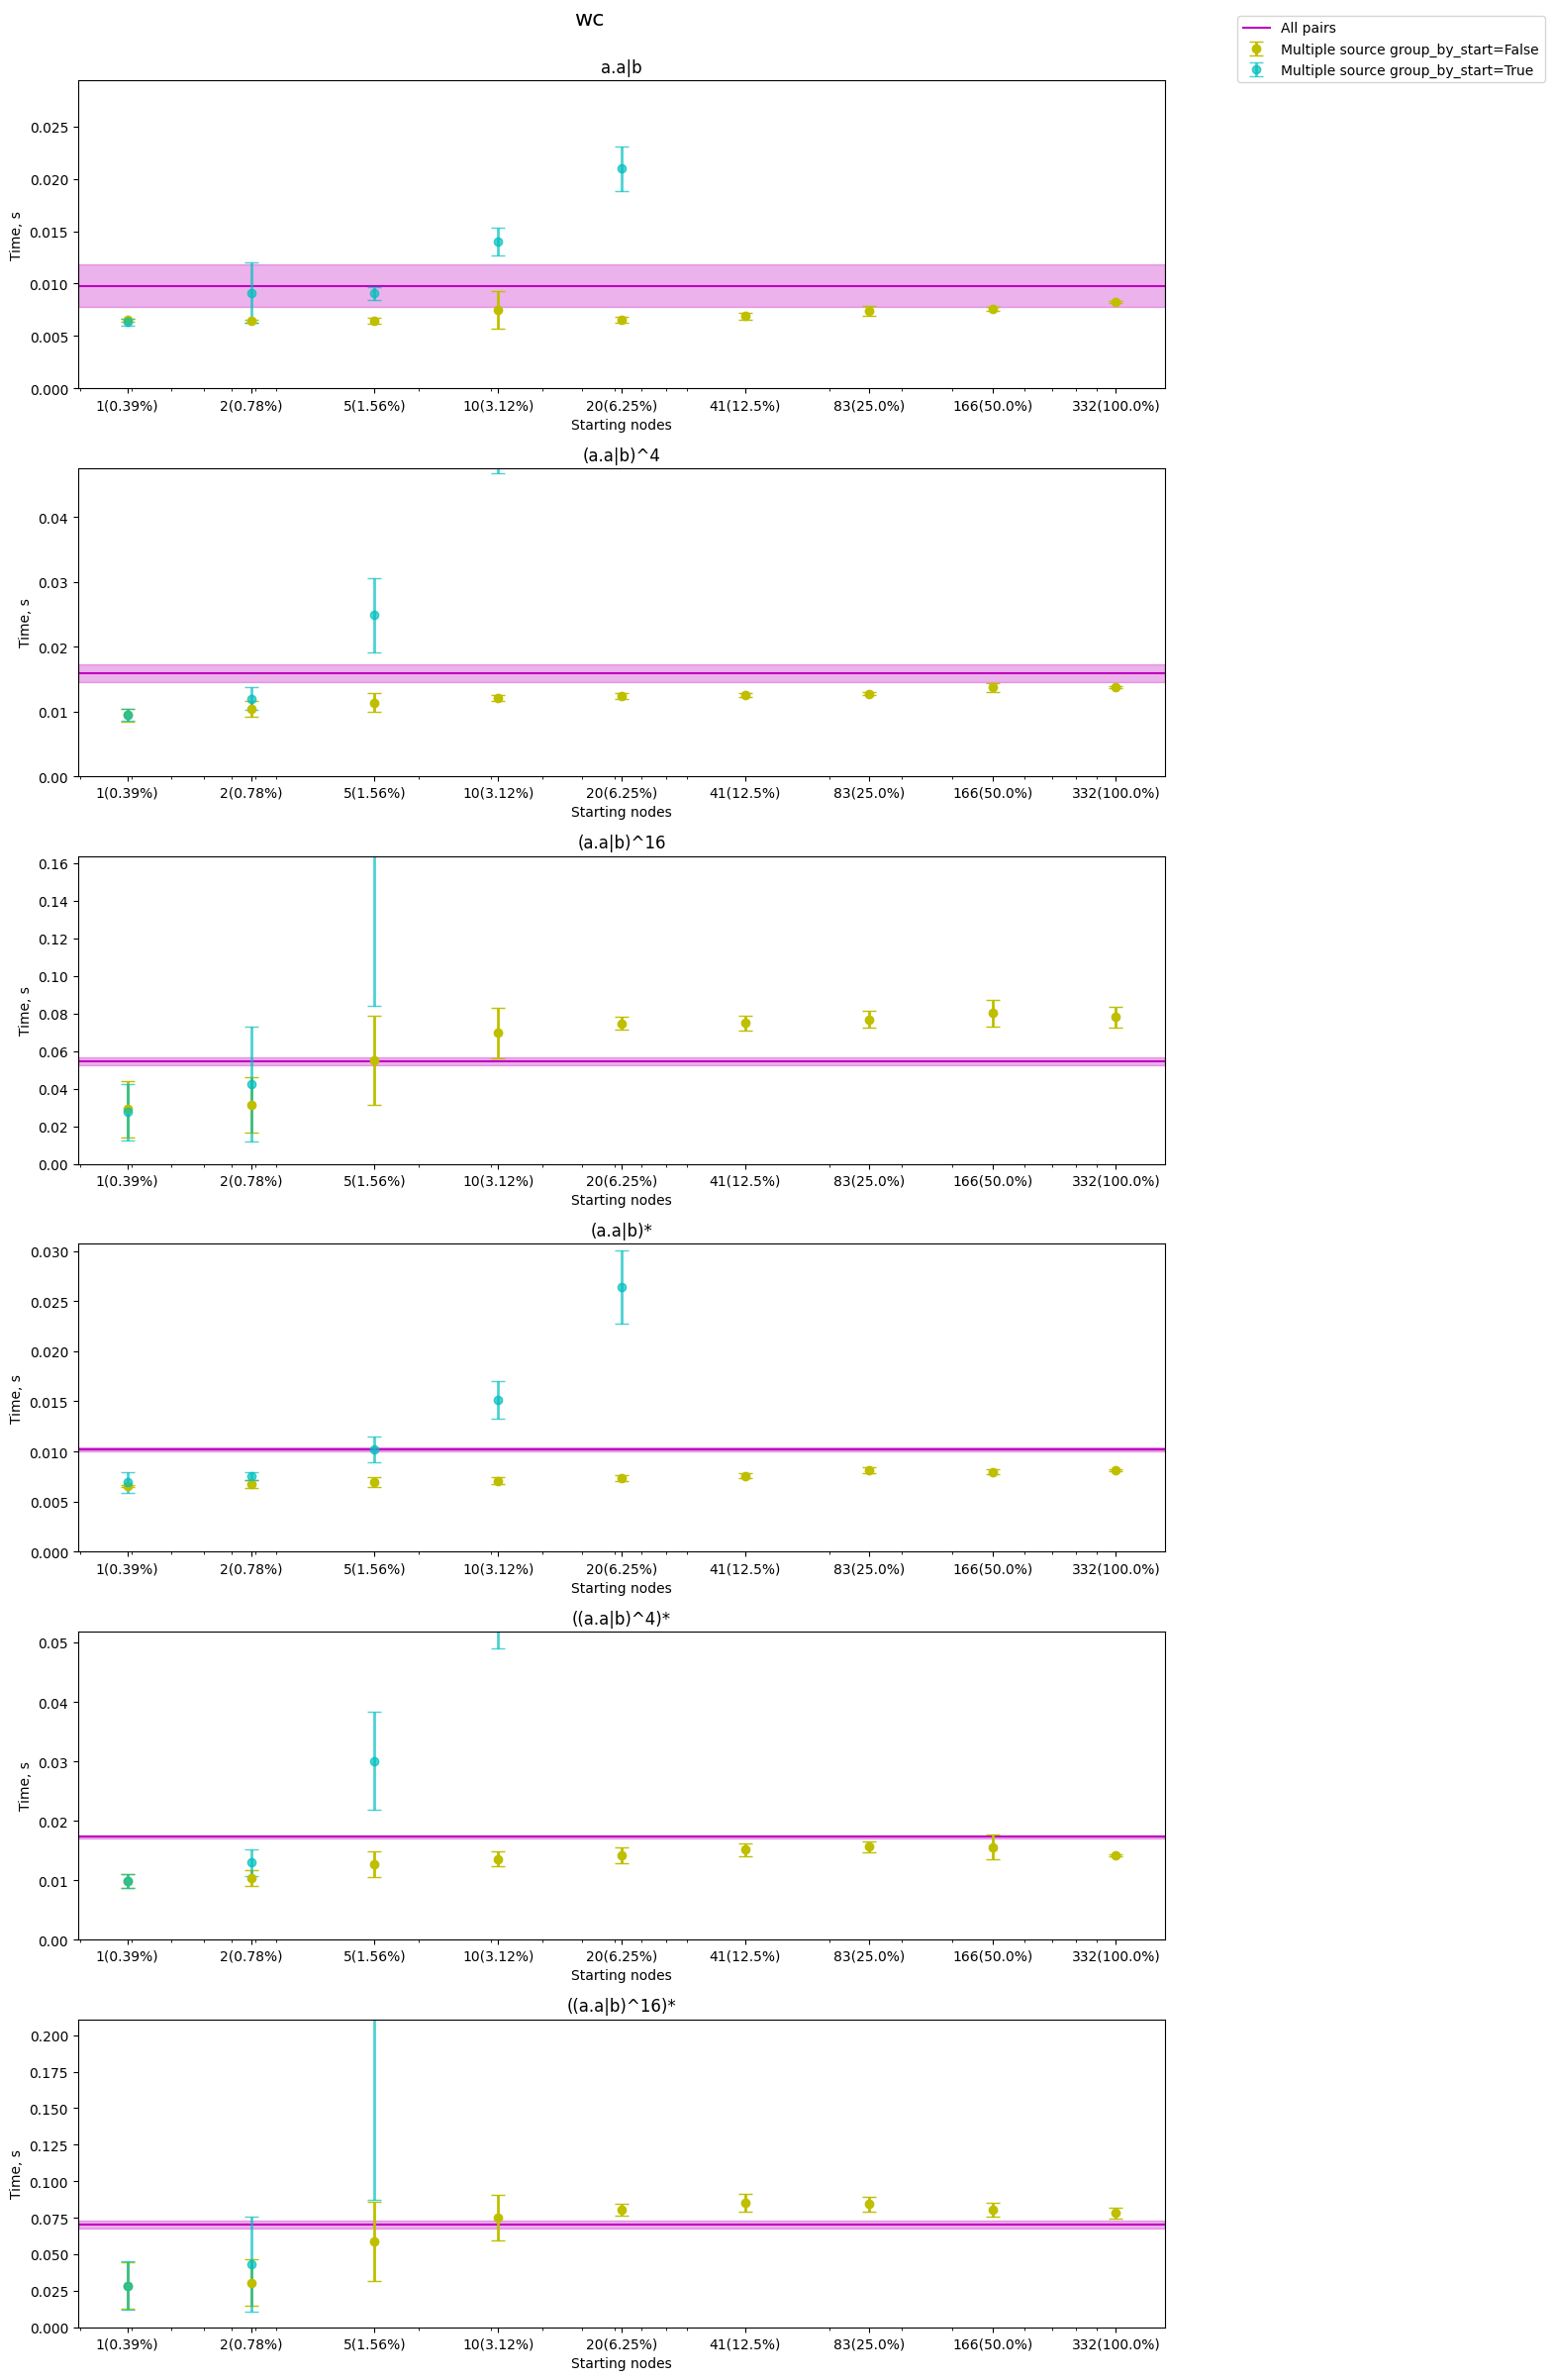

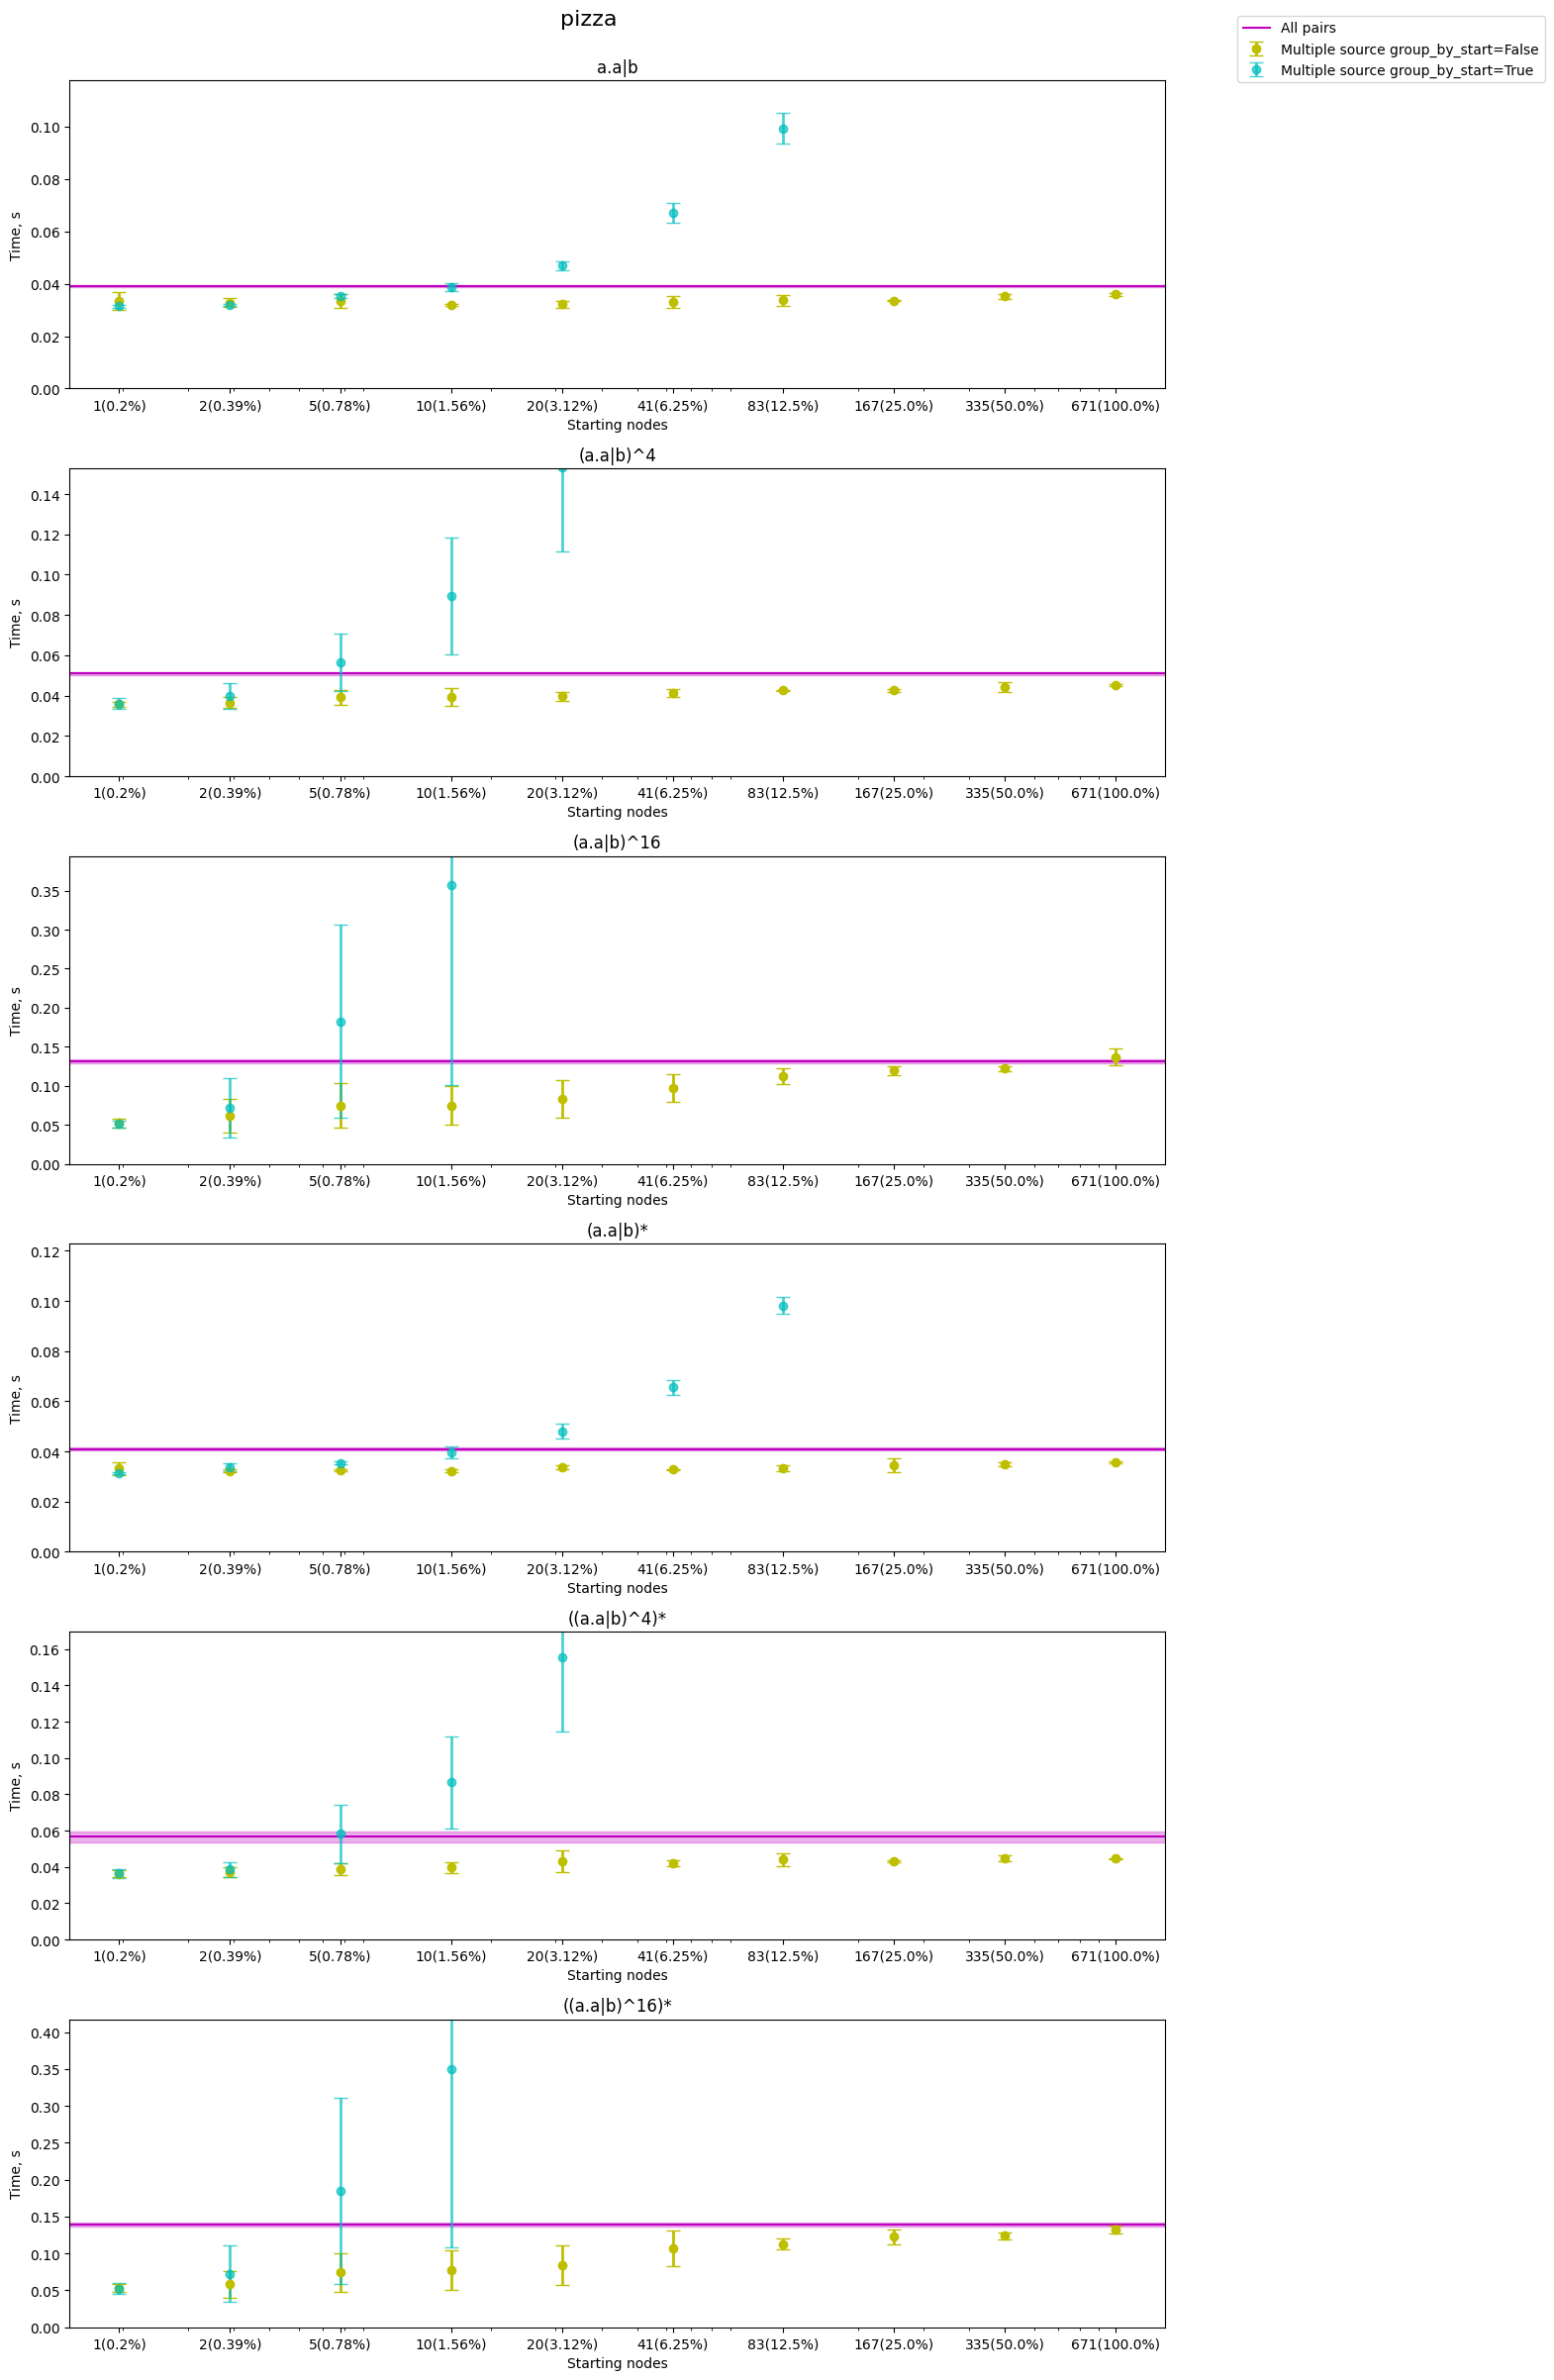

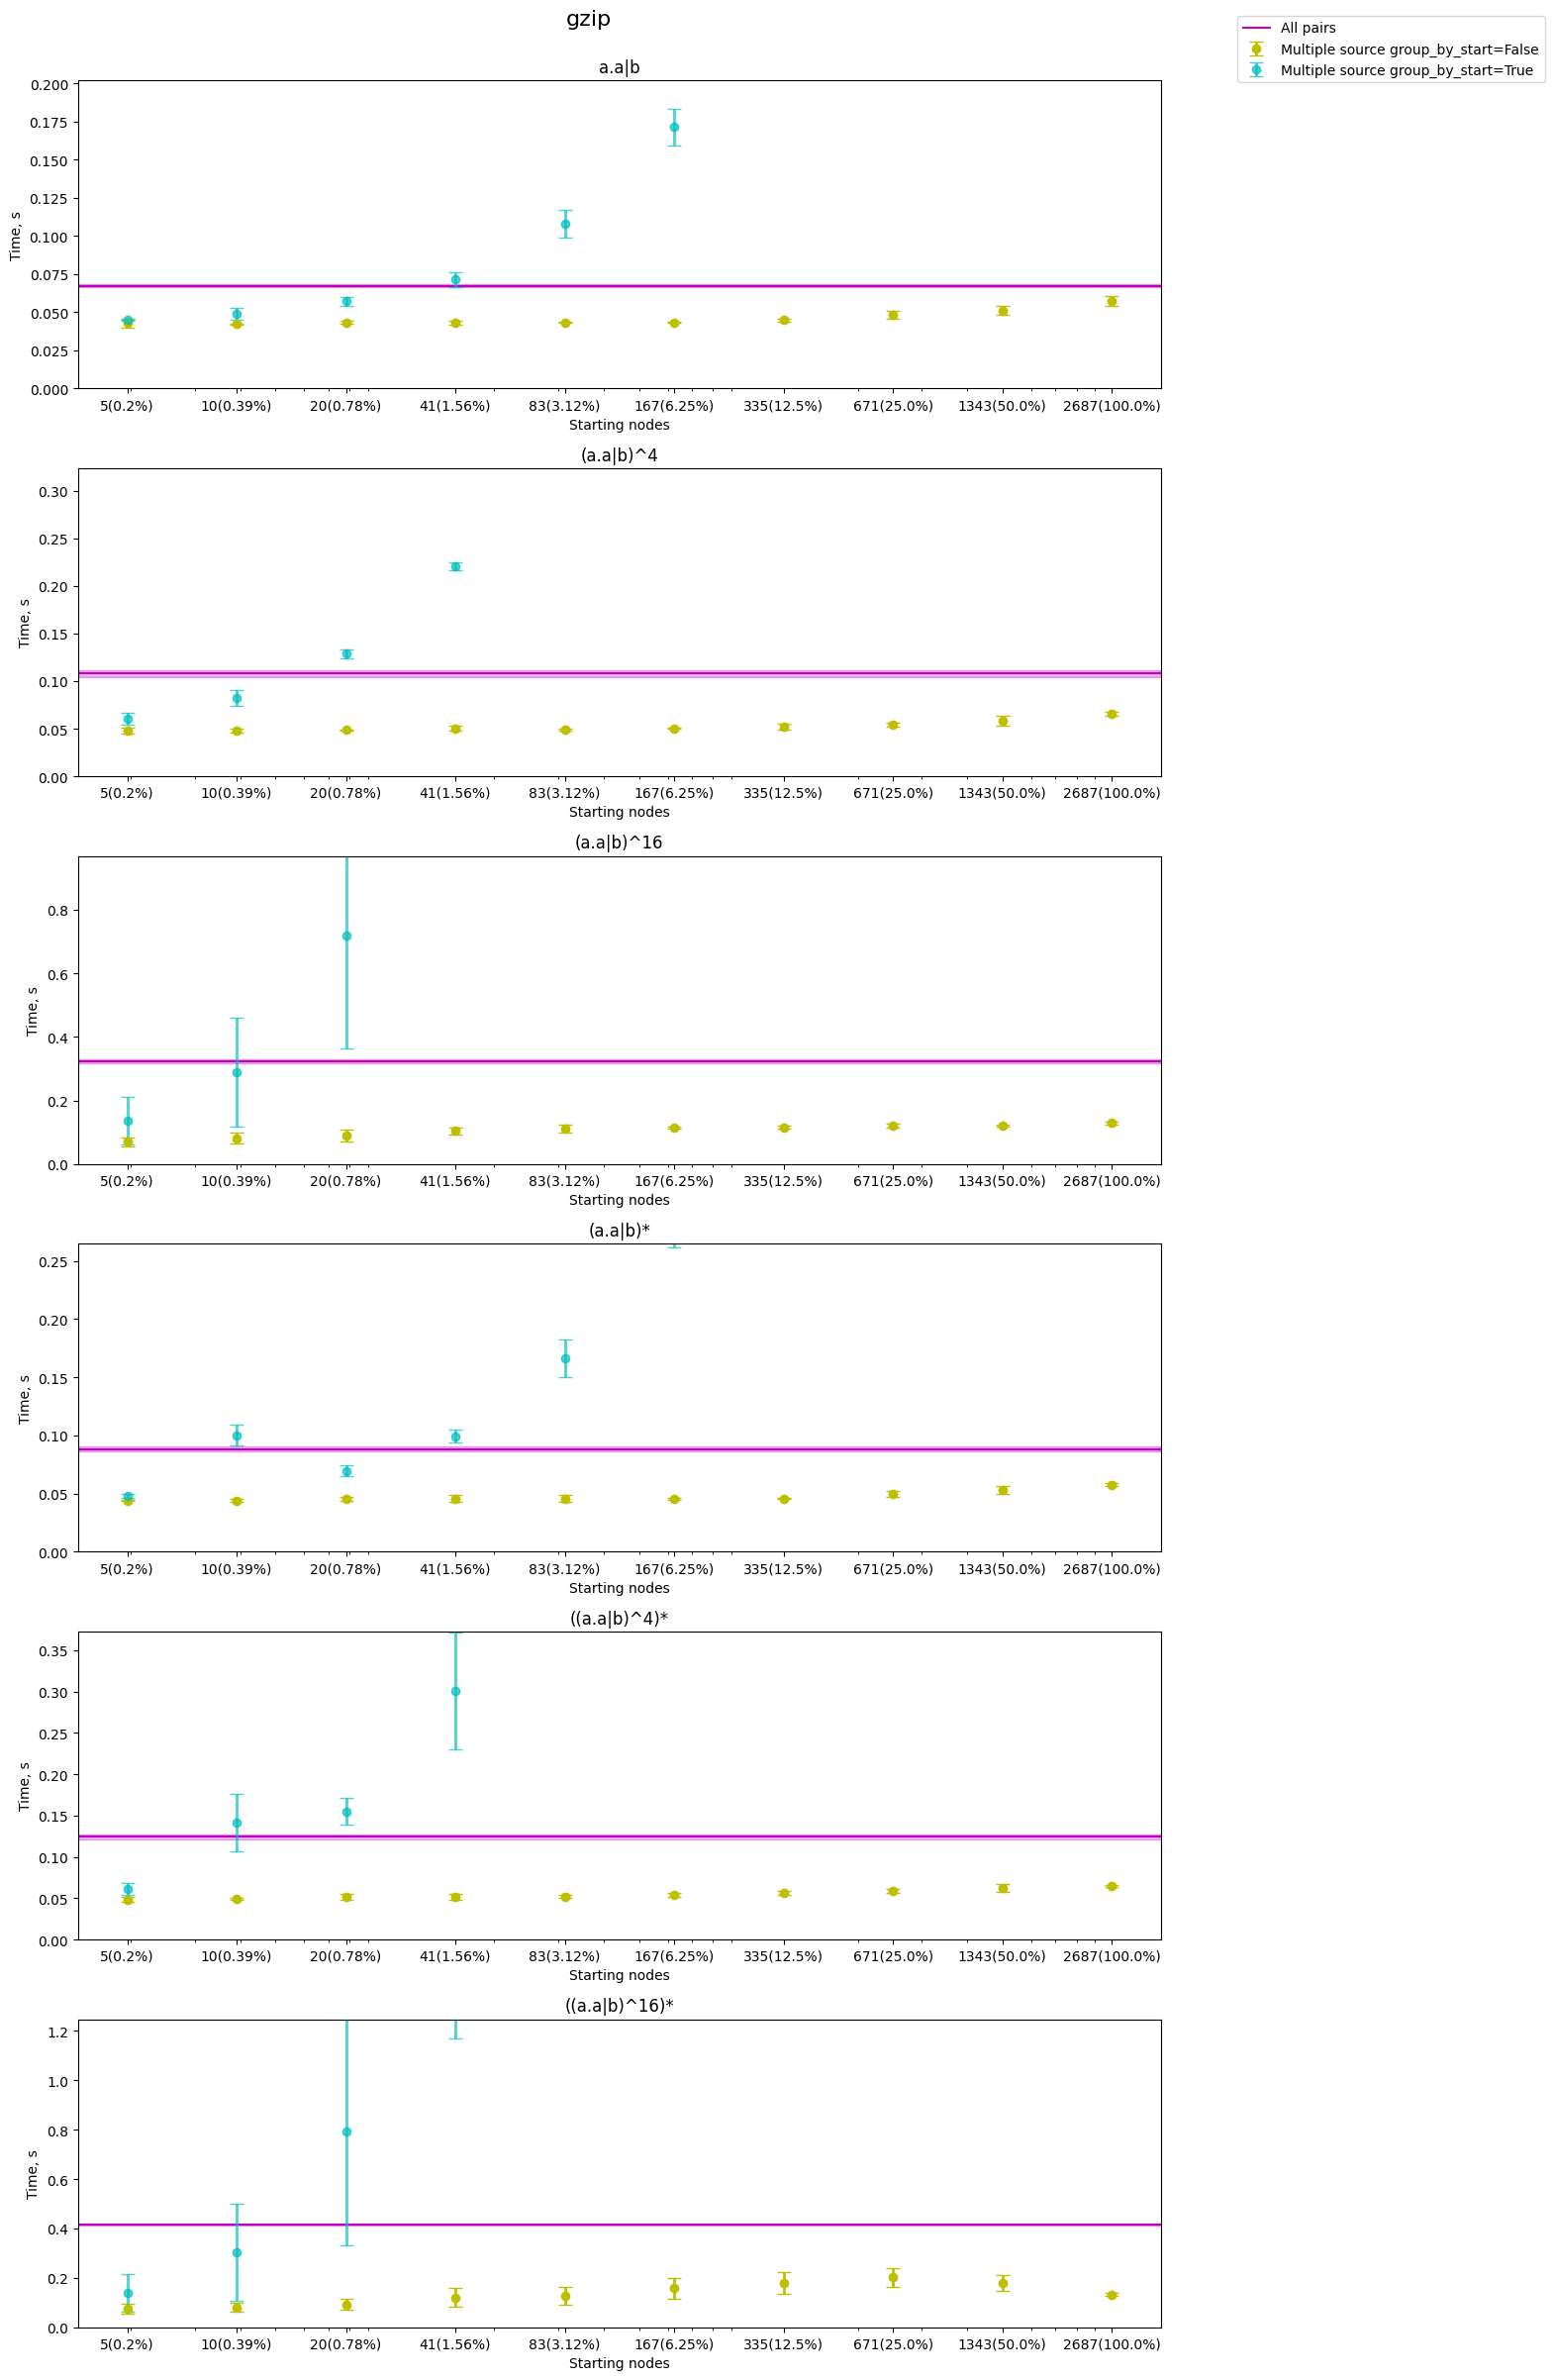

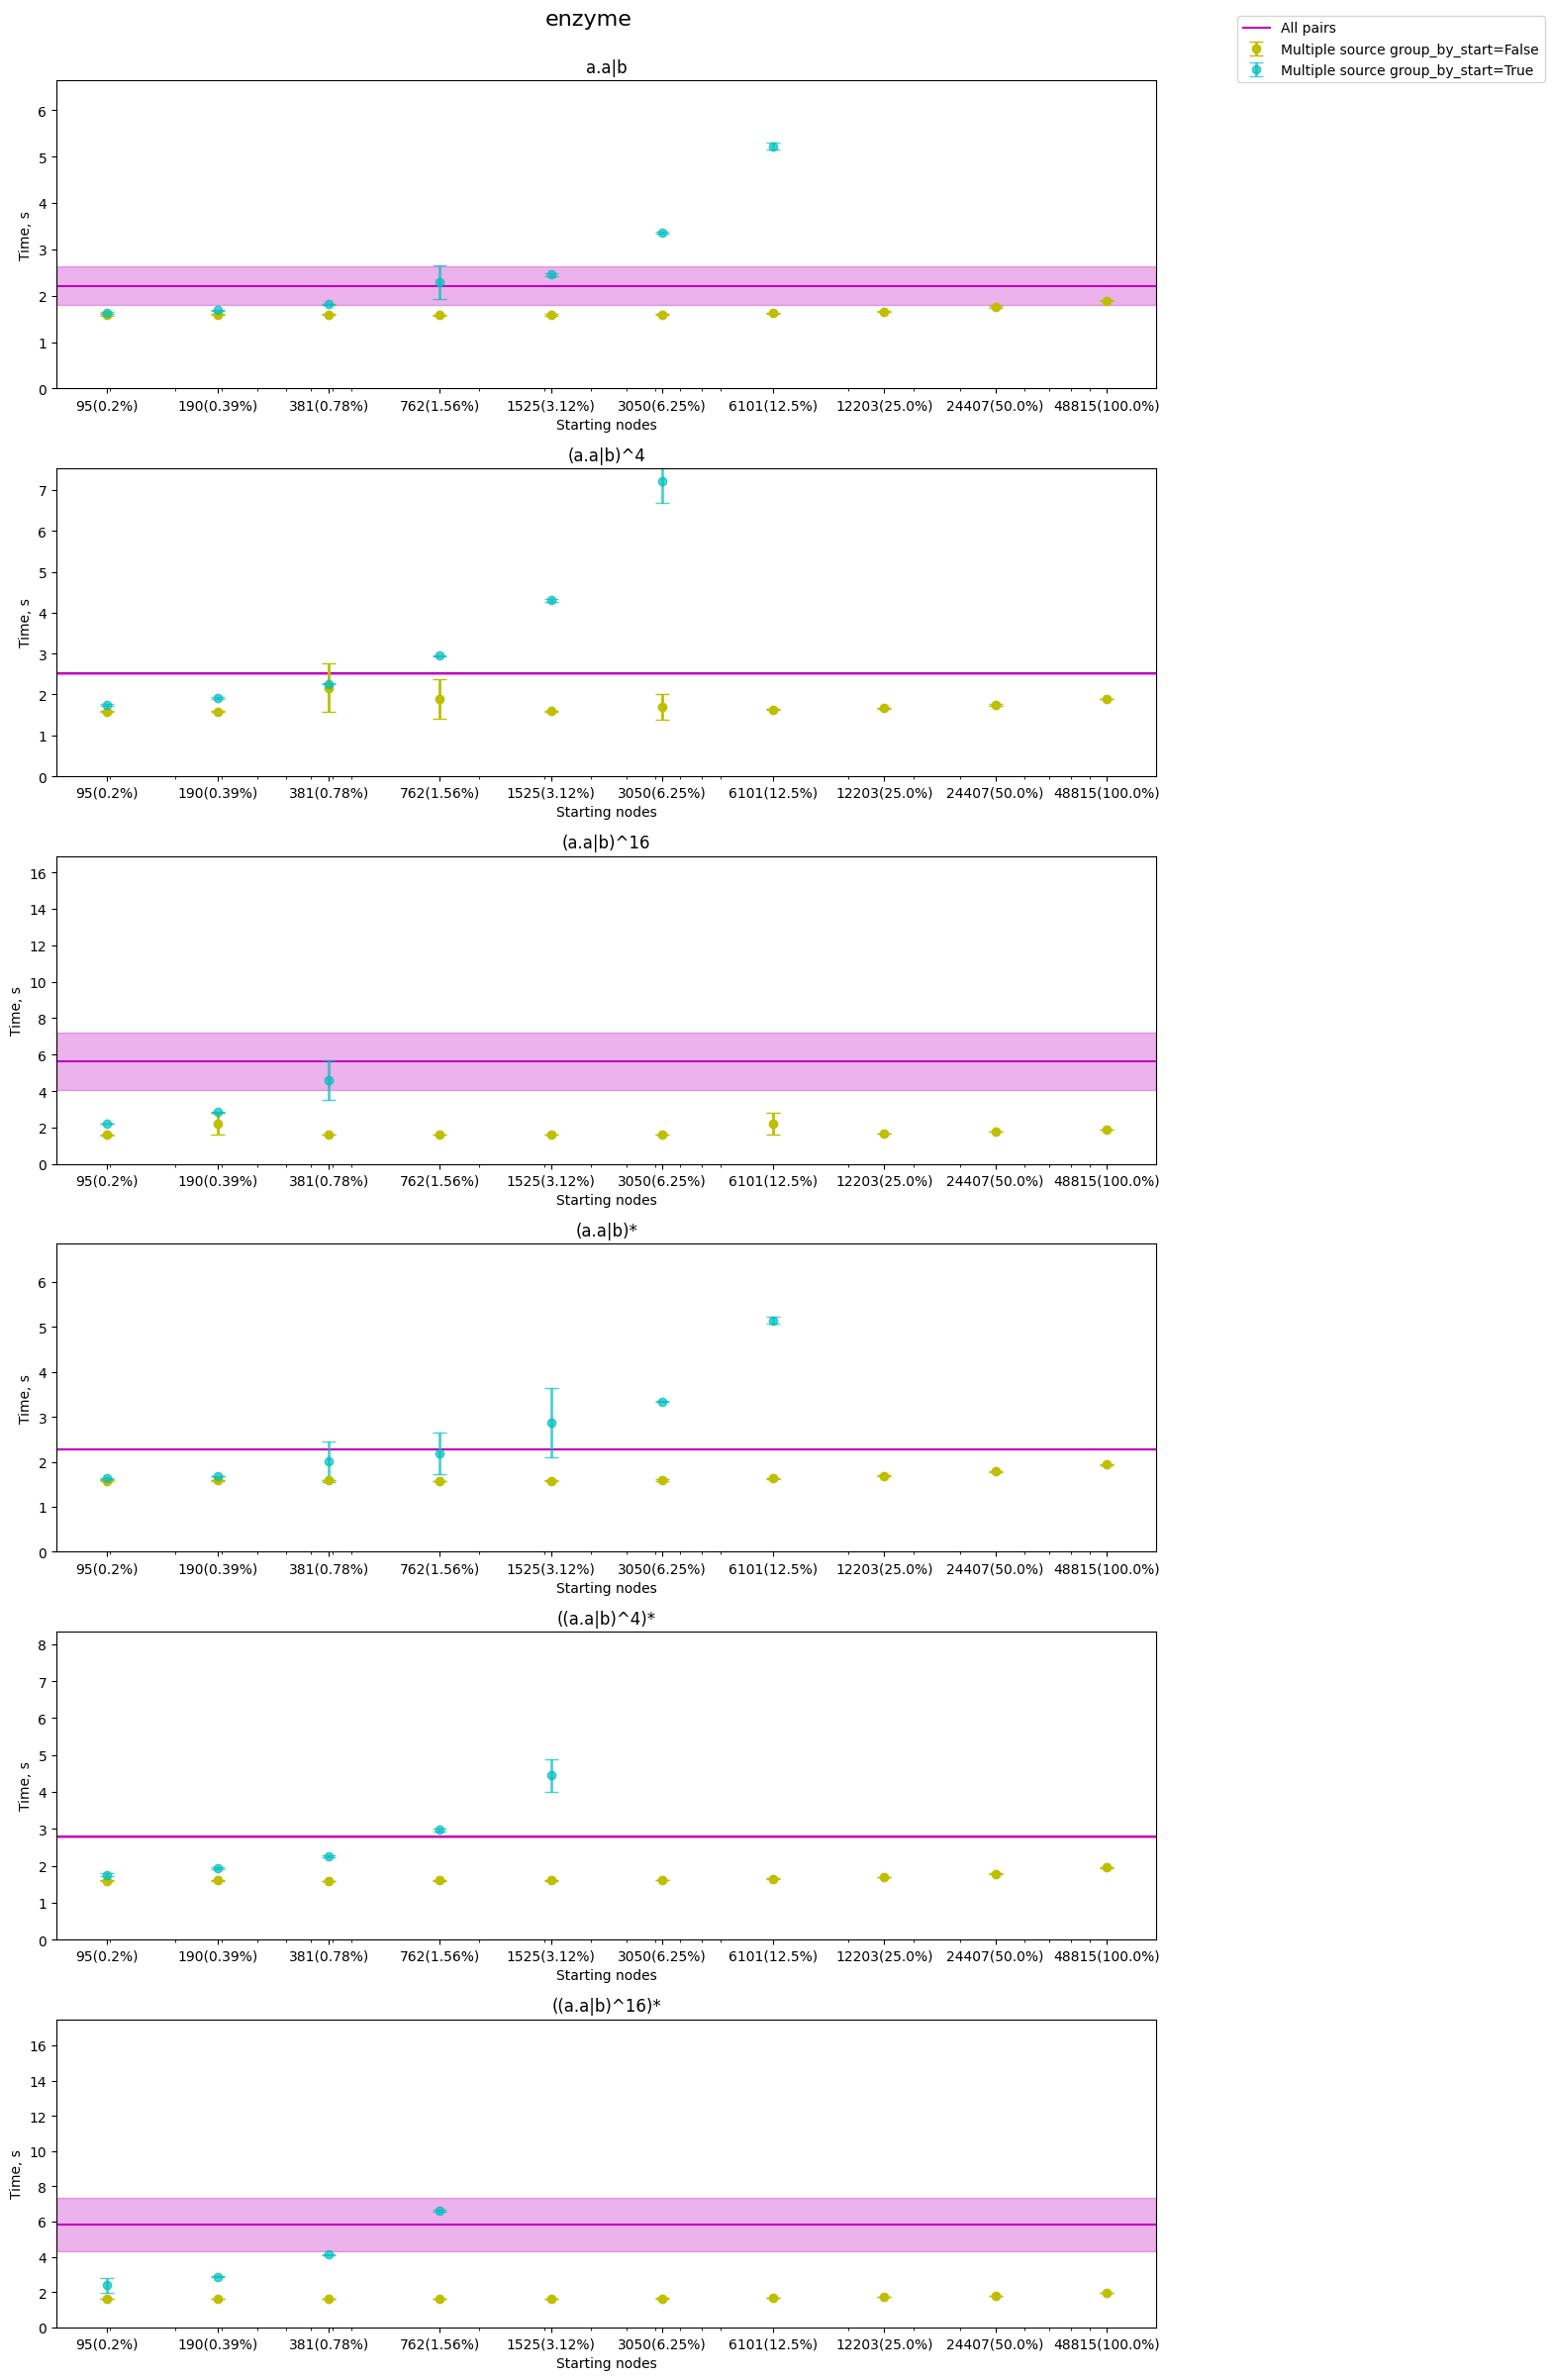

In [ ]:
for graph_name in GRAPHS:
    fig, axs = plt.subplots(nrows=len(REGEXES), figsize=(12, 4 * len(REGEXES)))
    fig.suptitle(graph_name, y=1, fontsize=16)
    graph = get_graph(graph_name)
    nodes_total = graph.number_of_nodes()
    starting_percentages = get_starting_percentages_for_graph(graph)
    for (ax, (regex_name, _)) in zip(axs, REGEXES):
        ax: plt.Axes = ax
        ax.set_title(regex_name)
        ax.set_ylabel("Time, s")
        ax.set_xlabel("Starting nodes")
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.set_xticks(
            starting_percentages,
            [
                f"{int(nodes_total / 100 * percent)}({round(percent, 2)}%)"
                for percent in starting_percentages
            ],
            fontsize=10,
        )
        all_pairs_mean, all_pairs_std = res[
            ("All pairs", graph_name, regex_name, "pygraphblas")
        ]
        if np.isfinite(all_pairs_mean):
            ax.axhline(all_pairs_mean, color="m", label="All pairs")
            ax.axhspan(
                ymin=all_pairs_mean - all_pairs_std,
                ymax=all_pairs_mean + all_pairs_std,
                color="m",
                alpha=0.3,
            )
        for (group_by_start, color) in [(False, "y"), (True, "c")]:
            multiple_source_means, multiple_source_stds = zip(
                *[
                    res[
                        (
                            get_multiple_source_rpq_algorithm_name(
                                group_by_start=group_by_start,
                                starting_percentage=starting_percentage,
                            ),
                            graph_name,
                            regex_name,
                            "pygraphblas",
                        )
                    ]
                    for starting_percentage in starting_percentages
                ]
            )
            if len(multiple_source_means) > 0:
                ax.errorbar(
                    x=starting_percentages,
                    y=multiple_source_means,
                    yerr=multiple_source_stds,
                    fmt="o",
                    linewidth=2,
                    capsize=5,
                    label=f"Multiple source group_by_start={group_by_start}",
                    color=color,
                    alpha=0.7 if group_by_start else 1.0,
                )
        if np.isfinite(all_pairs_mean):
            ax.set_ylim(bottom=0, top=all_pairs_mean * 3)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.04, 1))
    fig.tight_layout()
    plt.show()

Анализируя графики, можно сделать вывод, что если необходимо решить задачу достижимости с регулярным ограничением для каждой вершины из заданного множества стартовых вершин, то в большинстве рассмотренных случаев решение задачи для всех пар и выбор нужных становится более выгодным, когда размер стартового множества начинает превышать некоторое значение от $0.39\%$ до $3.12\%$ от общего числа вершин в графе, конкретный же переломный размер зависит от графа, запроса и, как показывают достаточно большие стандартные отклонения, ещё и от структуры стартового множества.

<br/>

Если же необходимо решить задачу достижимости с регулярным ограничением для всего множества заданных вершин, то в большинстве рассмотренных случаев решение задачи для всех пар менее выгодное, а исключения приходятся на случаи, когда достаточно большой запрос применяется к достаточно маленькому графу.

### Определение того, на сколько решение второй вариации задачи медленнее решения третьей при одинаковых начальных условиях (при использовании библиотеки [pygraphblas](https://github.com/Graphegon/pygraphblas))

Для определения того, на сколько решение второй вариации задачи медленнее решения третьей при одинаковых начальных условиях были построены графики, показывающие, во сколько раз решение второй вариации задачи медленнее решения третьей при одинаковых начальных условиях.

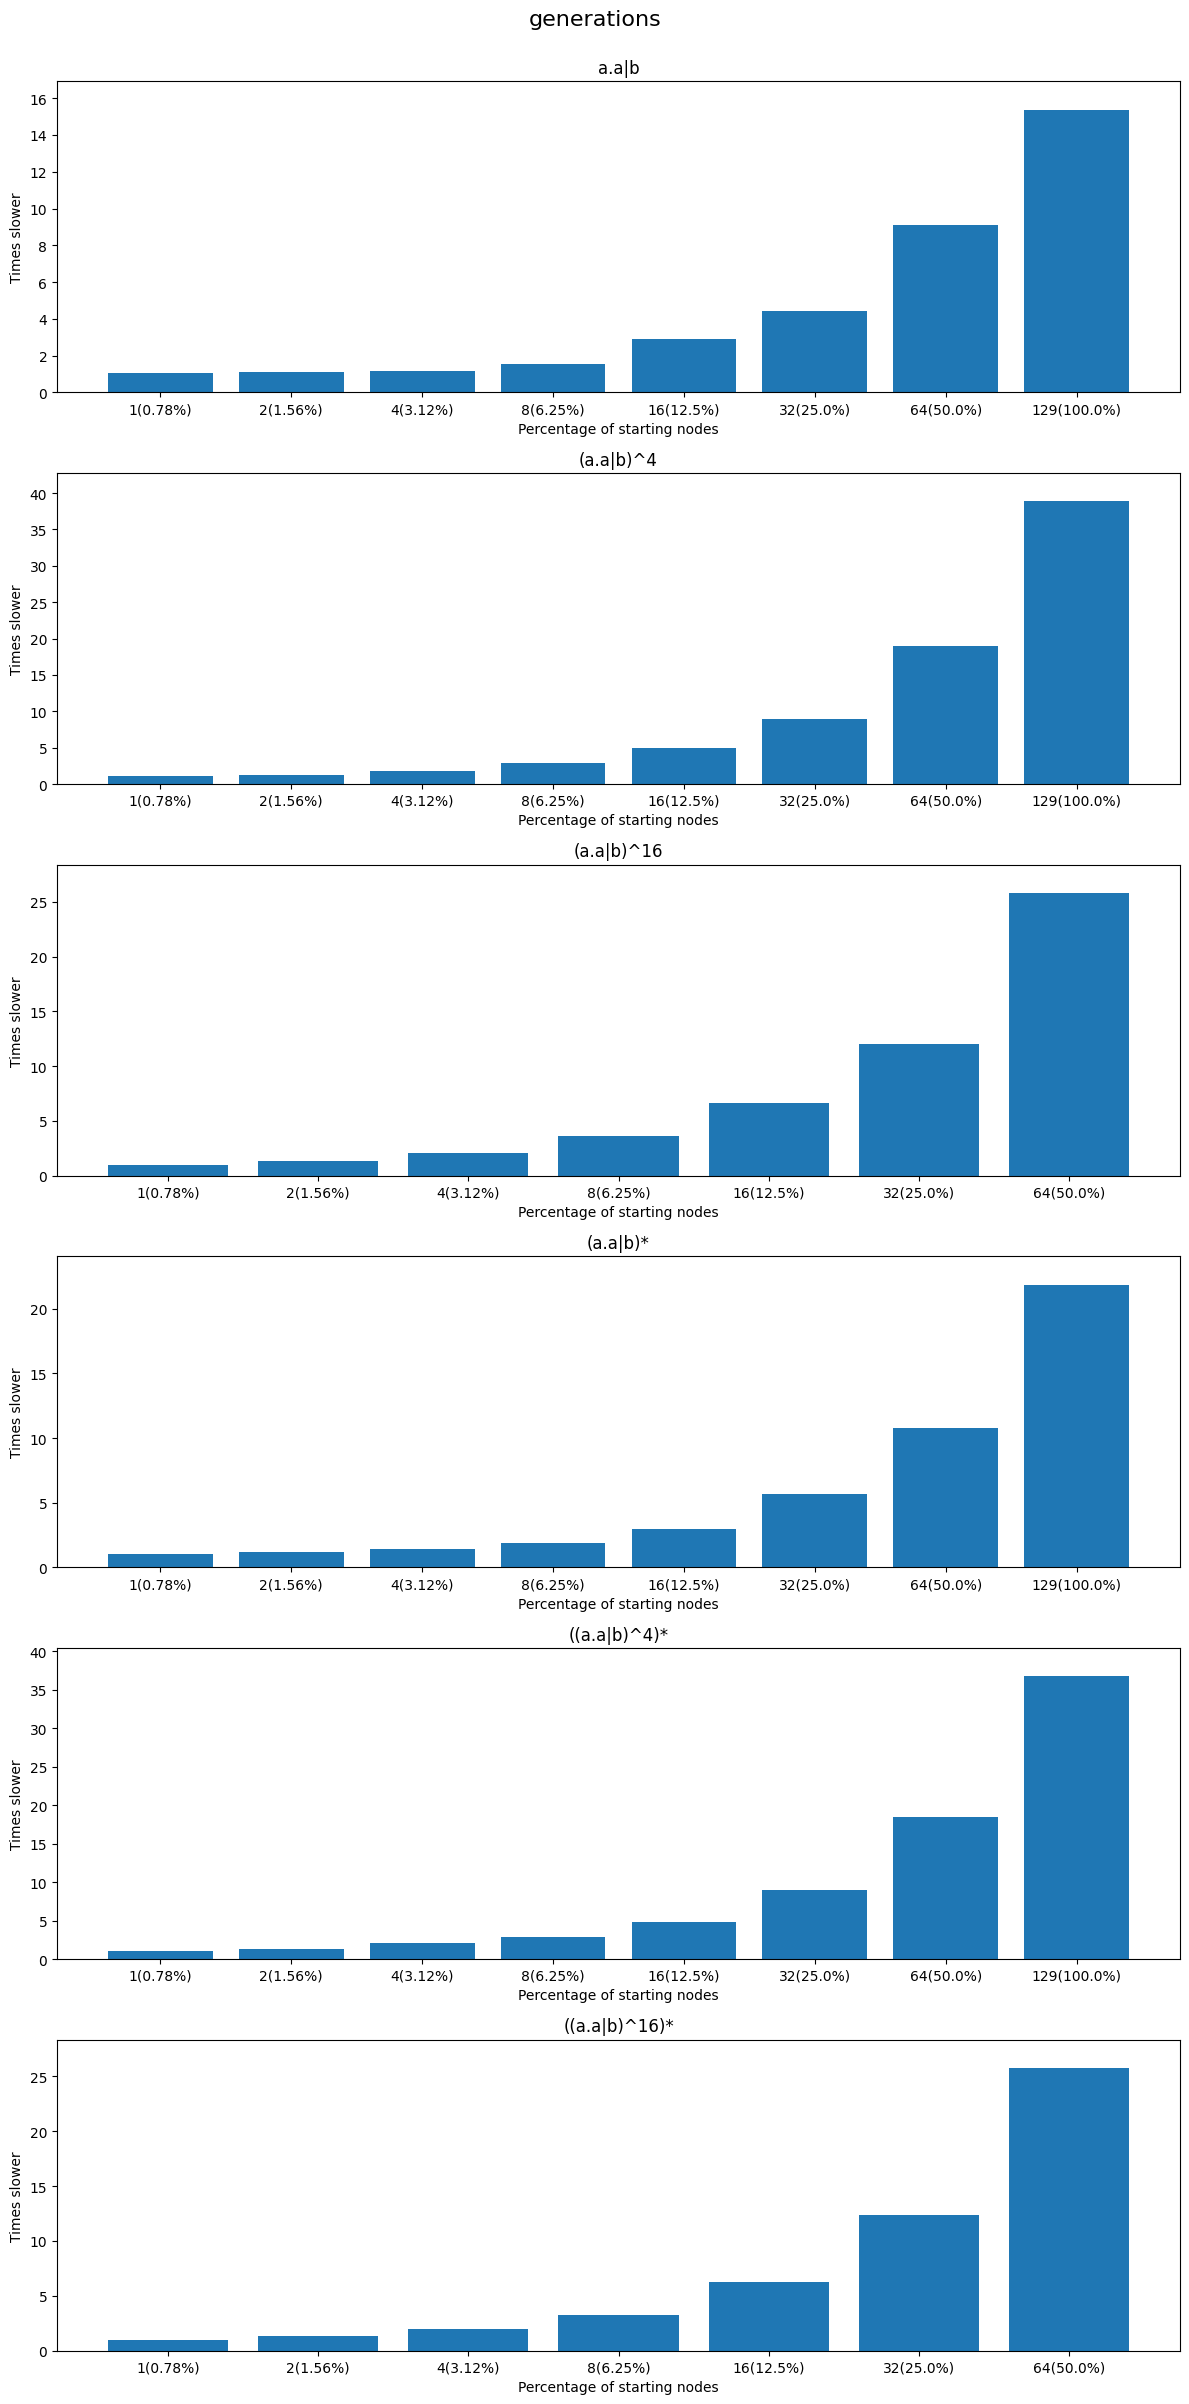

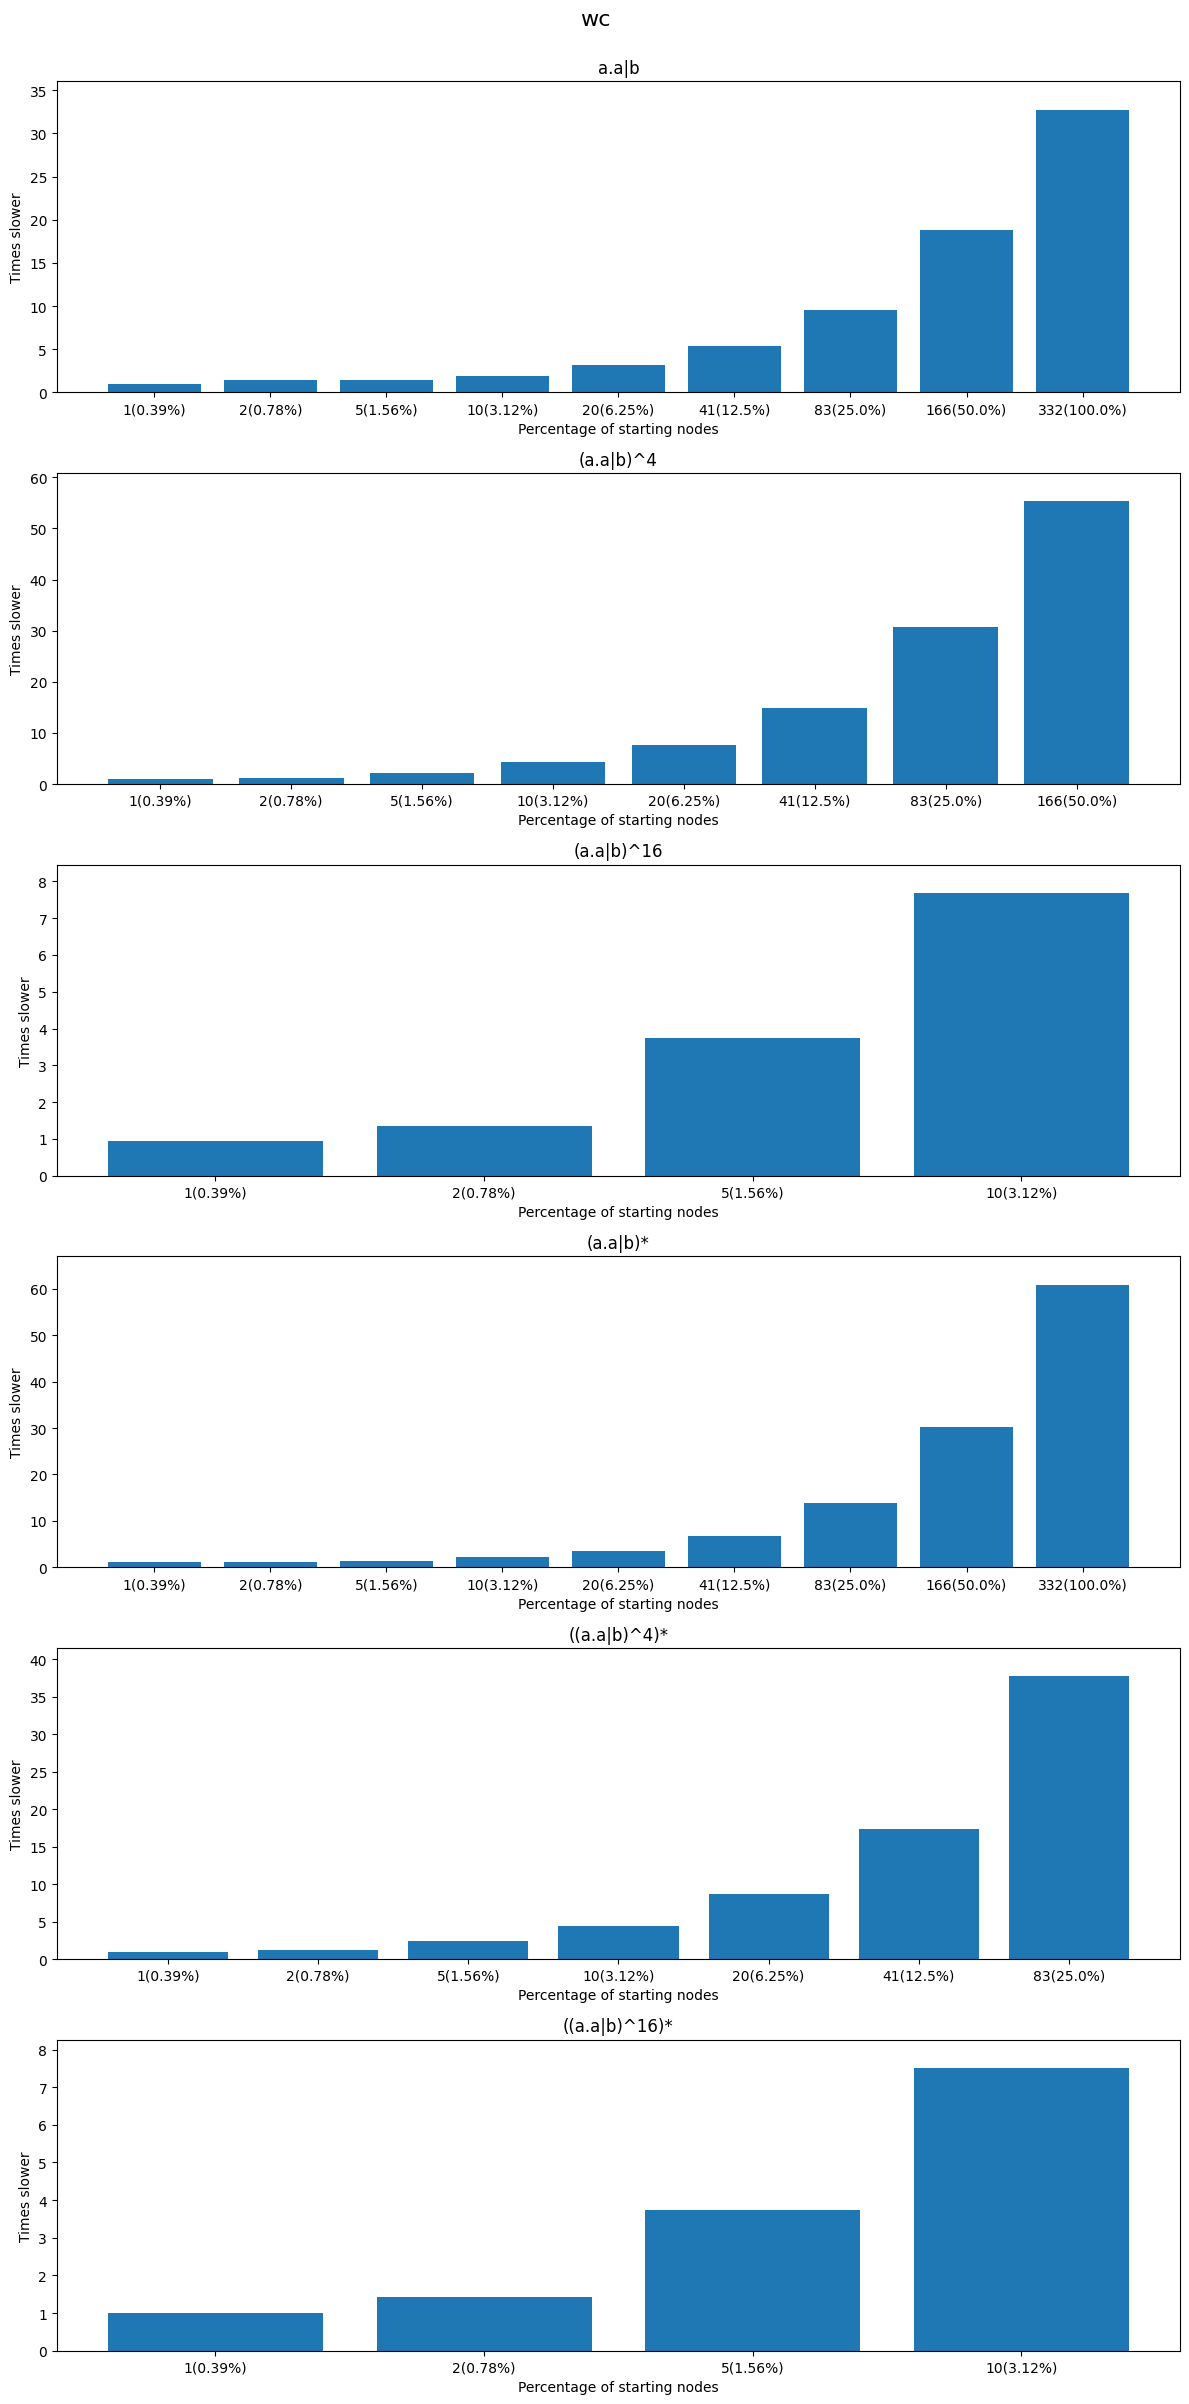

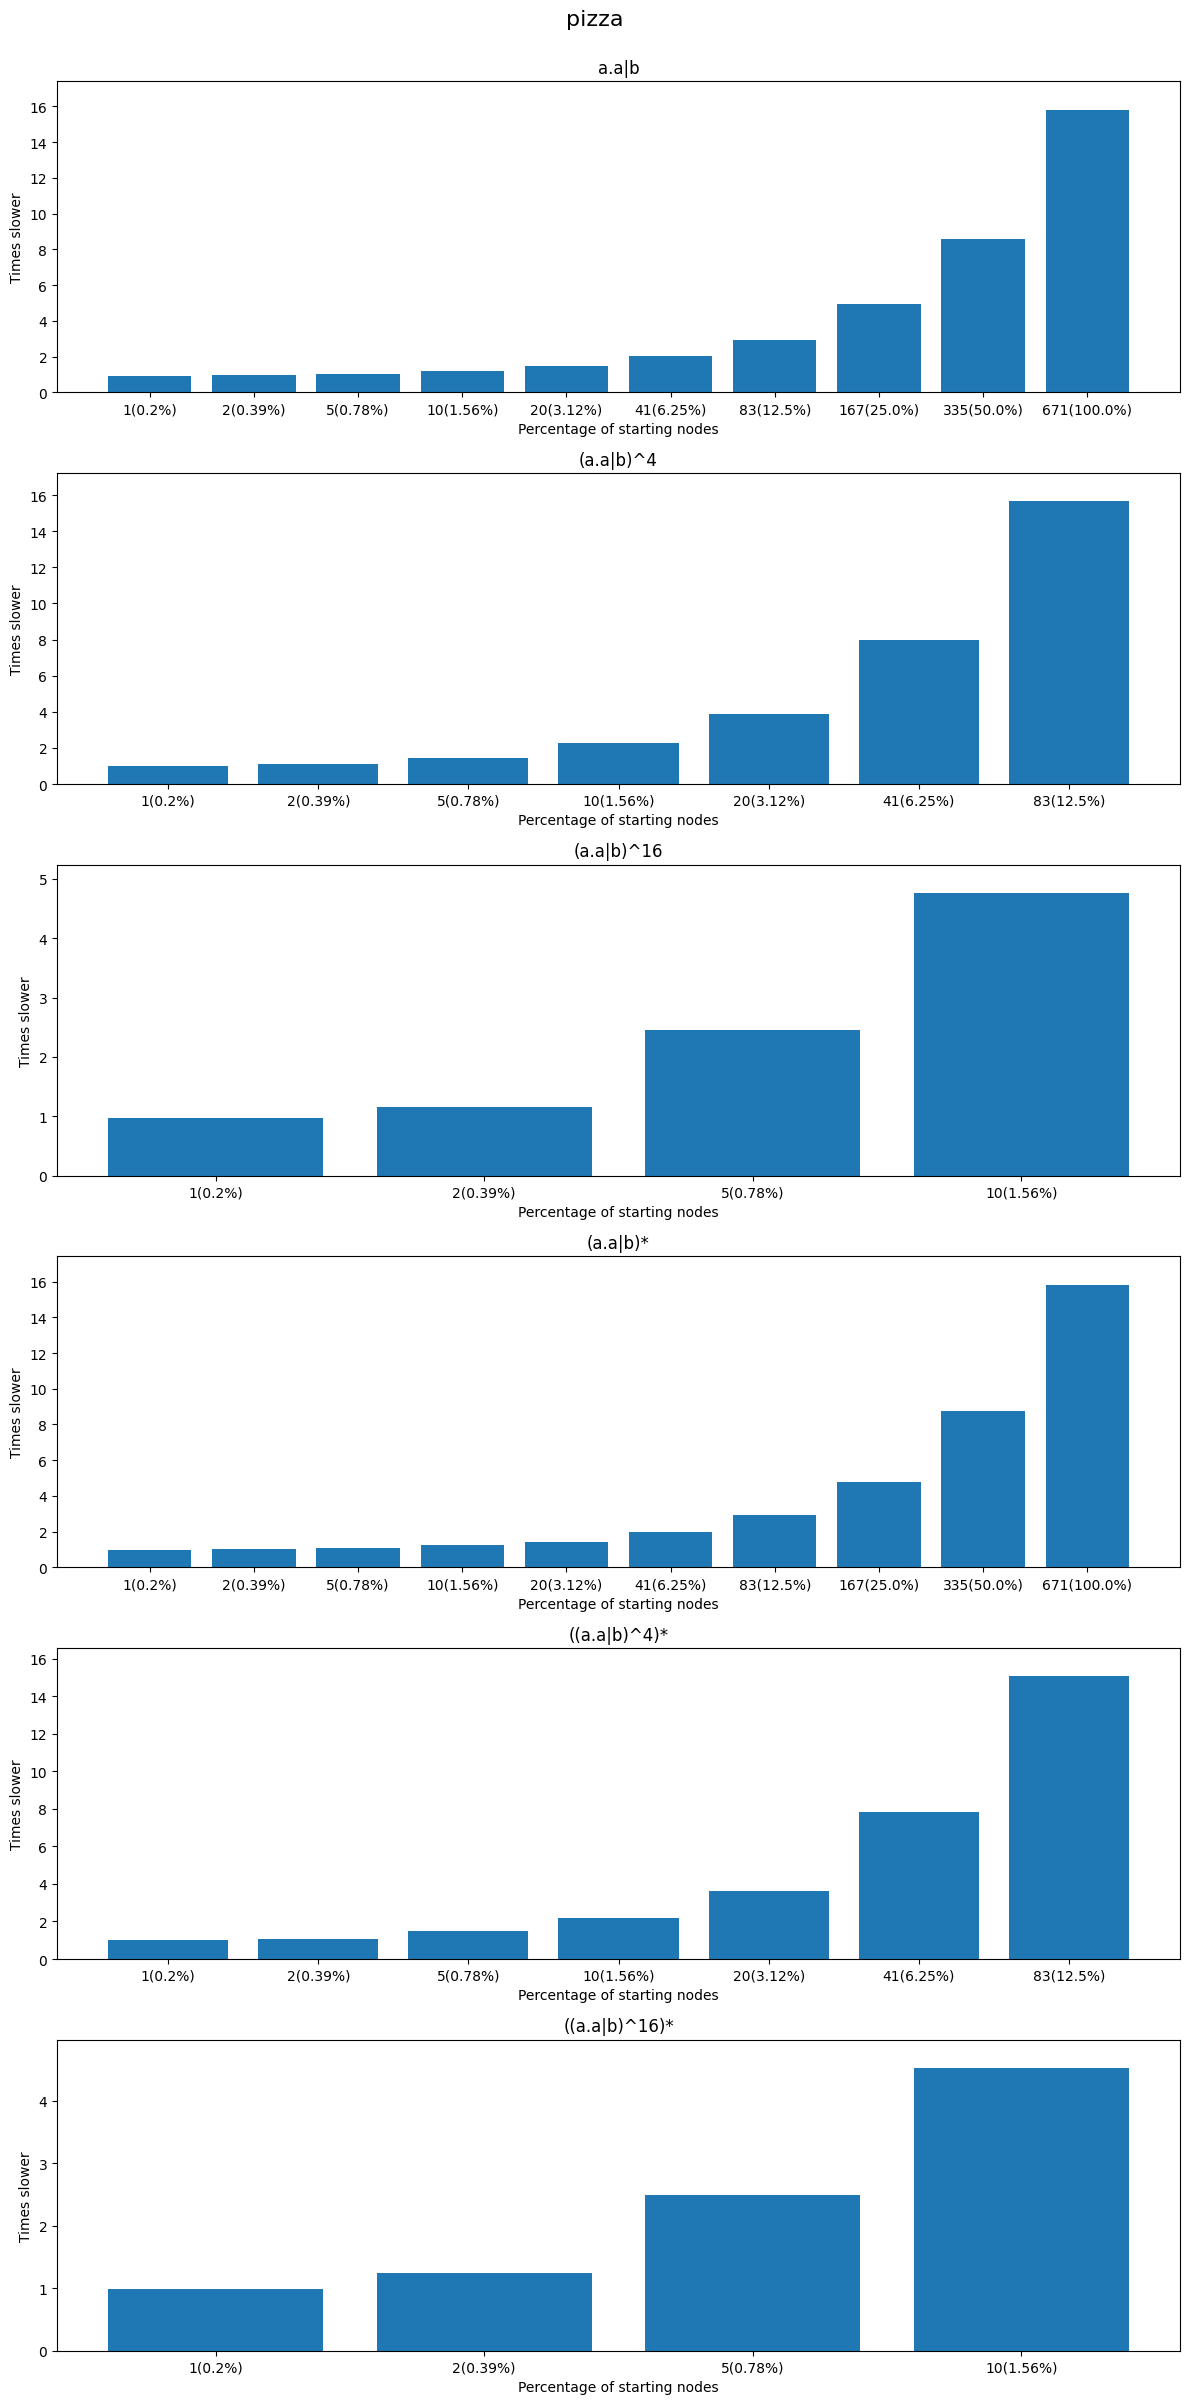

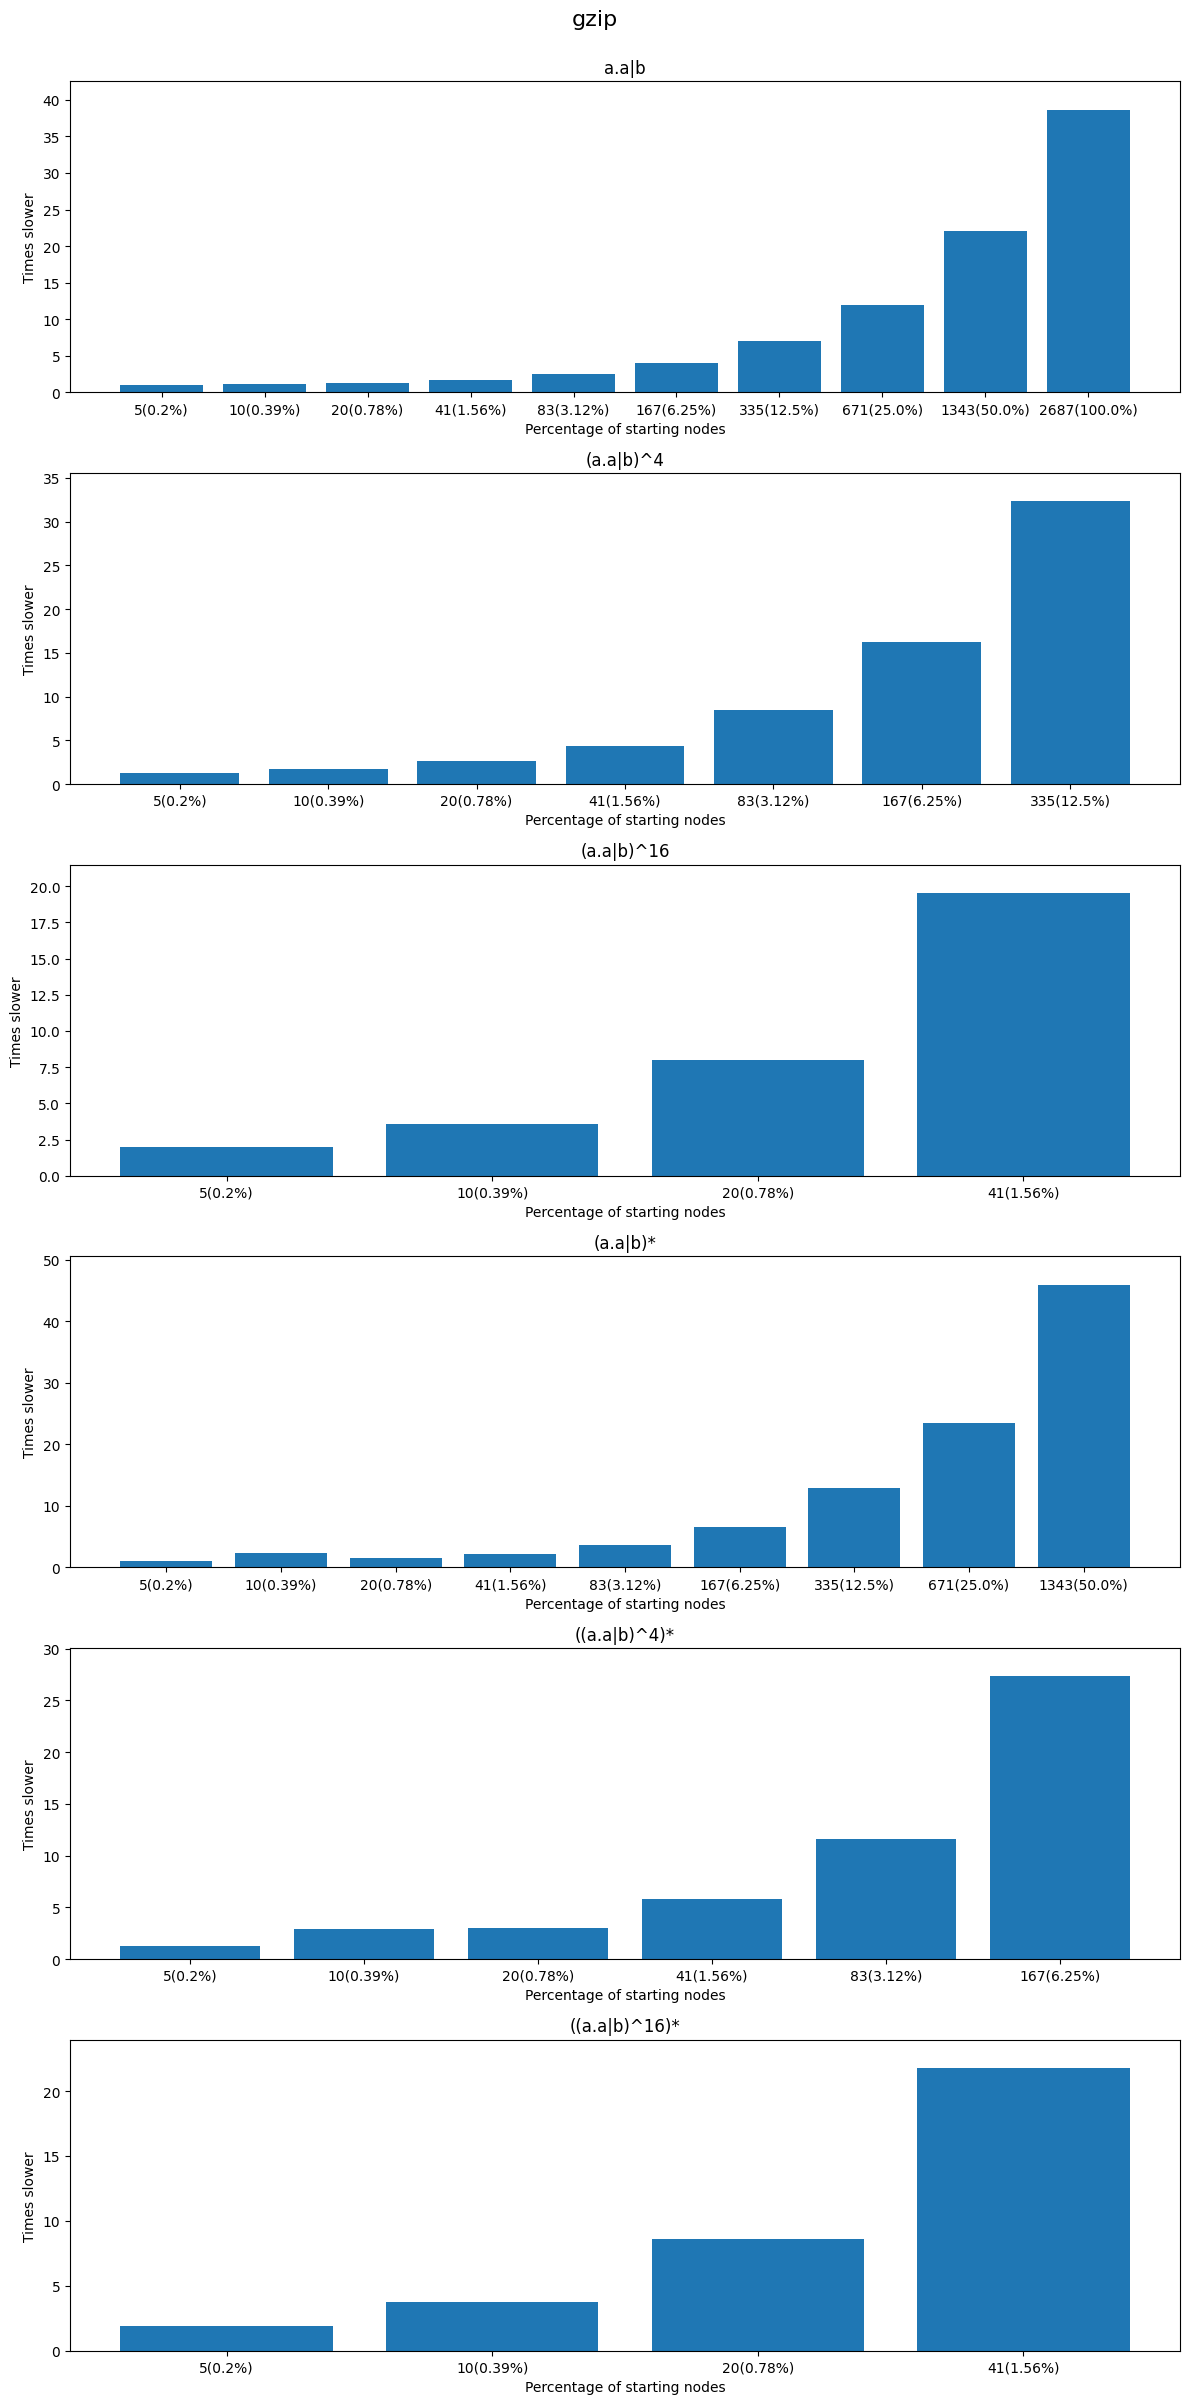

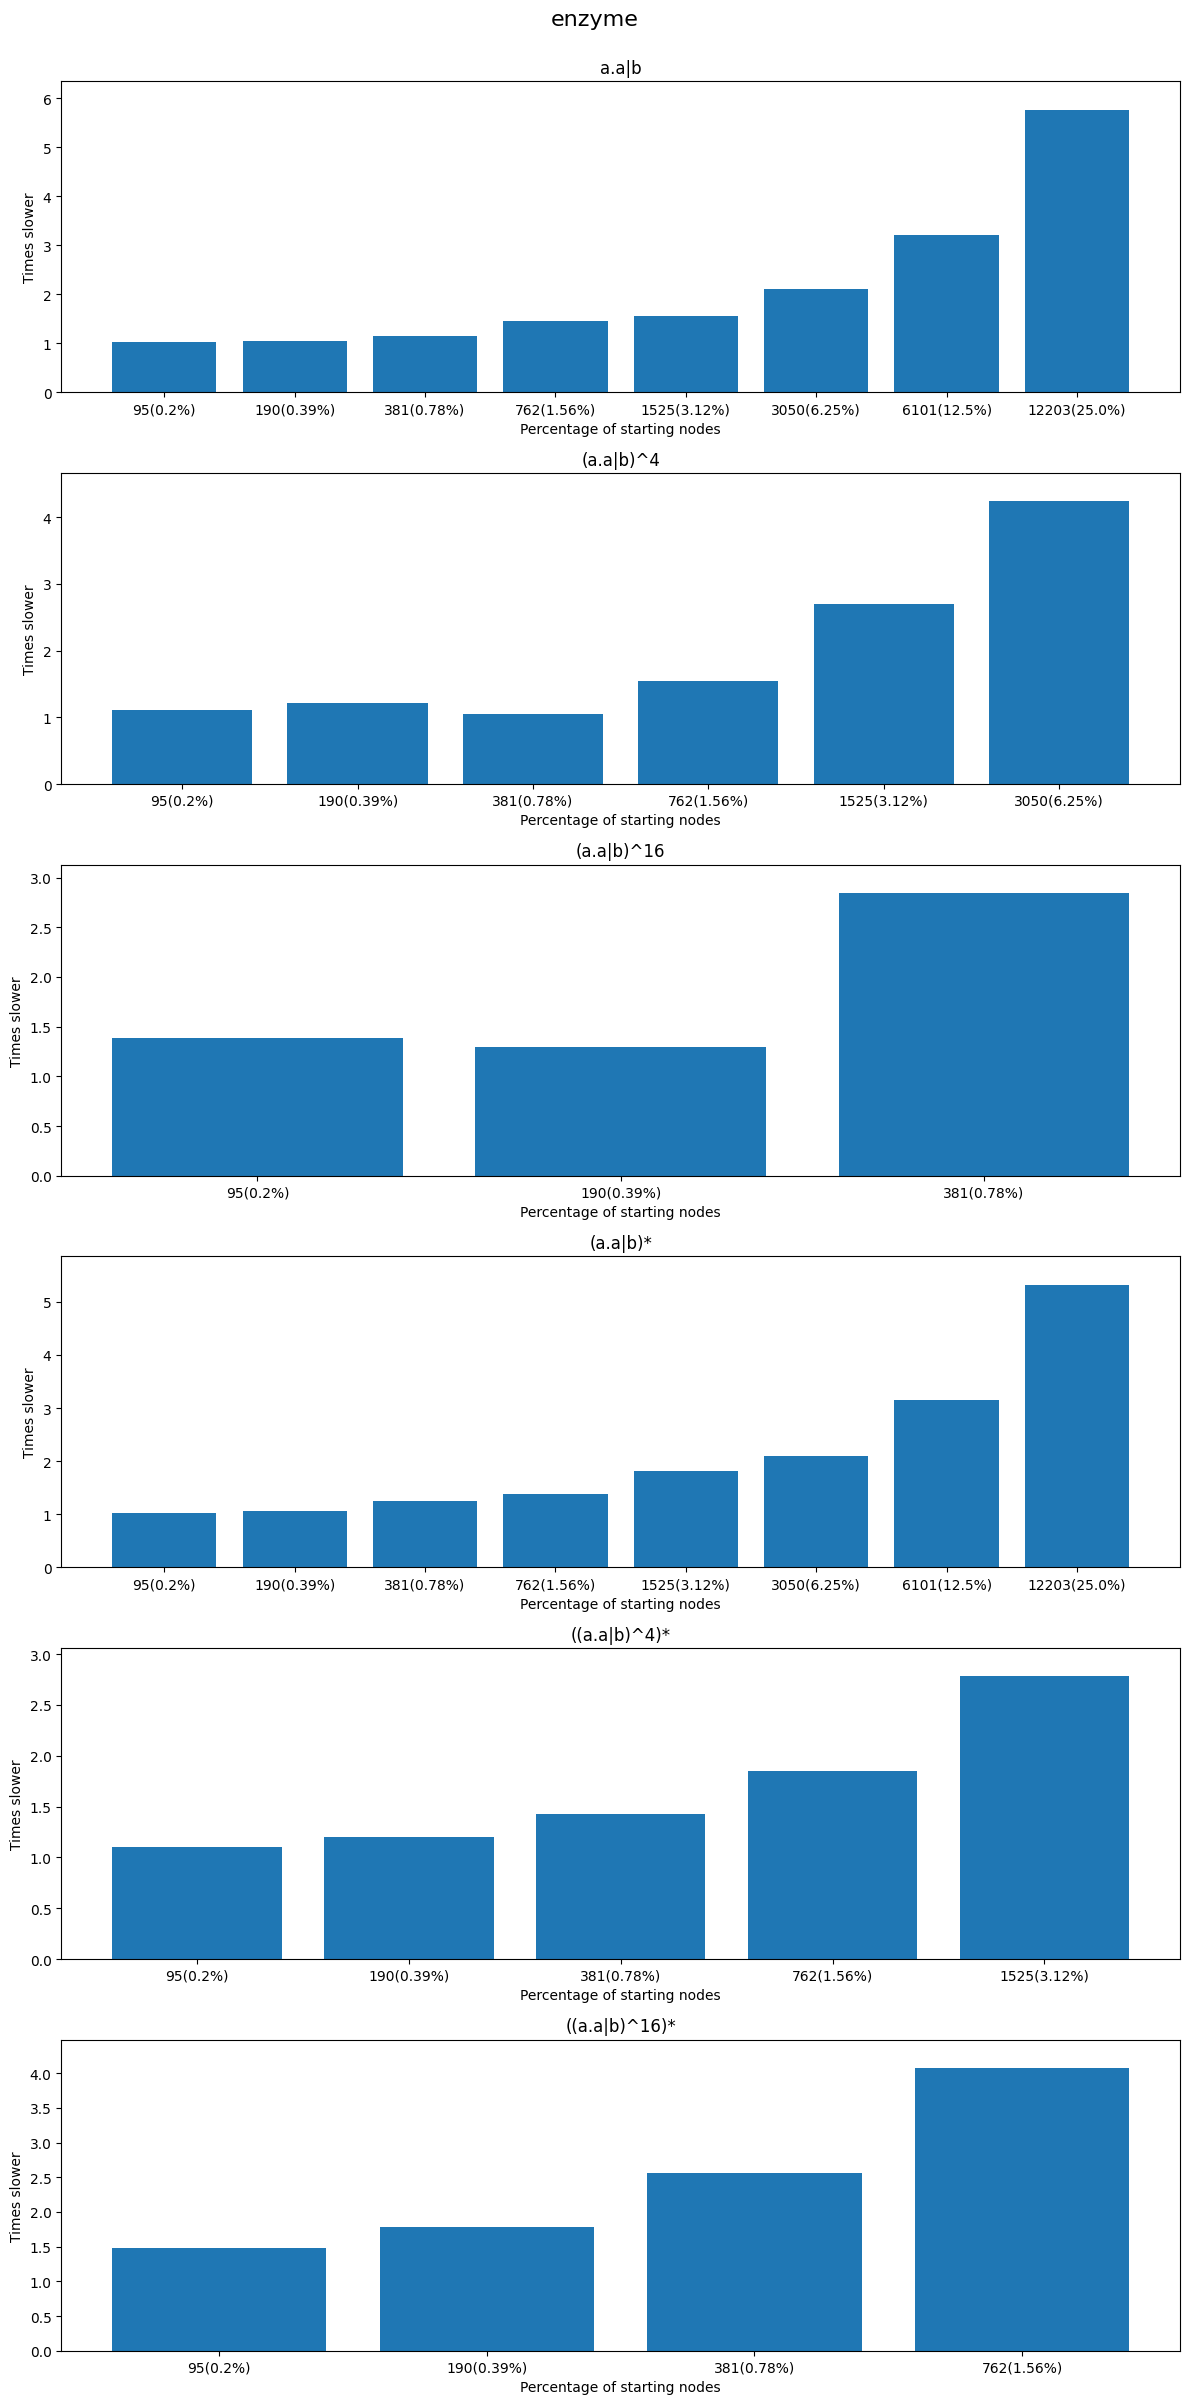

In [ ]:
for graph_name in GRAPHS:
    fig, axs = plt.subplots(nrows=len(REGEXES), figsize=(12, 4 * len(REGEXES)))
    fig.suptitle(graph_name, y=1, fontsize=16)
    graph = get_graph(graph_name)
    nodes_total = graph.number_of_nodes()
    starting_percentages = get_starting_percentages_for_graph(graph)
    for (ax, (regex_name, _)) in zip(axs, REGEXES):
        ax: plt.Axes = ax
        ax.set_title(regex_name)
        ax.set_ylabel("Times slower")
        ax.set_xlabel("Percentage of starting nodes")
        ax.xaxis.set_major_formatter(ScalarFormatter())
        label_positions = np.arange(len(starting_percentages))
        ax.set_xticks(
            label_positions,
            [
                f"{int(nodes_total / 100 * percent)}({round(percent, 2)}%)"
                for percent in sorted(starting_percentages)
            ],
            fontsize=10,
        )
        ys = [
            res[
                (
                    get_multiple_source_rpq_algorithm_name(
                        group_by_start=True, starting_percentage=starting_percentage
                    ),
                    graph_name,
                    regex_name,
                    "pygraphblas",
                )
            ][0]
            / res[
                (
                    get_multiple_source_rpq_algorithm_name(
                        group_by_start=False,
                        starting_percentage=starting_percentage,
                    ),
                    graph_name,
                    regex_name,
                    "pygraphblas",
                )
            ][0]
            for starting_percentage in sorted(starting_percentages)
        ]
        if len(list(finites(ys))) > 0:
            ax.bar(x=label_positions, height=ys)
        ax.set_ylim(bottom=0, top=1.1 * max(list(finites(ys)) + [1]))
    fig.tight_layout()
    plt.show()

Можно видеть, что при достаточно больших относительных размеров стартового множества замедление достигает десятки раз (для наиболее больших графов и запросов, столбцы, соответствующие достаточно большим относительным размерам стартовых множеств не показаны, так как более медленная реализация не завершила работу за отведённое время).

<br/>

Однако стоит отметить, что использовать решение третьей вариации задачи целесообразно только для достаточно маленьких относительных размеров стартового множества, а в остальных случаях, как было выяснено ранее, стоит использовать решение первой вариации задачи. Для относительно же маленьких стартовых множеств замедление за редкими исключениями измеряется единицами, а не десятками раз, даже когда по абсолютному размеру стартовое множество превышает $1000$. Более детально это можно видеть на следующих обрезанных справа копиях предыдущих графиков.

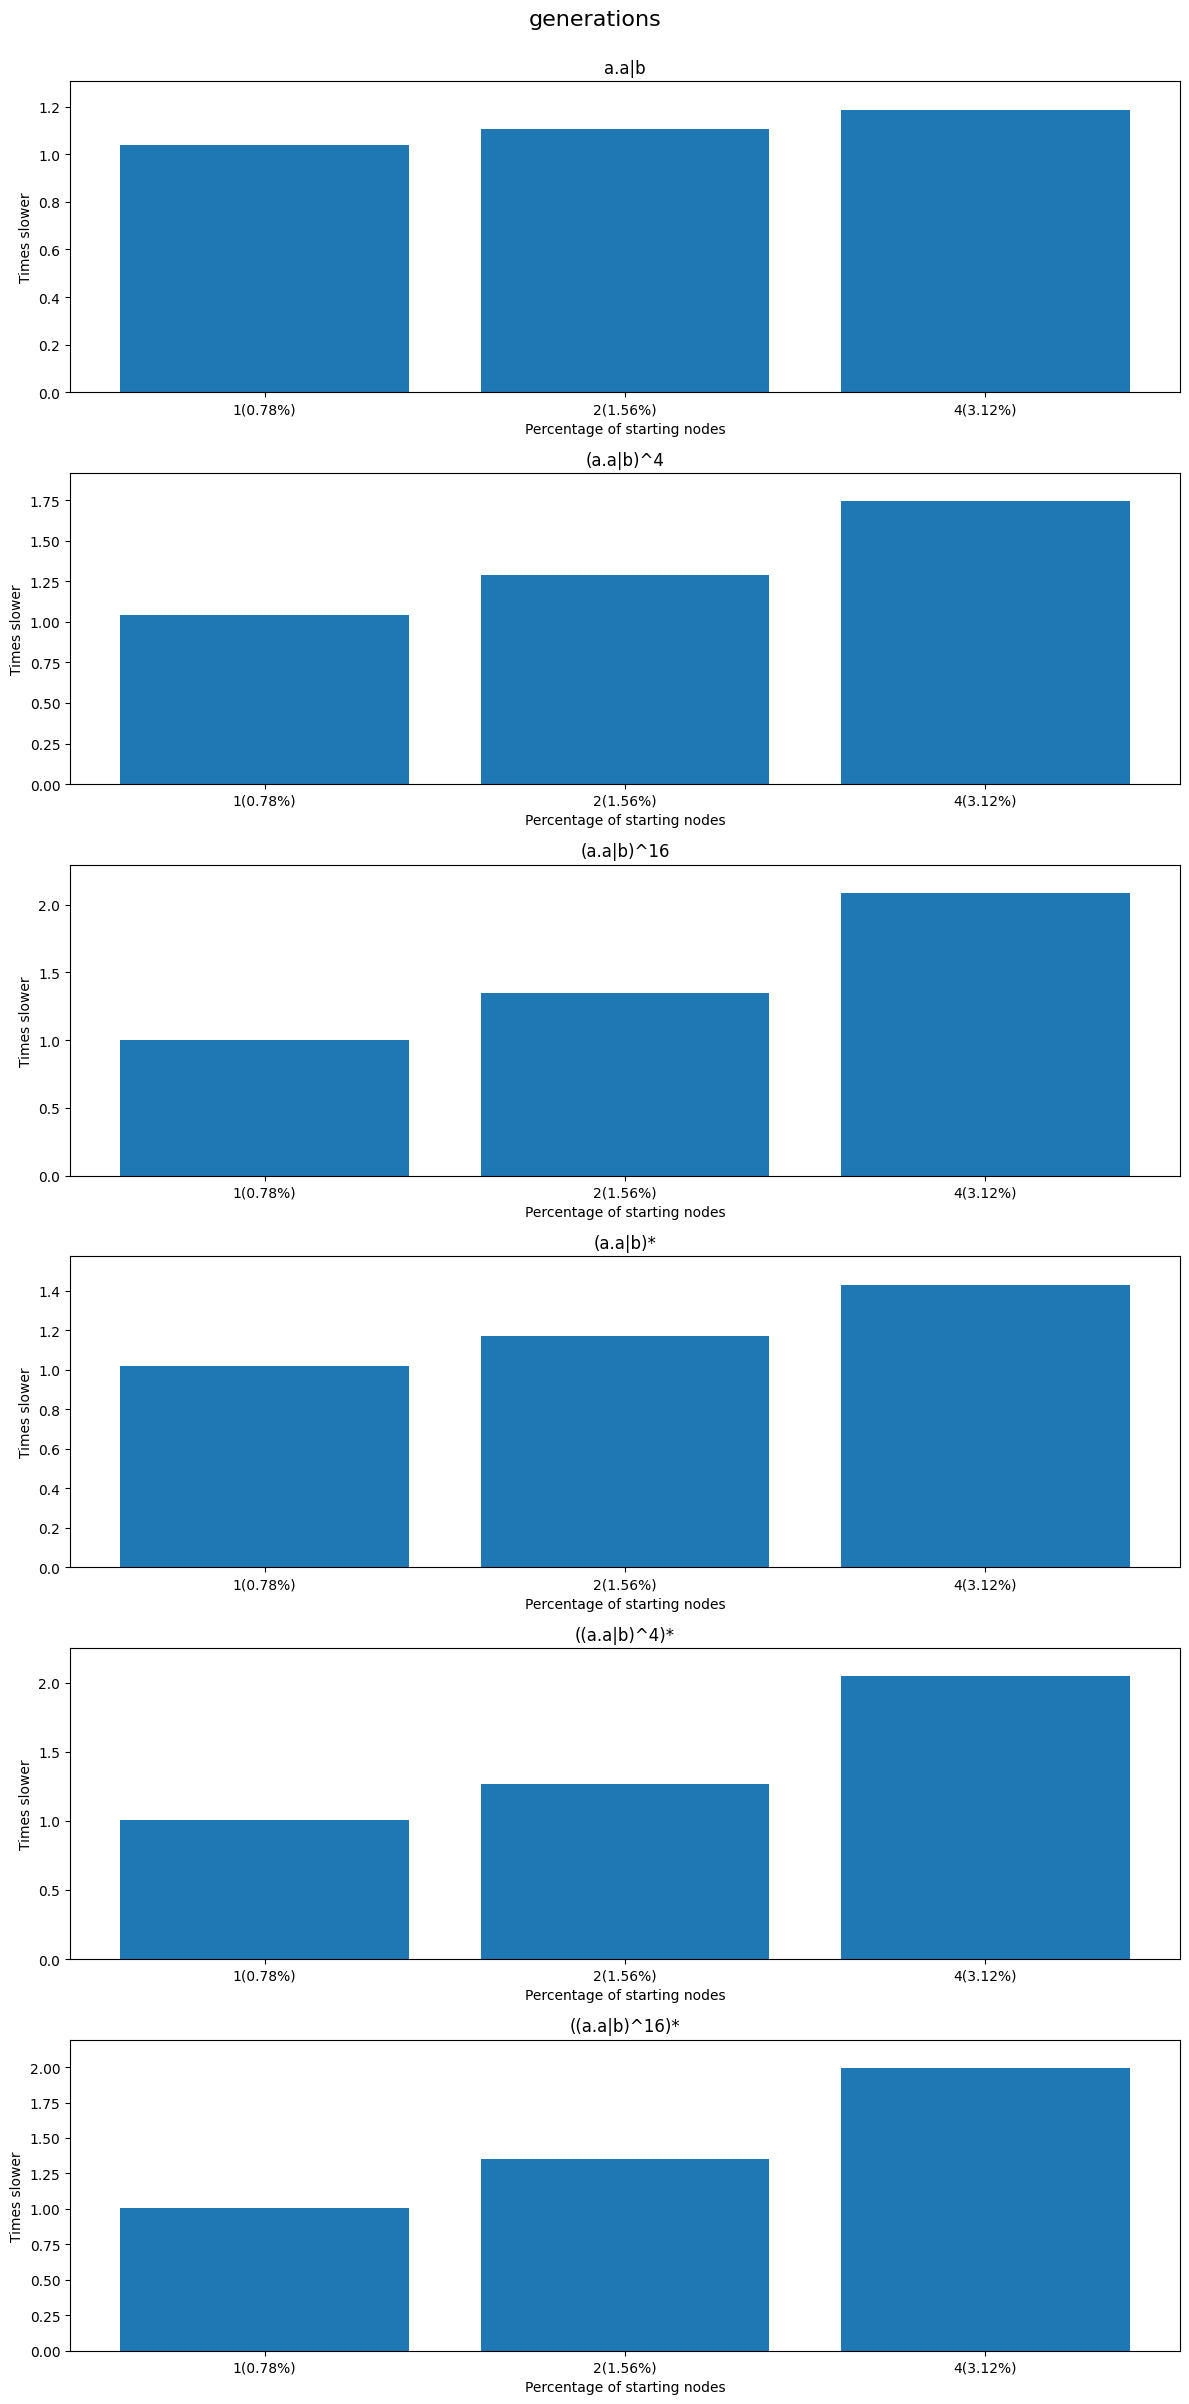

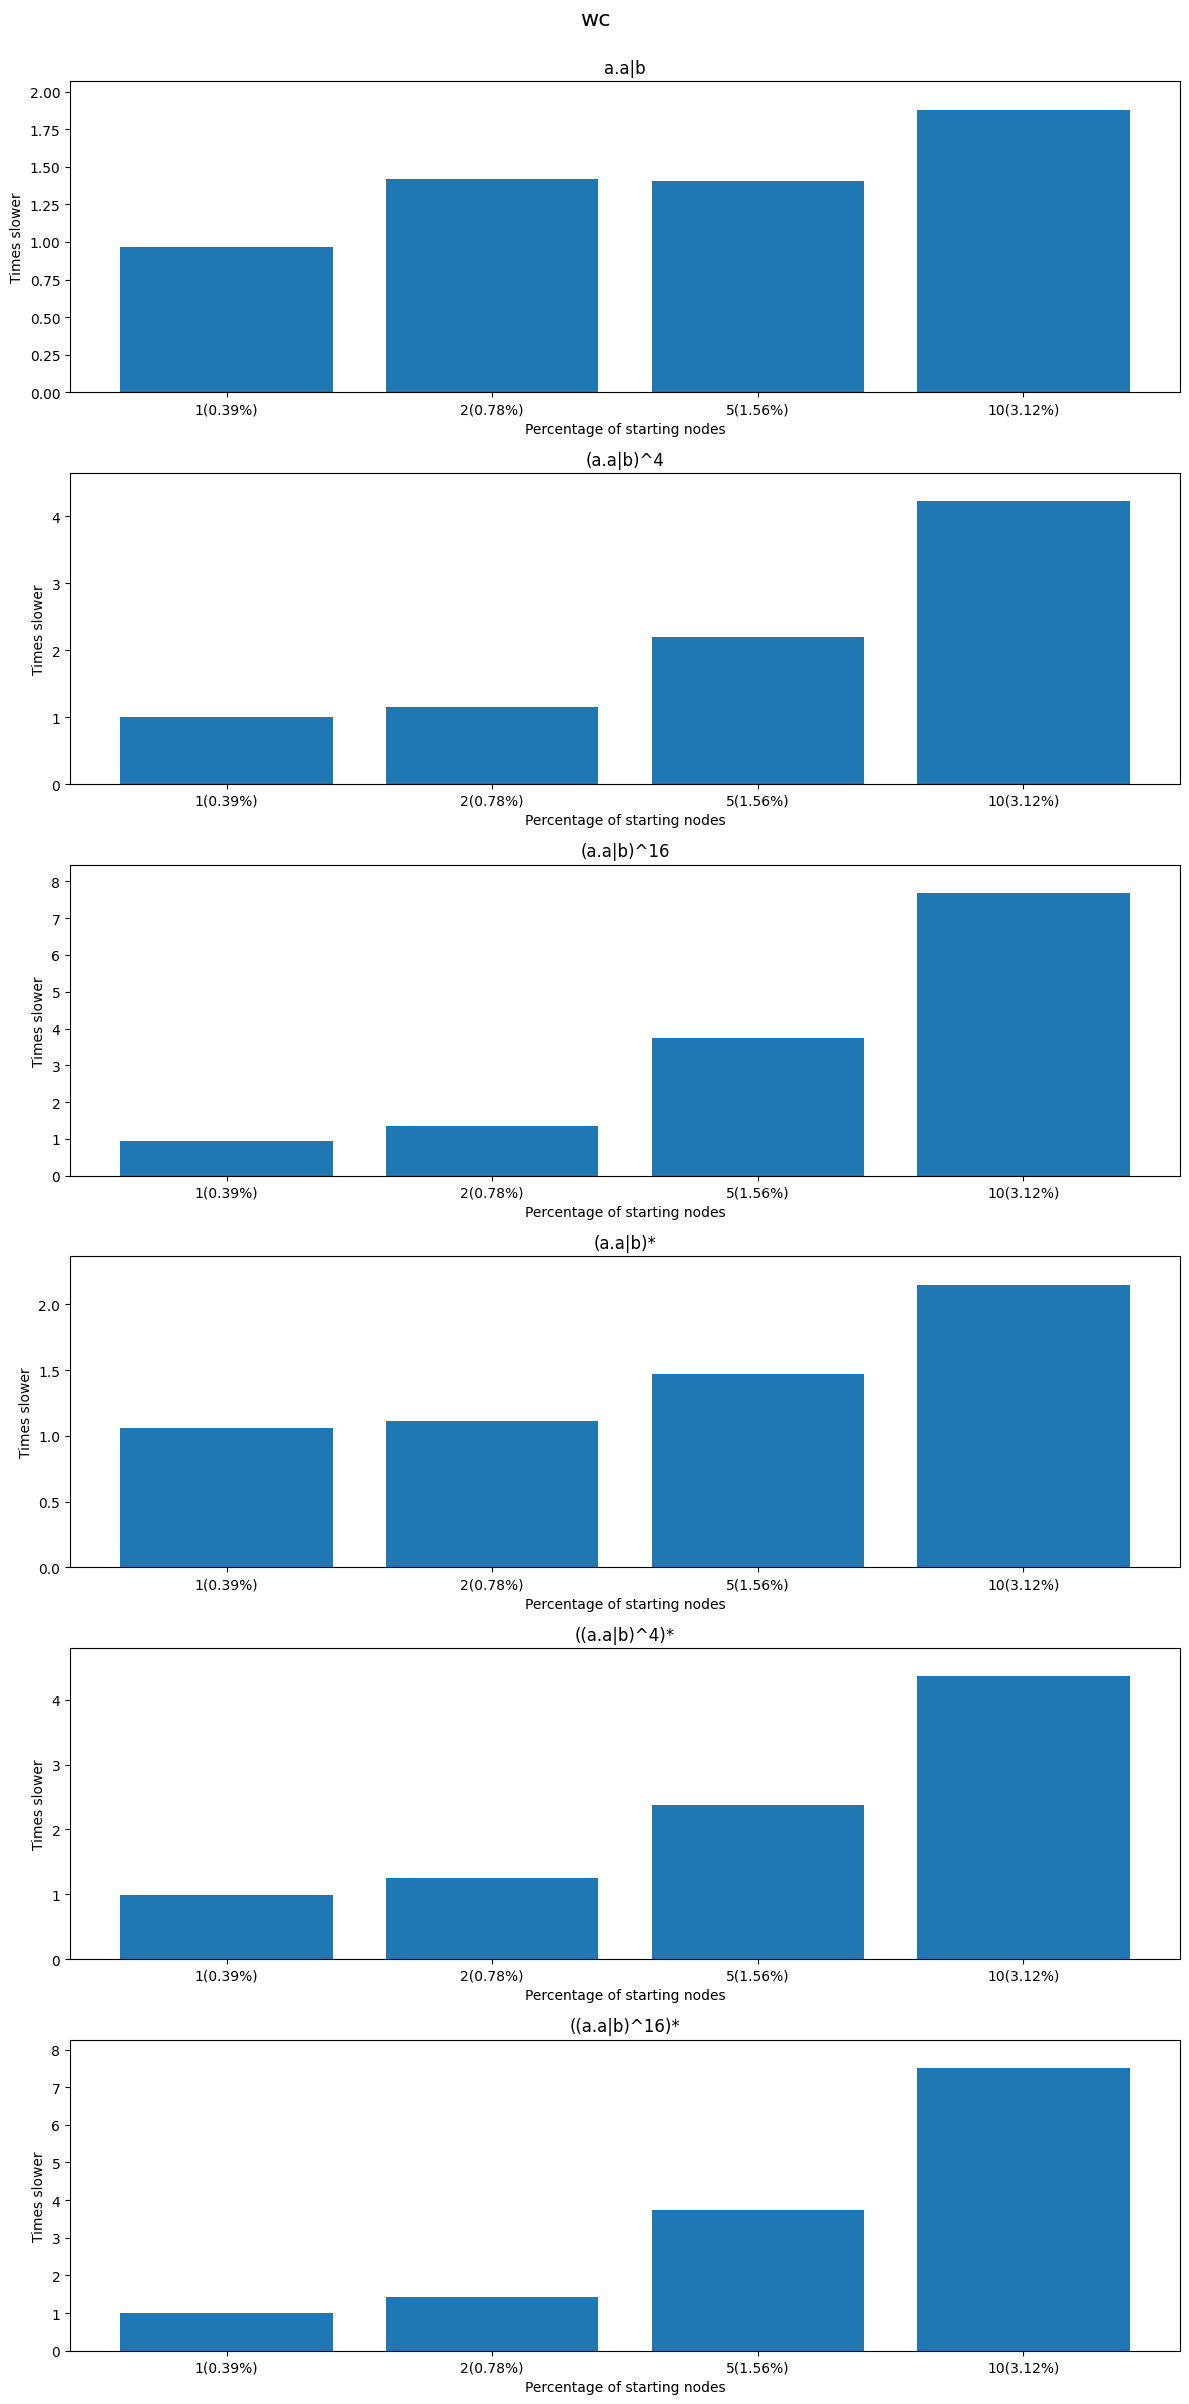

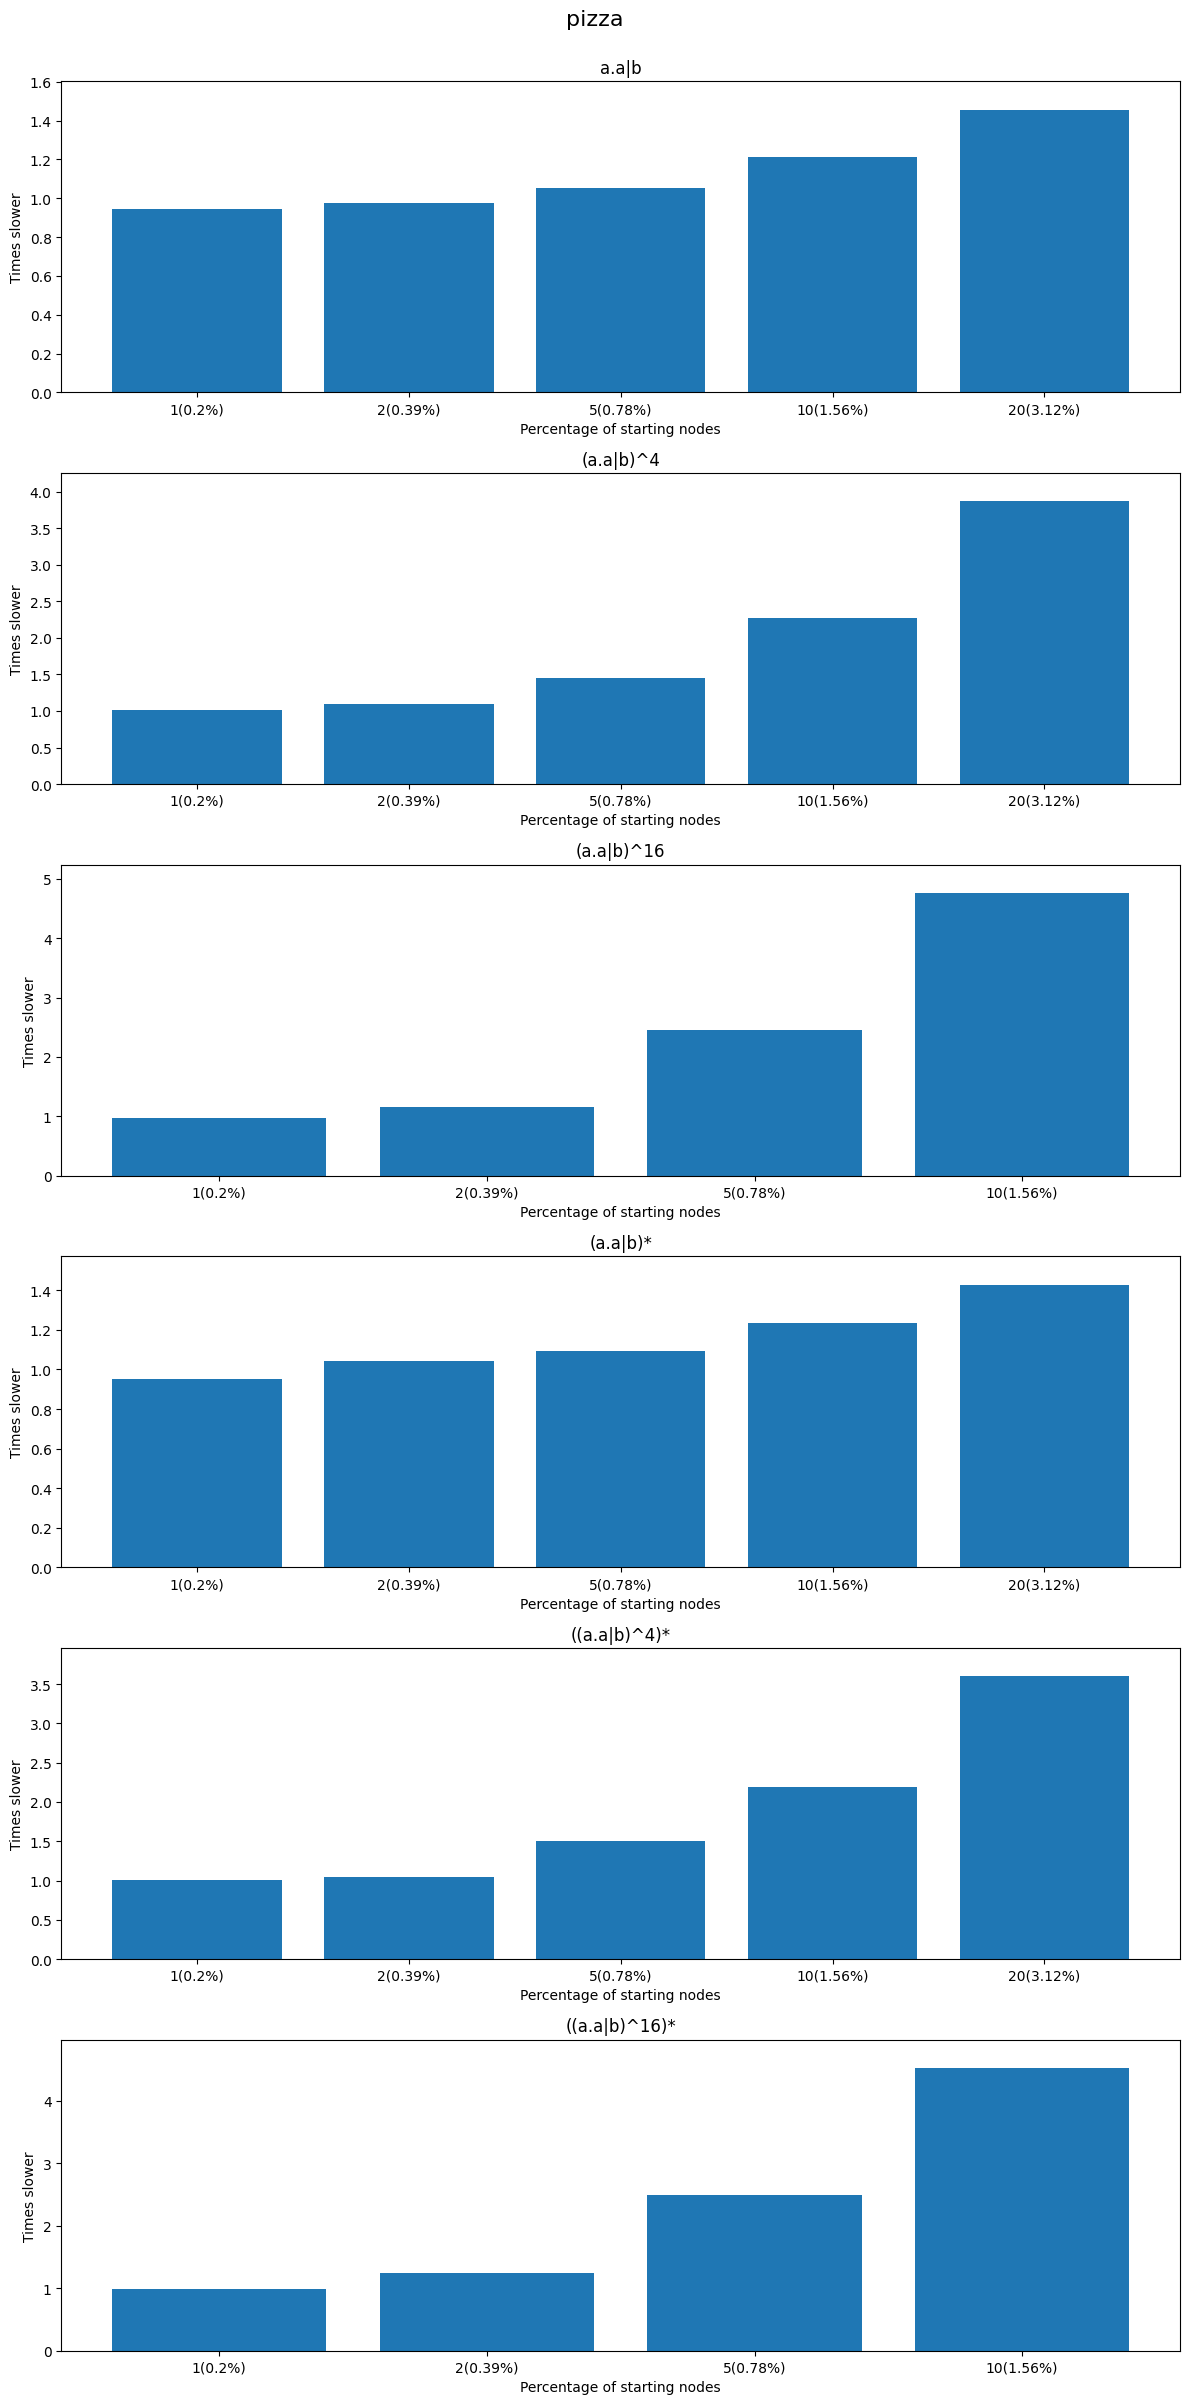

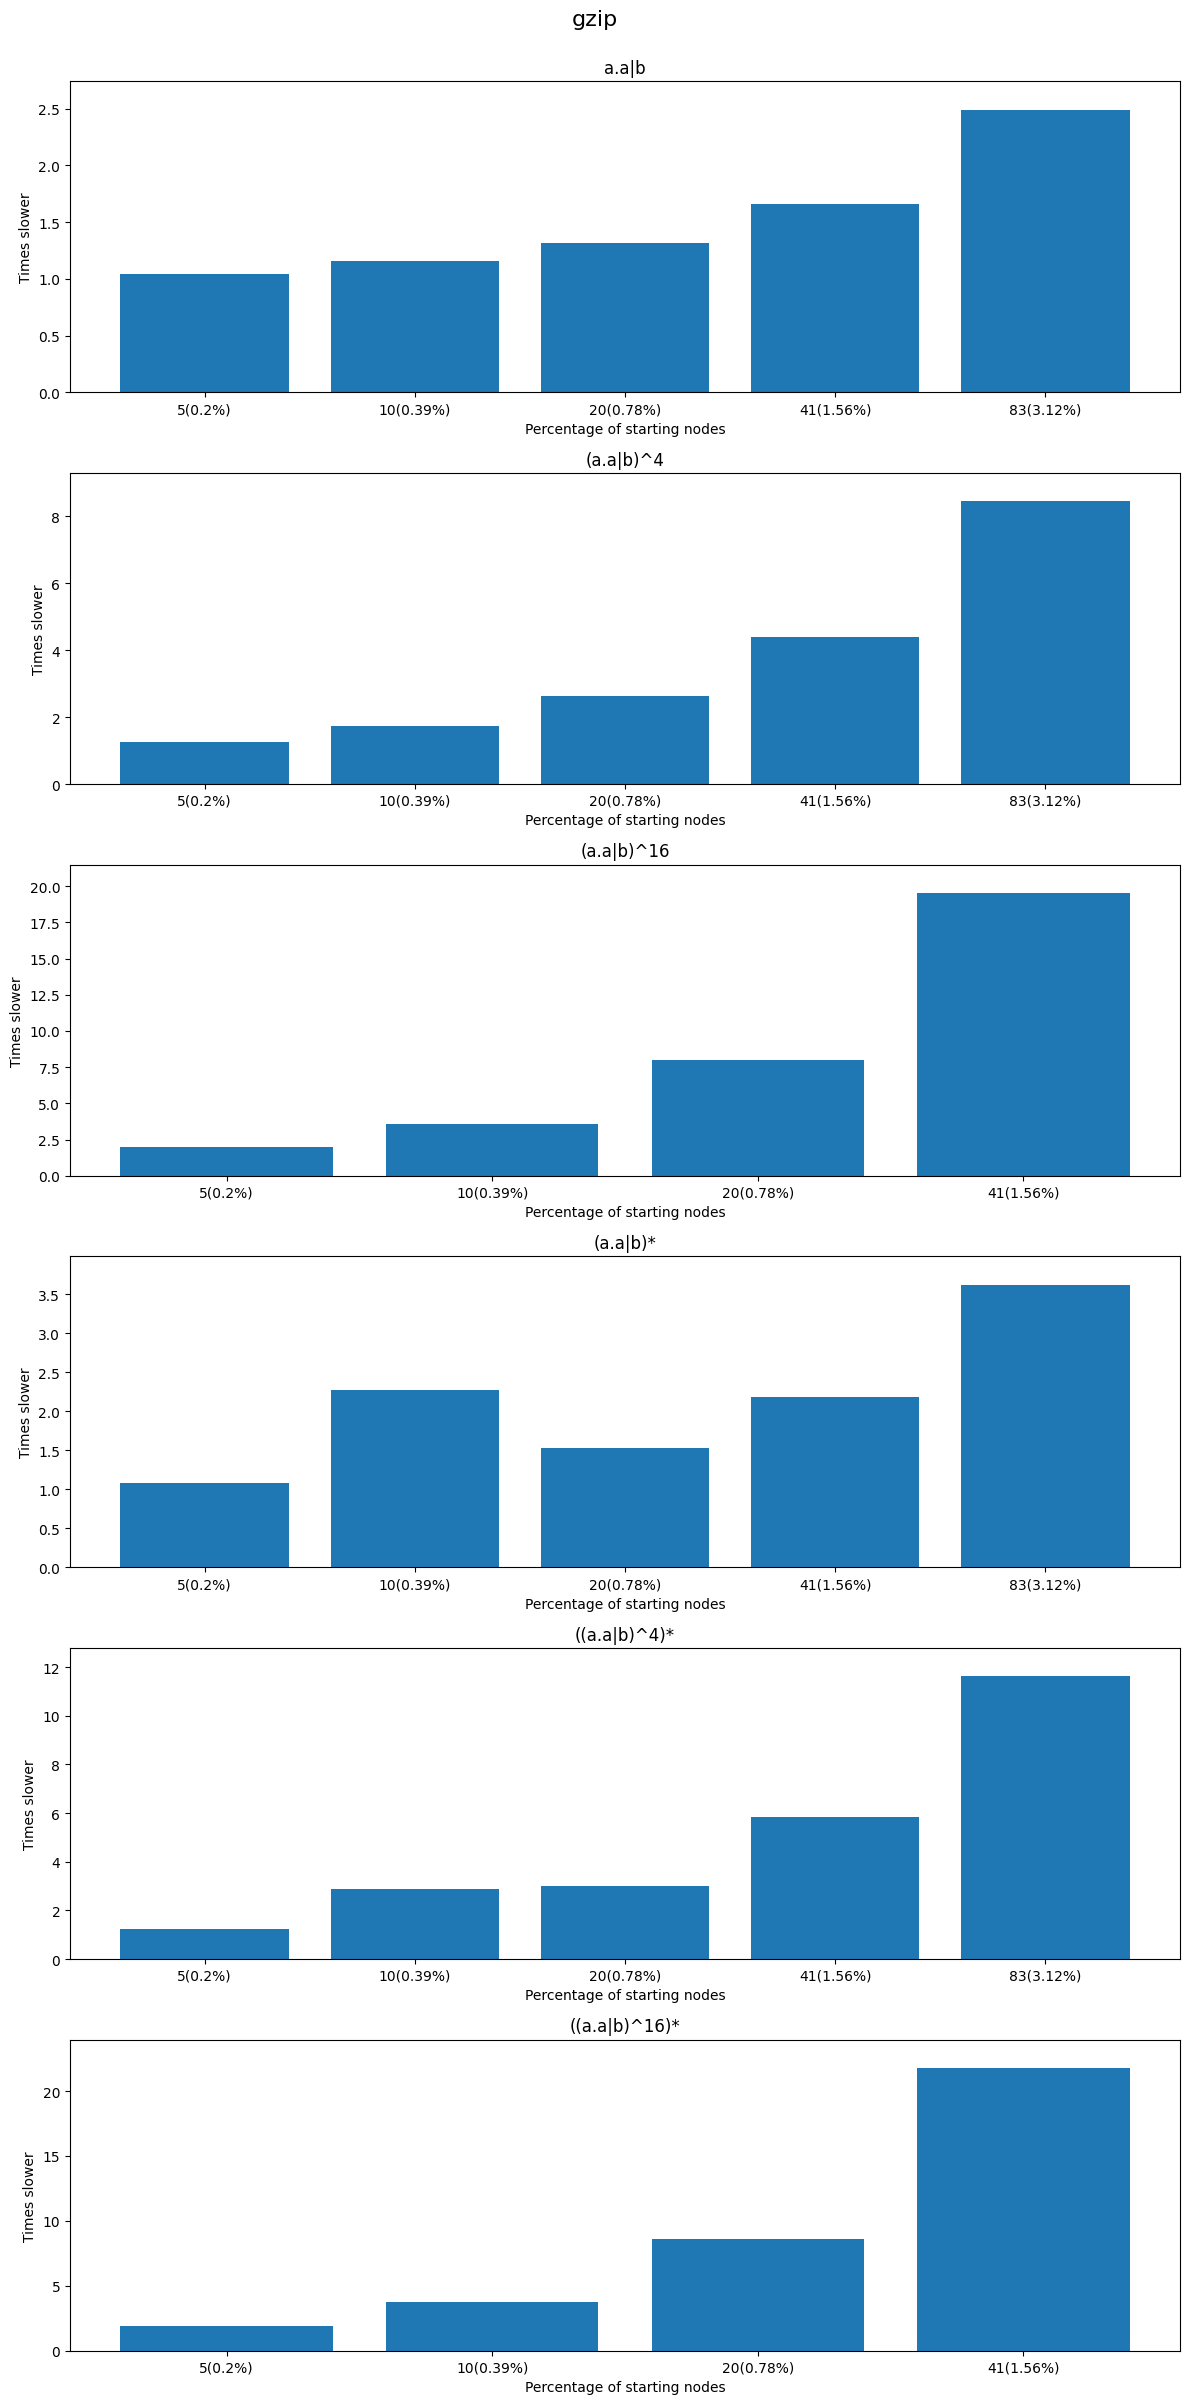

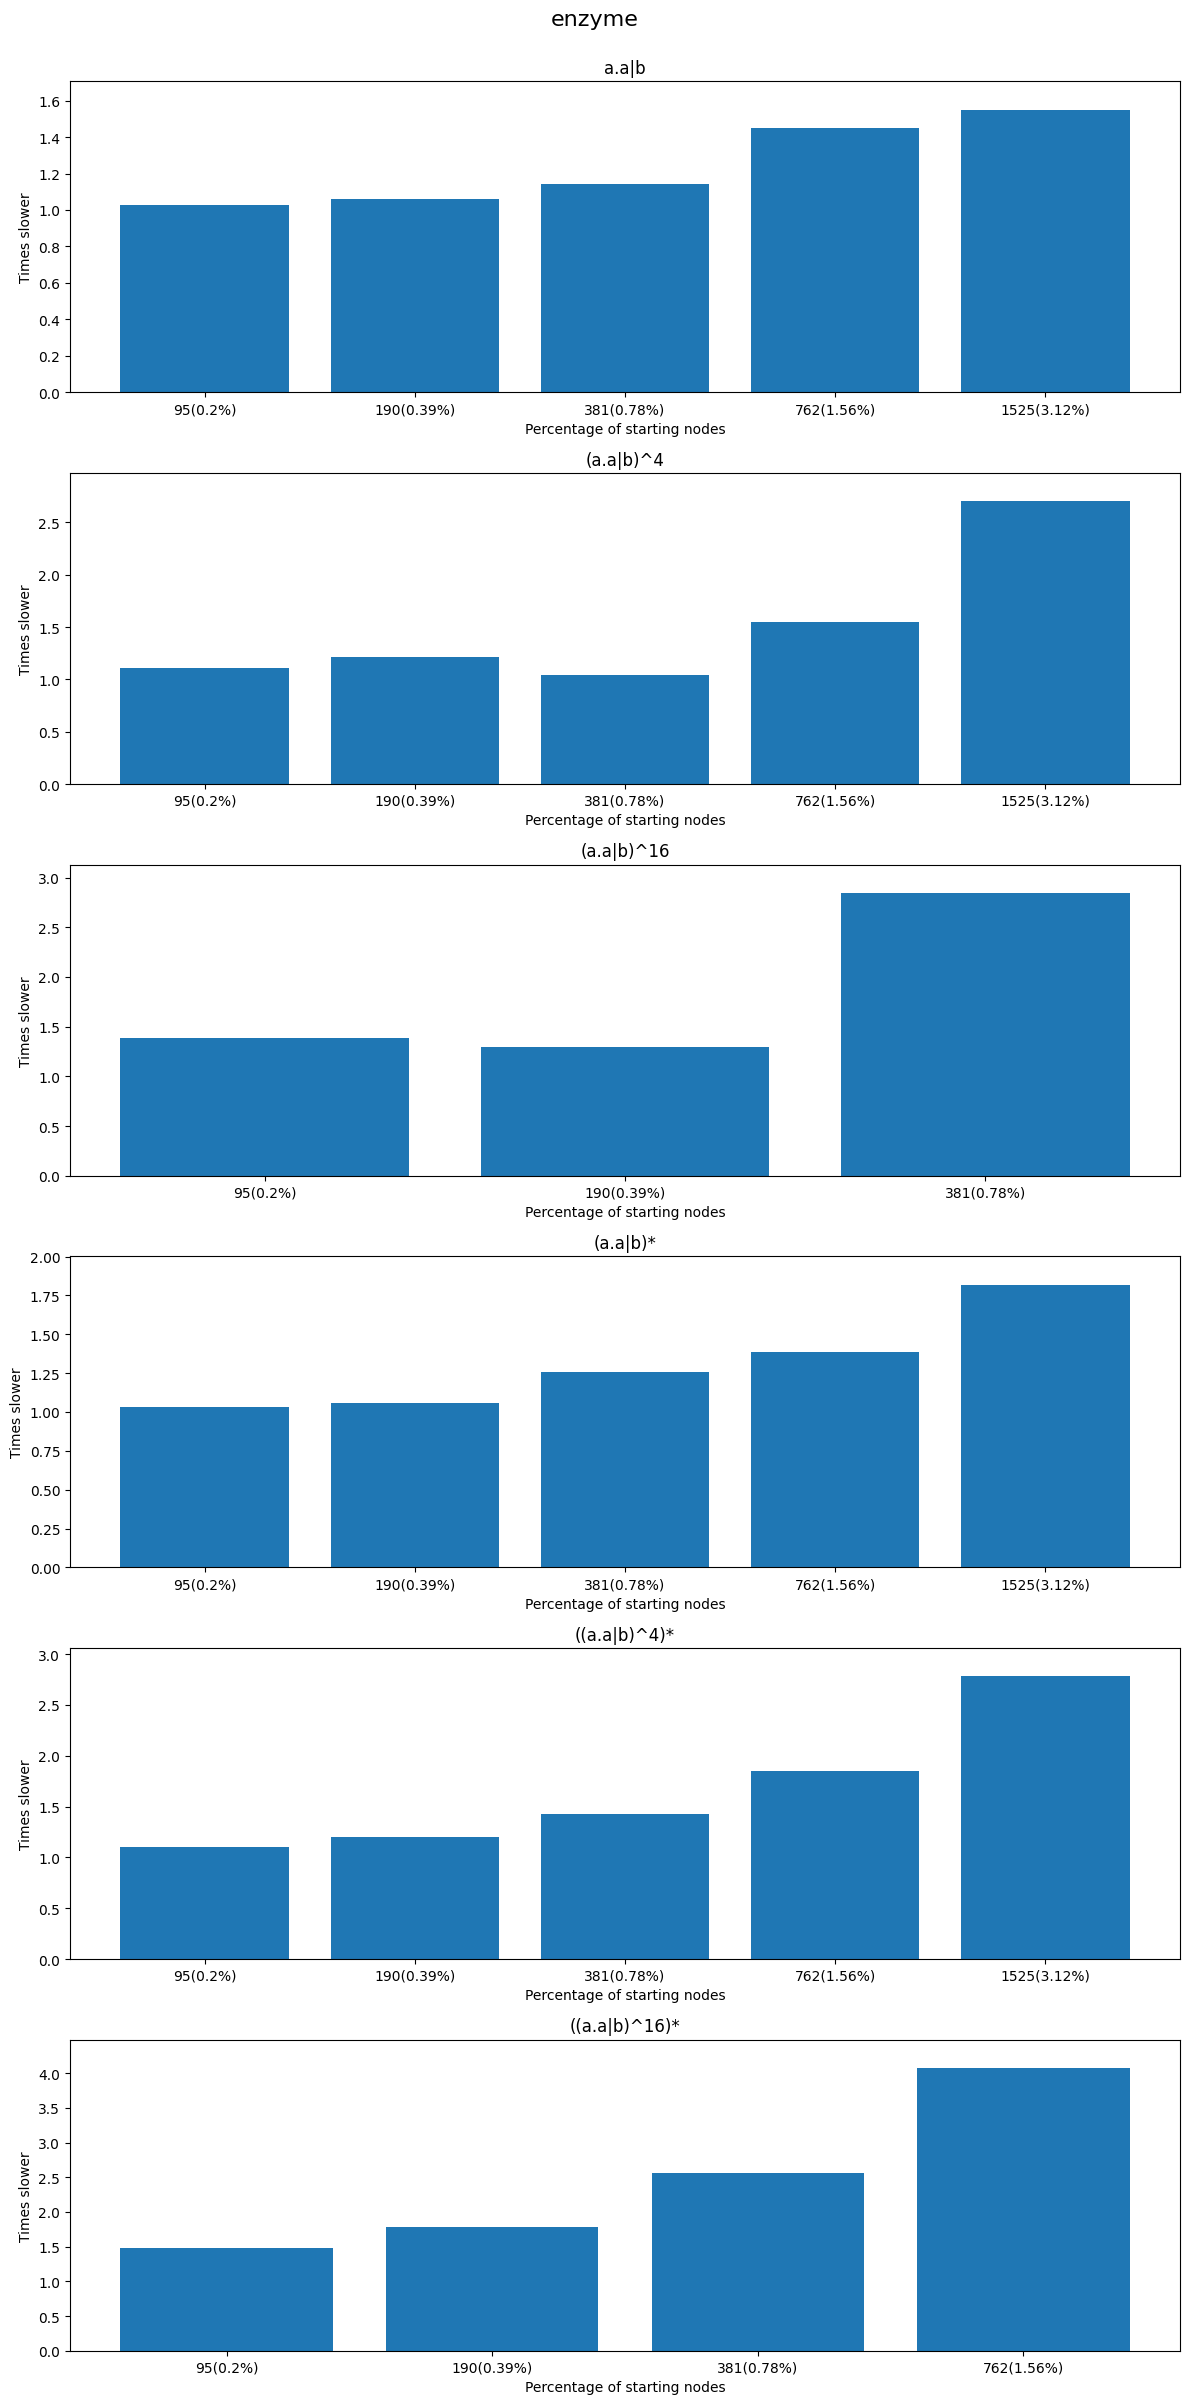

In [ ]:
for graph_name in GRAPHS:
    fig, axs = plt.subplots(nrows=len(REGEXES), figsize=(12, 4 * len(REGEXES)))
    fig.suptitle(graph_name, y=1, fontsize=16)
    graph = get_graph(graph_name)
    nodes_total = graph.number_of_nodes()
    starting_percentages = [
        percent
        for percent in get_starting_percentages_for_graph(graph)
        if percent < 4
    ]
    for (ax, (regex_name, _)) in zip(axs, REGEXES):
        ax: plt.Axes = ax
        ax.set_title(regex_name)
        ax.set_ylabel("Times slower")
        ax.set_xlabel("Percentage of starting nodes")
        ax.xaxis.set_major_formatter(ScalarFormatter())
        label_positions = np.arange(len(starting_percentages))
        ax.set_xticks(
            label_positions,
            [
                f"{int(nodes_total / 100 * percent)}({round(percent, 2)}%)"
                for percent in sorted(starting_percentages)
            ],
            fontsize=10,
        )
        ys = [
            res[
                (
                    get_multiple_source_rpq_algorithm_name(
                        group_by_start=True, starting_percentage=starting_percentage
                    ),
                    graph_name,
                    regex_name,
                    "pygraphblas",
                )
            ][0]
            / res[
                (
                    get_multiple_source_rpq_algorithm_name(
                        group_by_start=False,
                        starting_percentage=starting_percentage,
                    ),
                    graph_name,
                    regex_name,
                    "pygraphblas",
                )
            ][0]
            for starting_percentage in sorted(starting_percentages)
        ]
        if len(list(finites(ys))) > 0:
            ax.bar(x=label_positions, height=ys)
        ax.set_ylim(bottom=0, top=1.1 * max(list(finites(ys)) + [1]))
    fig.tight_layout()
    plt.show()